# <font color='Green'> **Sentiment Analysis based on Product Review Text and Review Title** </font>

### Business Objective

Ebuss is an e-commerce company. Ebuss has captured a huge market share in many fields, and it sells the products in various categories such as household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products and health care products.With the advancement in technology, it is imperative for Ebuss to grow quickly in the e-commerce market to become a major leader in the market because it has to compete with the likes of Amazon, Flipkart, etc., which are already market leaders.

As a senior ML Engineer, we need to build a model that will improve the recommendations given to the users given their past reviews text and title. 

### Business Goal

In order to do this, you planned to build a sentiment-based product recommendation system, which includes the following tasks.

       1) Data sourcing and sentiment analysis
       2) Building a recommendation system
       3) Improving the recommendations using the sentiment analysis model
       4) Deploying the end-to-end project with a user interface
    
### Data Input
1. sample30.csv: This dataset consists of 30,000 reviews for more than 200 different products. The reviews and ratings are given by more than 20,000 users.

### <font color='magenta'><i>Import all required libraries

In [1]:
#import the libraries
import pandas as pd , numpy as np
# import matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,date
# Using wordcloud to show frequest words from data
from wordcloud import WordCloud
import re
# Downloads the data.
import nltk
nltk.download('stopwords')
# Using the stopwords.
from nltk.corpus import stopwords
%matplotlib inline
# set options for display
pd.set_option("display.max_rows",500)
pd.set_option("display.max_columns",500)
pd.set_option("display.width",1000)
pd.set_option('display.max_colwidth', 20)
pd.options.display.float_format = "{:.2f}".format
#Ignoring warnings
pd.options.mode.chained_assignment = None  # default='warn' this supress warning.
import pickle

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/taraknathkonar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [107]:
# NPL
from textblob import TextBlob
import nltk
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.util import ngrams
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
import scikitplot as skplt
from xgboost import XGBClassifier

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/taraknathkonar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Common Functions used in this module
# This function will be called couple of times in this program, to have common configuration and set x,y label and title
def pltConfigAndShow(xlabel,ylabel,title):
    sns.set_style("dark")
    font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
    plt.rc('font', **font)
    plt.ylabel(ylabel,fontsize=20)
    plt.xlabel(xlabel,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

#Assign stop words
def setStopWords():
  stopwords_custom = set(stopwords.words('english'))
  return stopwords_custom

def showFrequestWords(data, title):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=setStopWords(),
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
        ).generate(str(data))

    fig = plt.figure(1, figsize=(20, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=25)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [4]:
productAtributes = pd.read_csv('Data+Attribute+Description.csv' , encoding='latin-1')
productAtributes.head

<bound method NDFrame.head of               Attribute Attribute Description
0                    id  Uniques identity... 
1                 brand  Name of the bran... 
2            categories  Category of the ... 
3          manufacturer  Name of the manu... 
4                  name  Name of the prod... 
5          reviews_date  Date on which th... 
6   reviews_didPurchase  Whether a partic... 
7   reviews_doRecommend  Whether a partic... 
8        reviews_rating  Rating given by ... 
9          reviews_text  Review given by ... 
10        reviews_title  The title of the... 
11     reviews_userCity  The residing cit... 
12  reviews_userProv...  The residing pro... 
13     reviews_username  The unique ident... 
14       user_sentiment  The overall sent... >

In [5]:
productReviews = pd.read_csv('sample30.csv' , encoding='latin-1')
productReviews.head(3)

id            brand           categories         manufacturer                 name         reviews_date reviews_didPurchase reviews_doRecommend  reviews_rating         reviews_text reviews_title reviews_userCity reviews_userProvince reviews_username user_sentiment
0  AV13O1A8GV-KLJ3a...  Universal Music  Movies, Music & ...  Universal Music ...  Pink Friday: Rom...  2012-11-30T06:21...                 NaN                 NaN               5  i love this albu...  Just Awesome      Los Angeles                  NaN           joshua       Positive
1  AV14LG0R-jtxr-f3...         Lundberg  Food,Packaged Fo...             Lundberg  Lundberg Organic...  2017-07-09T00:00...                True                 NaN               5  Good flavor. Thi...          Good              NaN                  NaN        dorothy w       Positive
2  AV14LG0R-jtxr-f3...         Lundberg  Food,Packaged Fo...             Lundberg  Lundberg Organic...  2017-07-09T00:00...                True                 NaN               5         Good flavor.          Good              NaN                  NaN        dorothy w       Positive

In [6]:
productReviews.shape

(30000, 15)

In [7]:
productReviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [8]:
productReviews.isnull().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

In [9]:
(productReviews['reviews_userProvince'].isnull().sum()/productReviews['reviews_rating'].count())*100

99.43333333333332

In [10]:
(productReviews['reviews_userCity'].isnull().sum()/productReviews['reviews_rating'].count())*100

93.57

#### <font color='magenta'><i>We See lot of Null values for Reviews_userCity (93.57%) and Reviews_UserProvince (99.4%). So removing both columns. We also do not need id column now



In [11]:
productReviews.drop(['id','reviews_userCity','reviews_userProvince'],axis=1,inplace=True)

In [12]:
productReviews.isnull().sum()


brand                      0
categories                 0
manufacturer             141
name                       0
reviews_date              46
reviews_didPurchase    14068
reviews_doRecommend     2570
reviews_rating             0
reviews_text               0
reviews_title            190
reviews_username          63
user_sentiment             1
dtype: int64

#### <font color='magenta'><i>Checking how many Unique Products and Users we have

In [13]:
# How many Number of Unique Product we have
productReviews['name'].unique().size

271

In [14]:
# How many Number of Unique Users we have
productReviews['reviews_username'].unique().size

24915

#### <font color='magenta'><i>Checking for Manufacturer is null for how many unique products

In [15]:
productReviewsManufactureNull=productReviews[(productReviews['manufacturer'].isnull())]
print(productReviewsManufactureNull.shape)
productReviewsManufactureNull['name'].unique()

(141, 12)


array(['Alex Cross (dvdvideo)'], dtype=object)

In [16]:
# we do not see any record exist for that product where Manufacturer is there
productReviews[(productReviews['name']=='Alex Cross (dvdvideo)')]['manufacturer'].unique()

array([nan], dtype=object)

In [17]:
productReviews[(productReviews['name']=='Alex Cross (dvdvideo)')]['brand'].unique()

array(['Summit Entertainment'], dtype=object)

In [18]:
productReviews.head(3)

brand           categories         manufacturer                 name         reviews_date reviews_didPurchase reviews_doRecommend  reviews_rating         reviews_text reviews_title reviews_username user_sentiment
0  Universal Music  Movies, Music & ...  Universal Music ...  Pink Friday: Rom...  2012-11-30T06:21...                 NaN                 NaN               5  i love this albu...  Just Awesome           joshua       Positive
1         Lundberg  Food,Packaged Fo...             Lundberg  Lundberg Organic...  2017-07-09T00:00...                True                 NaN               5  Good flavor. Thi...          Good        dorothy w       Positive
2         Lundberg  Food,Packaged Fo...             Lundberg  Lundberg Organic...  2017-07-09T00:00...                True                 NaN               5         Good flavor.          Good        dorothy w       Positive

In [19]:
# above we see brand and Manufacturer column most of the cases same. Checking how many records having same Brand and Manufacturer column. 
len(productReviews[(productReviews['manufacturer']==productReviews['brand'])].index)

13309

####  <font color='magenta'><i>So for most of the product we have Brand same as Manufacturer. Also we have seen earlier there are 141 missing values in Manufacturer Column. So we will keep only Brand column and can drop manufacturer column

In [20]:
# Now we have checked almost 50% records (13309) having Brand and Manufacturer same value. So we can remove Brand Column. As it also indicates Manufacturer
productReviews.drop(['manufacturer'],axis=1,inplace=True)

In [21]:
productReviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   brand                30000 non-null  object
 1   categories           30000 non-null  object
 2   name                 30000 non-null  object
 3   reviews_date         29954 non-null  object
 4   reviews_didPurchase  15932 non-null  object
 5   reviews_doRecommend  27430 non-null  object
 6   reviews_rating       30000 non-null  int64 
 7   reviews_text         30000 non-null  object
 8   reviews_title        29810 non-null  object
 9   reviews_username     29937 non-null  object
 10  user_sentiment       29999 non-null  object
dtypes: int64(1), object(10)
memory usage: 2.5+ MB


/Users/taraknathkonar/_11Tarak/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


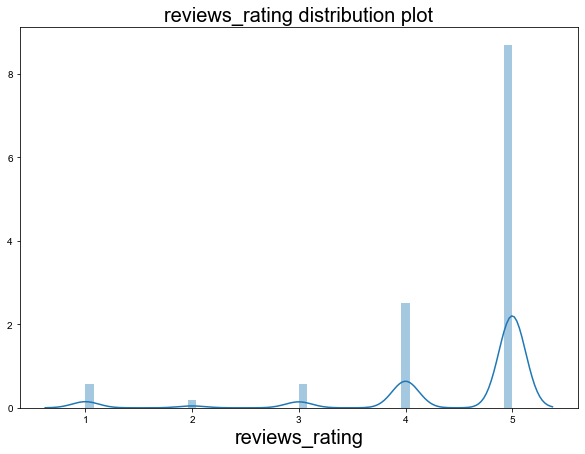

In [22]:
# Distribution of User Rating Column
plt.figure(figsize=(10, 7))
# Creating distribution plot for Sale price to check if follow normal distribution
sns.distplot(productReviews['reviews_rating'])
pltConfigAndShow('reviews_rating','','reviews_rating distribution plot')

#### <font color='magenta'><i>We see 4 and 5 ratings are more in the data set

In [23]:
(productReviews['reviews_didPurchase'].value_counts()/productReviews['reviews_didPurchase'].count())*100

False   91.00
True     9.00
Name: reviews_didPurchase, dtype: float64

#### <font color='magenta'><i>Checking if any we can derive or corelated reviews_didpurchase column with any other relevant columns

In [24]:
productReviews[(productReviews['reviews_didPurchase']==False)]['reviews_rating'].value_counts()

5    10941
4     2254
1      776
3      373
2      154
Name: reviews_rating, dtype: int64

In [25]:
productReviews[(productReviews['reviews_didPurchase']==False)]['user_sentiment'].value_counts()

Positive    12863
Negative     1635
Name: user_sentiment, dtype: int64

In [26]:
productReviews[(productReviews['reviews_didPurchase']==False)]['reviews_doRecommend'].value_counts()

True     13040
False     1017
Name: reviews_doRecommend, dtype: int64

#### <font color='magenta'><i>As we can not determine reviews_didPurchase based on any other column, We will set missing values as False, as 91% of total values are false. So considering Frequency of the data to put missing values

In [27]:
#Replacing considering frequency
productReviews['reviews_didPurchase']=productReviews['reviews_didPurchase'].replace(np.NaN,False)

/Users/taraknathkonar/_11Tarak/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


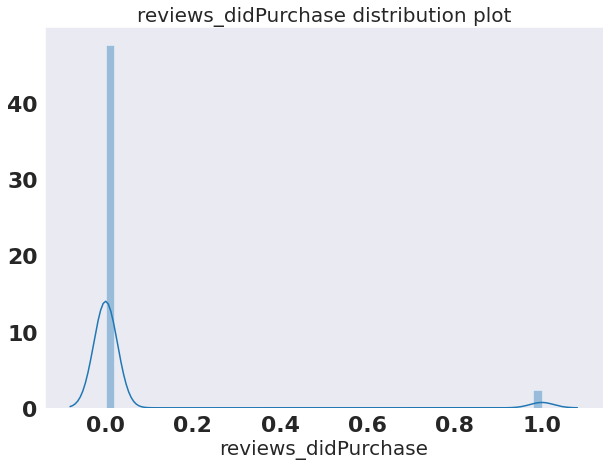

In [28]:
# Distribution of reviews_didPurchase Column after adding mising values based on frequency
plt.figure(figsize=(10, 7))
# Creating distribution plot for Sale price to check if follow normal distribution
sns.distplot(productReviews['reviews_didPurchase'])
pltConfigAndShow('reviews_didPurchase','','reviews_didPurchase distribution plot')

In [29]:
#Checking few review text for the data where did purchase as false
pd.set_option('display.max_colwidth', 150)
stopwords_custom=setStopWords()
purchaseWords=['Purchased','purchase','bought','Bought','Buy','buy','purchased','promotional','promotion']
#print(stopwords)
for sentence in productReviews[(productReviews['reviews_didPurchase']==False)]['reviews_text'].head(100):
  resultwords=[word for word in sentence.split() if word.lower() not in stopwords_custom]
  if any(word in purchaseWords for word in resultwords):
    print(resultwords)

['husband', 'bought', 'gel', 'us.', 'gel', 'caused', 'irritation', 'felt', 'like', 'burning', 'skin.', 'recommend', 'gel.']
['boyfriend', 'bought', 'spice', 'things', 'bedroom', 'highly', 'disappointed', 'product.', 'bought', 'one', 'absolutely', 'love', 'ky', 'mine', 'thought', 'would', 'similar', 'affect', 'absolutely', 'nothing.', 'buy.']
['Bought', 'earlier', 'today', 'excited', 'check', 'out.', 'Based', 'product', 'description', 'expecting', 'something', 'like', 'regular', 'KY.', 'fans', 'expected', 'left', 'little', 'disappointed.']
['bought', 'product', 'husband', 'try', 'impressed', 'all.', 'tingling', 'warming.', 'left', 'us', 'sticky.', 'used', 'KY', 'products', 'past', '(loved', 'KY', 'hers)', 'one', 'disappointing.']
['husband', 'bought', 'extra', 'fun.', 'werevboth', 'extremely', 'disappointed.', 'Especially', 'price!', 'waste', 'money', 'product.', 'felt', 'nothing', 'sticky', 'mess', 'it.']
['Purchased', 'thinking', 'would', 'sort', 'warming', 'effect', 'original.', 'was

#### <font color='magenta'><i>So we see most of the users who provided reviews and reviews_didPurchase is false - They may be actually bought/purchased the product as per review comments or may be they have used the product during promotional activities. So we can ignore this column reviews_didPurchase

In [30]:
#dropping reviews_didPurchase column
productReviews.drop(['reviews_didPurchase'],axis=1,inplace=True)

In [31]:
productReviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   brand                30000 non-null  object
 1   categories           30000 non-null  object
 2   name                 30000 non-null  object
 3   reviews_date         29954 non-null  object
 4   reviews_doRecommend  27430 non-null  object
 5   reviews_rating       30000 non-null  int64 
 6   reviews_text         30000 non-null  object
 7   reviews_title        29810 non-null  object
 8   reviews_username     29937 non-null  object
 9   user_sentiment       29999 non-null  object
dtypes: int64(1), object(9)
memory usage: 2.3+ MB


In [32]:
(productReviews['reviews_doRecommend'].value_counts()/productReviews['reviews_doRecommend'].count())*100

True    94.35
False    5.65
Name: reviews_doRecommend, dtype: float64

In [33]:

(productReviews[(productReviews['reviews_doRecommend']==True)]['reviews_rating'].value_counts()/productReviews[(productReviews['reviews_doRecommend']==True)]['reviews_rating'].count())*100

5   74.75
4   21.80
3    3.06
2    0.21
1    0.17
Name: reviews_rating, dtype: float64

In [34]:
(productReviews[(productReviews['reviews_doRecommend']==False)]['reviews_rating'].value_counts()/productReviews[(productReviews['reviews_doRecommend']==False)]['reviews_rating'].count())*100

1   54.26
3   22.90
2   15.48
5    4.13
4    3.23
Name: reviews_rating, dtype: float64

#### <font color='magenta'><i>Checking missing reviews_doRecommend values what is the reviews_rating

In [35]:
productReviews[(productReviews['reviews_doRecommend'].isnull())]['reviews_rating'].value_counts()

5    1421
1     498
4     328
3     197
2     126
Name: reviews_rating, dtype: int64

In [36]:
productReviews[(productReviews['reviews_rating']==3)]['reviews_doRecommend'].value_counts()

True     793
False    355
Name: reviews_doRecommend, dtype: int64

#### <font color='magenta'><i>So for missing values of reviews_doRecommend, if we check reviews_rating column then if rating 3,4,5 we can make it to true else can set it to False

In [37]:
productReviews['reviews_doRecommend']=productReviews['reviews_rating'].apply(lambda x: True if x>=3 else False)

/Users/taraknathkonar/_11Tarak/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


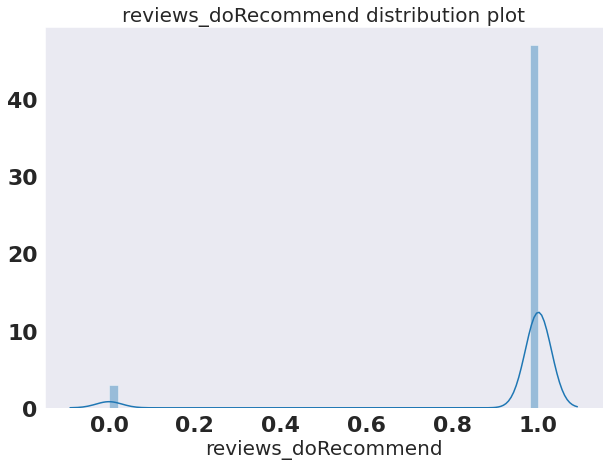

In [38]:
# Distribution of reviews_doRecommend Column after adding mising values based on reviews rating
plt.figure(figsize=(10, 7))
# Creating distribution plot for Sale price to check if follow normal distribution
sns.distplot(productReviews['reviews_doRecommend'])
pltConfigAndShow('reviews_doRecommend','','reviews_doRecommend distribution plot')

#### <font color='magenta'><i>So we see most of the users review recommends the product. This is matching with the reviews_rating distribution as most of the ratings were 3, 4 or 5

In [39]:
productReviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   brand                30000 non-null  object
 1   categories           30000 non-null  object
 2   name                 30000 non-null  object
 3   reviews_date         29954 non-null  object
 4   reviews_doRecommend  30000 non-null  bool  
 5   reviews_rating       30000 non-null  int64 
 6   reviews_text         30000 non-null  object
 7   reviews_title        29810 non-null  object
 8   reviews_username     29937 non-null  object
 9   user_sentiment       29999 non-null  object
dtypes: bool(1), int64(1), object(8)
memory usage: 2.1+ MB


In [40]:
productReviews.head(5)

brand                                                                                                                                             categories                                        name              reviews_date  reviews_doRecommend  reviews_rating                                                                                                                                           reviews_text reviews_title reviews_username user_sentiment
0  Universal Music  Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream...   Pink Friday: Roman Reloaded Re-Up (w/dvd)  2012-11-30T06:21:45.000Z                 True               5  i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it ...  Just Awesome           joshua       Positive
1         Lundberg                                                                           Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes  Lundberg Organic Cinnamon Toast Rice Cakes  2017-07-09T00:00:00.000Z                 True               5                                                                                         Good flavor. This review was collected as part of a promotion.          Good        dorothy w       Positive
2         Lundberg                                                                           Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes  Lundberg Organic Cinnamon Toast Rice Cakes  2017-07-09T00:00:00.000Z                 True               5                                                                                                                                           Good flavor.          Good        dorothy w       Positive
3              K-Y                                                                  Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants            K-Y Love Sensuality Pleasure Gel  2016-01-06T00:00:00.000Z                False               1  I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even ...  Disappointed          rebecca       Negative
4              K-Y                                                                  Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants            K-Y Love Sensuality Pleasure Gel  2016-12-21T00:00:00.000Z                False               1                   My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.    Irritation        walker557       Negative

In [41]:
productReviews['reviews_date'].unique()

array(['2012-11-30T06:21:45.000Z', '2017-07-09T00:00:00.000Z',
       '2016-01-06T00:00:00.000Z', ..., '2017-01-30T22:41:43.000Z',
       '2017-01-25T19:32:51.000Z', '2017-08-04T15:01:04.000Z'],
      dtype=object)

In [42]:
productReviews['reviews_date']=pd.to_datetime(productReviews['reviews_date'], format='%Y-%m-%d',errors='coerce').dt.date

In [43]:
productReviews.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   brand                30000 non-null  object
 1   categories           30000 non-null  object
 2   name                 30000 non-null  object
 3   reviews_date         29946 non-null  object
 4   reviews_doRecommend  30000 non-null  bool  
 5   reviews_rating       30000 non-null  int64 
 6   reviews_text         30000 non-null  object
 7   reviews_title        29810 non-null  object
 8   reviews_username     29937 non-null  object
 9   user_sentiment       29999 non-null  object
dtypes: bool(1), int64(1), object(8)
memory usage: 2.1+ MB


In [44]:
productReviews['reviews_date'] = pd.to_datetime(productReviews['reviews_date'])

In [45]:
productReviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   brand                30000 non-null  object        
 1   categories           30000 non-null  object        
 2   name                 30000 non-null  object        
 3   reviews_date         29946 non-null  datetime64[ns]
 4   reviews_doRecommend  30000 non-null  bool          
 5   reviews_rating       30000 non-null  int64         
 6   reviews_text         30000 non-null  object        
 7   reviews_title        29810 non-null  object        
 8   reviews_username     29937 non-null  object        
 9   user_sentiment       29999 non-null  object        
dtypes: bool(1), datetime64[ns](1), int64(1), object(7)
memory usage: 2.1+ MB


In [46]:
#Creating a new Column for Reviews Age, Review Year and Review Month
productReviews['reviews_age']=productReviews['reviews_date'].apply(lambda x: (datetime.today()-x).days)
productReviews['reviews_year']=productReviews['reviews_date'].dt.year
productReviews['reviews_month']=productReviews['reviews_date'].dt.month

In [47]:
productReviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   brand                30000 non-null  object        
 1   categories           30000 non-null  object        
 2   name                 30000 non-null  object        
 3   reviews_date         29946 non-null  datetime64[ns]
 4   reviews_doRecommend  30000 non-null  bool          
 5   reviews_rating       30000 non-null  int64         
 6   reviews_text         30000 non-null  object        
 7   reviews_title        29810 non-null  object        
 8   reviews_username     29937 non-null  object        
 9   user_sentiment       29999 non-null  object        
 10  reviews_age          29946 non-null  float64       
 11  reviews_year         29946 non-null  float64       
 12  reviews_month        29946 non-null  float64       
dtypes: bool(1), datetime64[ns](1), 

In [48]:
# For missing age values replacing with Median
productReviews['reviews_age'].fillna(productReviews['reviews_age'].median(),inplace=True)

/Users/taraknathkonar/_11Tarak/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


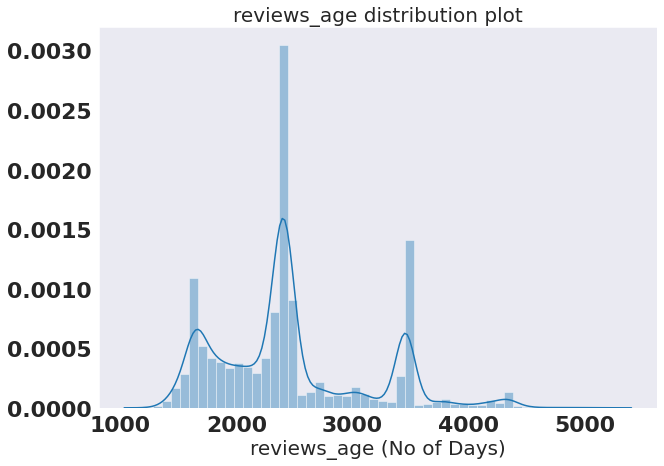

/Users/taraknathkonar/_11Tarak/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


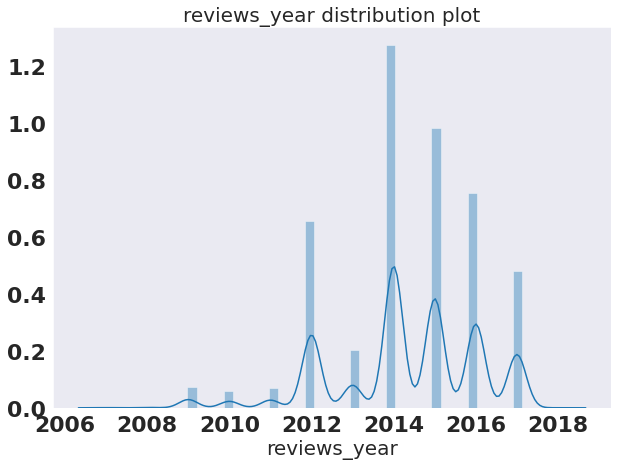

/Users/taraknathkonar/_11Tarak/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


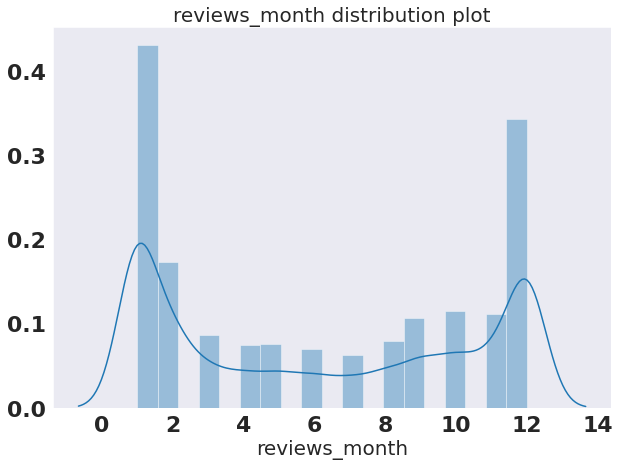

In [49]:
# Distribution of reviews_age Column after adding mising values based on reviews rating
plt.figure(figsize=(10, 7))
# Creating distribution plot for reviews_age to check if follow normal distribution
sns.distplot(productReviews['reviews_age'])
pltConfigAndShow('reviews_age (No of Days)','','reviews_age distribution plot')
plt.figure(figsize=(10, 7))
sns.distplot(productReviews['reviews_year'])
pltConfigAndShow('reviews_year','','reviews_year distribution plot')
plt.figure(figsize=(10, 7))
sns.distplot(productReviews['reviews_month'])
pltConfigAndShow('reviews_month','','reviews_month distribution plot')

#### <font color='magenta'><i> So we see there is a peak where age of review is 1500 , 2500 and 3500 days around . Most of the reviews are in between 1500 and 2500 days older. Most of the reviews taken on year 2014,2014,2015,2016 & 2017. 2014 has higher number of reviews. We also see More reviews on Dec, Jan month. So most of the sales happening during that time

In [50]:
productReviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   brand                30000 non-null  object        
 1   categories           30000 non-null  object        
 2   name                 30000 non-null  object        
 3   reviews_date         29946 non-null  datetime64[ns]
 4   reviews_doRecommend  30000 non-null  bool          
 5   reviews_rating       30000 non-null  int64         
 6   reviews_text         30000 non-null  object        
 7   reviews_title        29810 non-null  object        
 8   reviews_username     29937 non-null  object        
 9   user_sentiment       29999 non-null  object        
 10  reviews_age          30000 non-null  float64       
 11  reviews_year         29946 non-null  float64       
 12  reviews_month        29946 non-null  float64       
dtypes: bool(1), datetime64[ns](1), 

In [51]:
# as we have now reviews Age, we do not need Reviews_date Column now. So dropping Reviews_date
productReviews.drop(['reviews_date'],axis=1,inplace=True)

In [52]:
productReviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   brand                30000 non-null  object 
 1   categories           30000 non-null  object 
 2   name                 30000 non-null  object 
 3   reviews_doRecommend  30000 non-null  bool   
 4   reviews_rating       30000 non-null  int64  
 5   reviews_text         30000 non-null  object 
 6   reviews_title        29810 non-null  object 
 7   reviews_username     29937 non-null  object 
 8   user_sentiment       29999 non-null  object 
 9   reviews_age          30000 non-null  float64
 10  reviews_year         29946 non-null  float64
 11  reviews_month        29946 non-null  float64
dtypes: bool(1), float64(3), int64(1), object(7)
memory usage: 2.5+ MB


In [53]:
#Replacing 63 User NUll values  with 'UNKNOWN' user
productReviews['reviews_username'].isnull().sum()

63

In [54]:
productReviews['reviews_username']=productReviews['reviews_username'].replace(np.NaN,'UNKNOWN')

In [55]:
productReviews['reviews_username'].value_counts()

UNKNOWN              63
byamazon customer    41
mike                 41
chris                32
lisa                 16
                     ..
vina                  1
vbelk01               1
otcc                  1
quisha                1
hossy83               1
Name: reviews_username, Length: 24915, dtype: int64

#### <font color='magenta'><i>Excluding UNKNOWN user, Few users like byAmazon Customer, Mike, Chris. Lisa has given multiple reviews given multiple reviews

In [56]:
productReviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   brand                30000 non-null  object 
 1   categories           30000 non-null  object 
 2   name                 30000 non-null  object 
 3   reviews_doRecommend  30000 non-null  bool   
 4   reviews_rating       30000 non-null  int64  
 5   reviews_text         30000 non-null  object 
 6   reviews_title        29810 non-null  object 
 7   reviews_username     30000 non-null  object 
 8   user_sentiment       29999 non-null  object 
 9   reviews_age          30000 non-null  float64
 10  reviews_year         29946 non-null  float64
 11  reviews_month        29946 non-null  float64
dtypes: bool(1), float64(3), int64(1), object(7)
memory usage: 2.5+ MB


In [57]:
productReviews['user_sentiment'].value_counts()

Positive    26632
Negative     3367
Name: user_sentiment, dtype: int64

In [58]:
#There is one value missing for User_Sentiment
productReviews[(productReviews['user_sentiment'].isnull())]

brand                                                                                                                                             categories                                                                 name  reviews_doRecommend  reviews_rating                                                                                                                                           reviews_text                                    reviews_title reviews_username user_sentiment  reviews_age  reviews_year  reviews_month
28354  Disney  Movies, Music & Books,Movies,Kids' & Family,Ways To Shop Entertainment,Movies & Tv On Blu-Ray,Movies & TV,Disney,Blu-ray,Children & Family,Movies ...  Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)                 True               5  my kids absolutely loved this film so much that we watched it twice. Having a digital copy means that every time we get in the car we get to watch...  a super hit with my children. they loved it!!??         7.87E+11            NaN      2444.00       2014.00          11.00

In [59]:
#So the only missig record given rating 5 and recommends the product so setting User_sentiment for the missing value as Positive

productReviews['user_sentiment']=productReviews['user_sentiment'].replace(np.NaN,'Positive')

In [60]:
productReviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   brand                30000 non-null  object 
 1   categories           30000 non-null  object 
 2   name                 30000 non-null  object 
 3   reviews_doRecommend  30000 non-null  bool   
 4   reviews_rating       30000 non-null  int64  
 5   reviews_text         30000 non-null  object 
 6   reviews_title        29810 non-null  object 
 7   reviews_username     30000 non-null  object 
 8   user_sentiment       30000 non-null  object 
 9   reviews_age          30000 non-null  float64
 10  reviews_year         29946 non-null  float64
 11  reviews_month        29946 non-null  float64
dtypes: bool(1), float64(3), int64(1), object(7)
memory usage: 2.5+ MB


In [61]:
# Checking few reviews_title with corresponding to different rating
productReviews[(productReviews['reviews_rating']==5 )]['reviews_title'].unique()[:10]

array(['Just Awesome', 'Good', 'Loved', 'Great sensation',
       'That little extra something..', 'Great Product!',
       "Why wouldn't you try it", 'Amazing!', 'Amazing',
       'Yummilicious And...'], dtype=object)

In [62]:
productReviews[(productReviews['reviews_rating']==1)]['reviews_title'].unique()[:10]

array(['Disappointed', 'Irritation', 'Not worth it', 'Disappointing',
       'Not happy at all', 'Very disappointing', "Don't buy",
       'pretty dissapoitned', 'Waste of Money', 'waste of money'],
      dtype=object)

#### <font color='magenta'><i>So found reviews Title has relevant information corresponding to Good and Bad rating

In [63]:
# checking few review text corresponding to rating
productReviews[(productReviews['reviews_rating']==5 )]['reviews_text'].unique()[:10]

array(["i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.",
       'Good flavor. This review was collected as part of a promotion.',
       'Good flavor.',
       'Loved This review was collected as part of a promotion.',
       'This is a good product. Will give you a great feeling.',
       'I really enjoyed using this product with my husband. After 20+ years of marriage, things can tend to get a little tired and boring. This was just the thing we needed to shake things up a bit. The packaging and pump dispenser is awesome. The product itself does not disappoint. A little goes a very long way. It provides a slight warming sensation when in use and does not become sticky or tacky in anyway. This is an excellent choice for an intimate lubricant. I received a free product for the purpose of my review. Opinions are 100 my own.',
       'A

In [64]:
productReviews[(productReviews['reviews_rating']==1 )]['reviews_text'].unique()[:10]

array(["I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess.",
       "My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.",
       'My boyfriend and I bought this to spice things up in the bedroom and we were both highly disappointed in this product. We bought this one beca

#### <font color='magenta'><i>So Found review Text also very relevant corresponding to rating

In [65]:
# Replacing Null values on Reviews Title with "NoTitle"
productReviews['reviews_title']=productReviews['reviews_title'].replace(np.NaN,'NoTitle')

In [66]:
# Concatening Both reviews Text and Reviews Title column into one column reviews_text_title as both have relevant text information to determine user sentiment

productReviews['reviews_text_title']=productReviews['reviews_text']+" "+productReviews['reviews_title']

In [67]:
# Checking few reviews_text_title with corresponding to different rating
productReviews[(productReviews['reviews_rating']==5 )]['reviews_text_title'].unique()[:5]

array(["i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy. Just Awesome",
       'Good flavor. This review was collected as part of a promotion. Good',
       'Good flavor. Good',
       'Loved This review was collected as part of a promotion. Loved',
       'This is a good product. Will give you a great feeling. Great sensation'],
      dtype=object)

In [68]:
productReviews[(productReviews['reviews_rating']==1 )]['reviews_text_title'].unique()[:5]

array(["I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess. Disappointed",
       "My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel. Irritation",
       'My boyfriend and I bought this to spice things up in the bedroom and we were both highly disappointed in this product.

#### <font color='magenta'><i>So this new column reviews_text_title having reviews Text and Title will help to determine user sentiment

In [69]:
# as we have reviews_text_title column now, So dropping individual text and title column. 
productReviews.drop(['reviews_text','reviews_title'],axis=1,inplace=True)

In [70]:
productReviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   brand                30000 non-null  object 
 1   categories           30000 non-null  object 
 2   name                 30000 non-null  object 
 3   reviews_doRecommend  30000 non-null  bool   
 4   reviews_rating       30000 non-null  int64  
 5   reviews_username     30000 non-null  object 
 6   user_sentiment       30000 non-null  object 
 7   reviews_age          30000 non-null  float64
 8   reviews_year         29946 non-null  float64
 9   reviews_month        29946 non-null  float64
 10  reviews_text_title   30000 non-null  object 
dtypes: bool(1), float64(3), int64(1), object(6)
memory usage: 2.3+ MB


####  <font color='magenta'><i>Lets Analyze rating based on Manufacturer

In [71]:
ProductReviewsBasedOnManufacturer=pd.pivot_table(data=productReviews,values=['reviews_rating','reviews_username'],index=['brand'],aggfunc={'reviews_rating':'mean','reviews_username':'count'}).rename(columns={'reviews_rating':'AverageRating','reviews_username':'NoOfRatings'})
ProductReviewsBasedOnManufacturer=ProductReviewsBasedOnManufacturer[ProductReviewsBasedOnManufacturer['NoOfRatings']>50].sort_values(by=['AverageRating'],ascending=False)
ProductReviewsBasedOnManufacturer

AverageRating  NoOfRatings
brand                                                 
Bounce                               4.90           87
Avery                                4.89          314
Meguiars                             4.83           65
Clorox                               4.82        10585
Chester's                            4.82          177
Bisquick                             4.80           97
Lundberg                             4.78          414
Lysol                                4.75          155
Vaseline                             4.75          254
Cheetos                              4.73           60
Warner Music Group                   4.69          204
Olay                                 4.69          637
Disney                               4.69         1200
Caress                               4.68           68
Sony Pictures                        4.67          845
Yes to Carrots                       4.66           65
Burt's Bees                          4.65          881
Coty                                 4.65          158
Lionsgate                            4.65          186
Tostitos                             4.62          286
Summit Entertainment                 4.59          813
Universal Home Video                 4.49          668
Warner Bros.                         4.48          458
Ragu                                 4.47           59
TRESemme                             4.44           57
Vicks                                4.41           96
Chips Ahoy                           4.41           69
Hoover                               4.39          362
Cuisinart                            4.39          103
Pleasant Hearth                      4.39          111
Warner Home Video                    4.35         3325
FOX                                  4.34          887
Hormel                               4.31          196
Pantene                              4.29          154
Storkcraft                           4.26          264
Axe                                  4.25           59
Banana Boat                          4.25           72
Just For Men                         4.21          224
Aussie                               4.21           89
Pendaflex                            4.19          310
Head & Shoulders                     4.17           92
Windex                               4.13          348
L'oreal Paris                        4.03         1186
L'Oreal Paris                        3.63          124
Aveeno                               3.43          313
Clear Scalp & Hair Therapy           2.84          372
Nexxus                               1.36          693

#### <font color='magenta'><i>So considering average rating of all the Brands which has more than 100 reviews , 5 Most customer valued brands are - Bounce,Avery,Meguiars,Clorox,Chester's. The worst rated brand is Nexxus

In [72]:
ProductReviewsBasedOnManufacturer=ProductReviewsBasedOnManufacturer.reset_index()

<AxesSubplot:title={'center':'Average rating based on Brand for which there are more than 50 reviews'}, xlabel='brand', ylabel='Average Rating'>

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


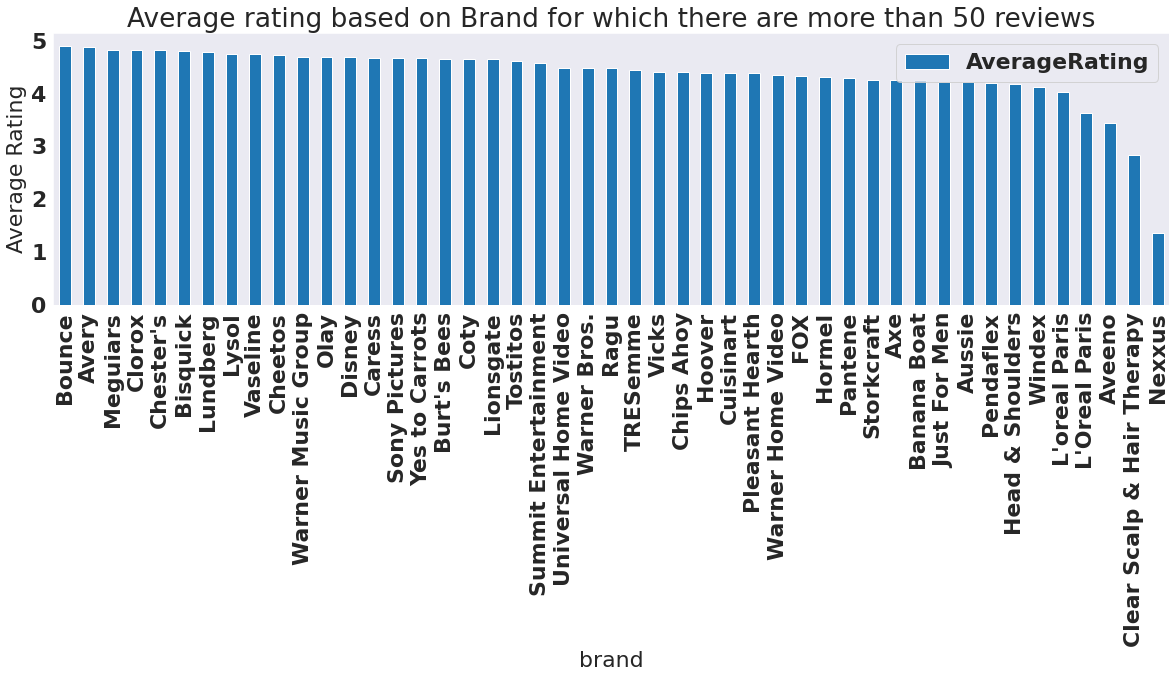

In [73]:
ProductReviewsBasedOnManufacturer.plot(title='Average rating based on Brand for which there are more than 50 reviews',kind='bar',x='brand',y='AverageRating',figsize=(20,5),xlabel='brand',ylabel='Average Rating')

#### <font color='magenta'><i>Clorox has Most reviews, then Warner Home Video

<AxesSubplot:title={'center':'Total Number of Reviews based on Brand for which more tahn 50 reviews'}, xlabel='brand', ylabel='No Of Reviews'>

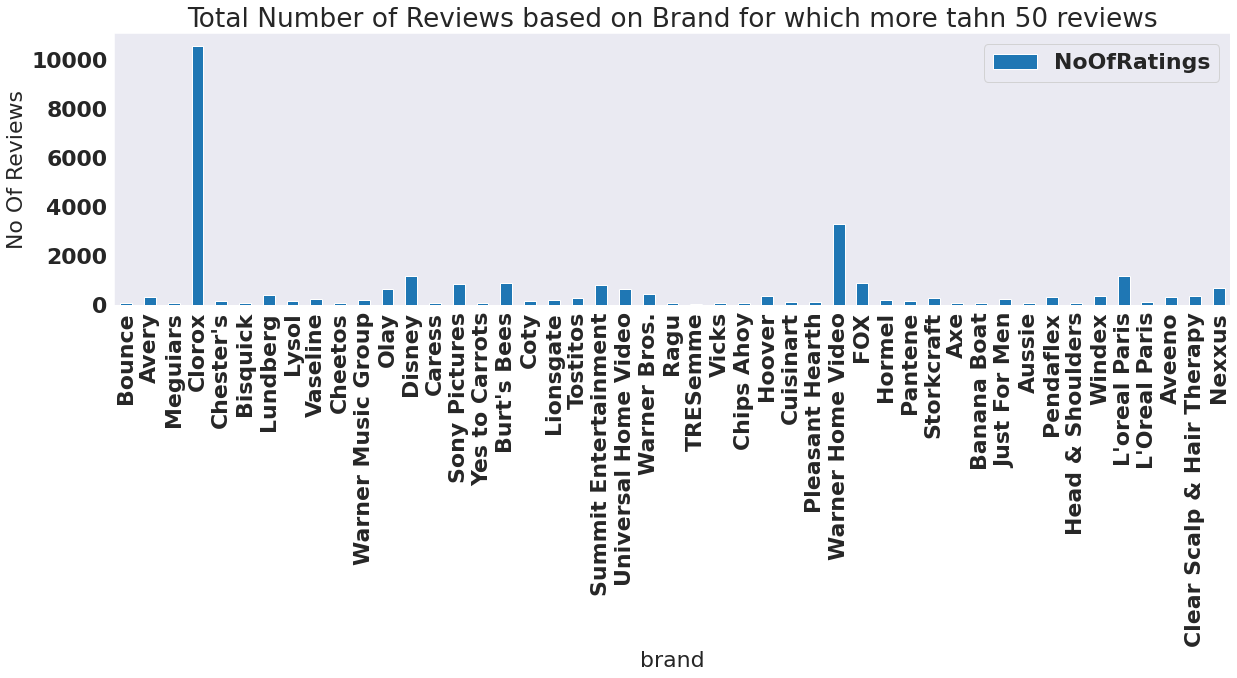

In [74]:
ProductReviewsBasedOnManufacturer.plot(title='Total Number of Reviews based on Brand for which more tahn 50 reviews',kind='bar',x='brand',y='NoOfRatings',figsize=(20,5),xlabel='brand',ylabel='No Of Reviews')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


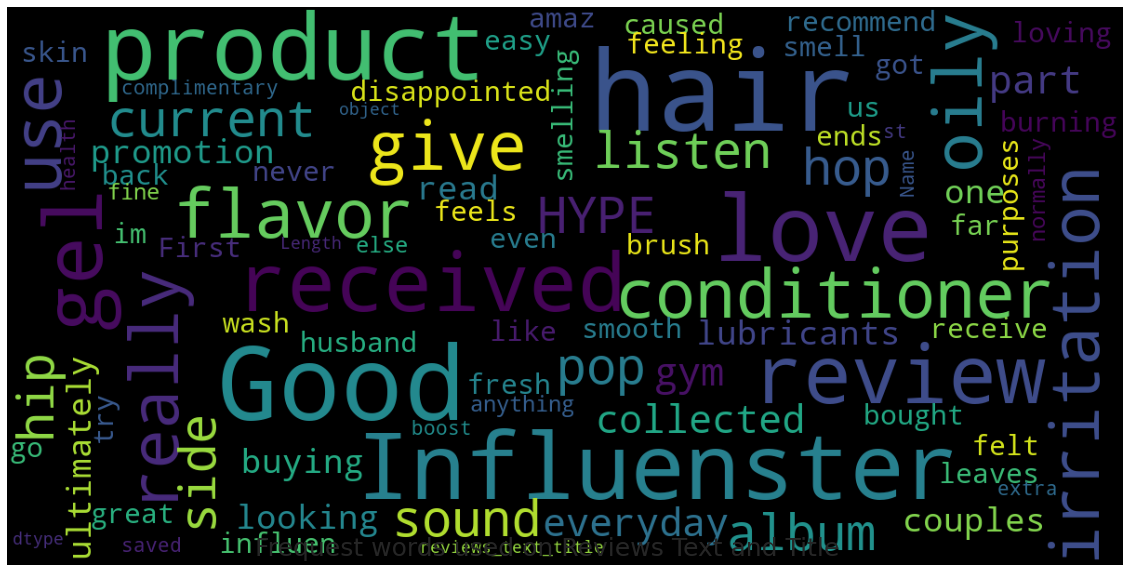

In [75]:
# Showing frequent words from reviews text Title
showFrequestWords(productReviews['reviews_text_title']," Frequest words used on Reviews Text and Title ")

In [76]:
# mapping user Sentiment to 1 and 0
productReviews['user_sentiment'].replace({'Positive':1,'Negative':0},inplace=True)
(productReviews['user_sentiment'].value_counts()/productReviews['user_sentiment'].count())*100

1   88.78
0   11.22
Name: user_sentiment, dtype: float64

### So we see there are total 11.22 % records Negative sentiment and 89% Positive sentiment

<AxesSubplot:>

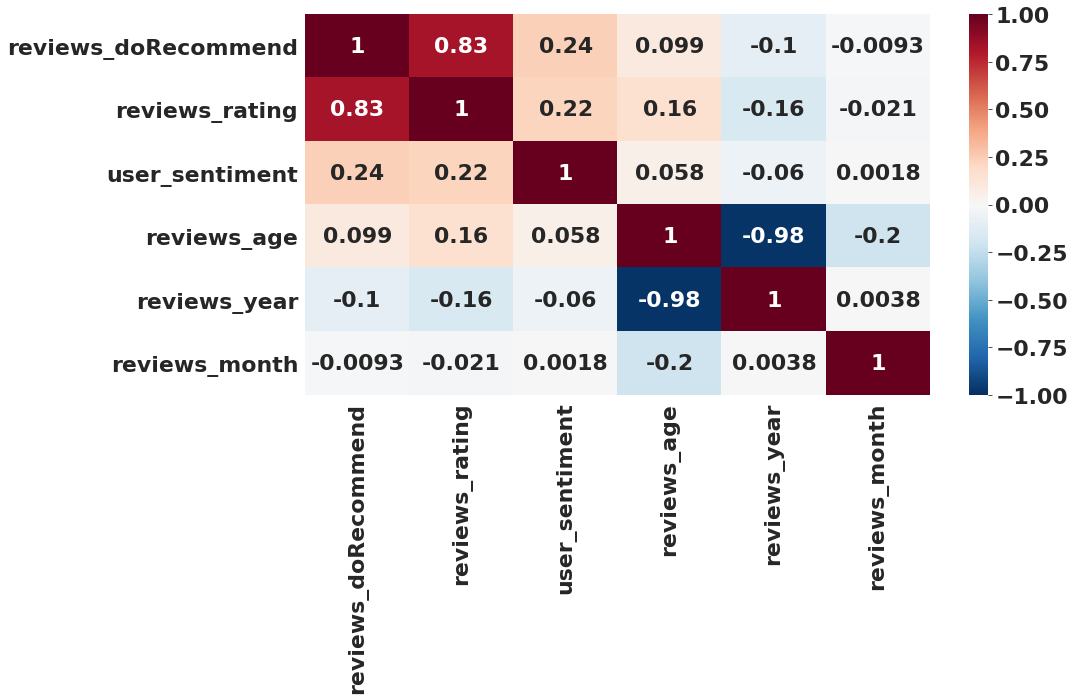

In [77]:
plt.figure(figsize = (14,7))        # Size of the figure
# plot heatmap  to get exact correlation value and how they are correlated for different caregorical ordinal variables
sns.heatmap(productReviews.corr(),annot = True,linewidths=0,vmin=-1,cmap="RdBu_r")

#### <font color='magenta'><i>reviews_doRecommend and reviews_rating has high corelation. As we are considering reviews rating so reviews_doRecommend is not needed.We also see user Sentiment and Reviews Rating has some corelation. But not highly coorelatd. We will check on the data again if User Sentiment column has right sentiment indicated

In [78]:
productReviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   brand                30000 non-null  object 
 1   categories           30000 non-null  object 
 2   name                 30000 non-null  object 
 3   reviews_doRecommend  30000 non-null  bool   
 4   reviews_rating       30000 non-null  int64  
 5   reviews_username     30000 non-null  object 
 6   user_sentiment       30000 non-null  int64  
 7   reviews_age          30000 non-null  float64
 8   reviews_year         29946 non-null  float64
 9   reviews_month        29946 non-null  float64
 10  reviews_text_title   30000 non-null  object 
dtypes: bool(1), float64(3), int64(2), object(5)
memory usage: 2.3+ MB


In [79]:
productReviews['lengthOfReviewTextTitle']=productReviews['reviews_text_title'].str.len()

In [80]:
productReviews.head(5)

brand                                                                                                                                             categories                                        name  reviews_doRecommend  reviews_rating reviews_username  user_sentiment  reviews_age  reviews_year  reviews_month                                                                                                                                     reviews_text_title  lengthOfReviewTextTitle
0  Universal Music  Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream...   Pink Friday: Roman Reloaded Re-Up (w/dvd)                 True               5           joshua               1      3151.00       2012.00          11.00  i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it ...                      214
1         Lundberg                                                                           Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes  Lundberg Organic Cinnamon Toast Rice Cakes                 True               5        dorothy w               1      1469.00       2017.00           7.00                                                                                    Good flavor. This review was collected as part of a promotion. Good                       67
2         Lundberg                                                                           Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes  Lundberg Organic Cinnamon Toast Rice Cakes                 True               5        dorothy w               1      1469.00       2017.00           7.00                                                                                                                                      Good flavor. Good                       17
3              K-Y                                                                  Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants            K-Y Love Sensuality Pleasure Gel                False               1          rebecca               0      2019.00       2016.00           1.00  I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even ...                      709
4              K-Y                                                                  Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants            K-Y Love Sensuality Pleasure Gel                False               1        walker557               0      1669.00       2016.00          12.00        My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel. Irritation                      143

<AxesSubplot:xlabel='reviews_rating'>

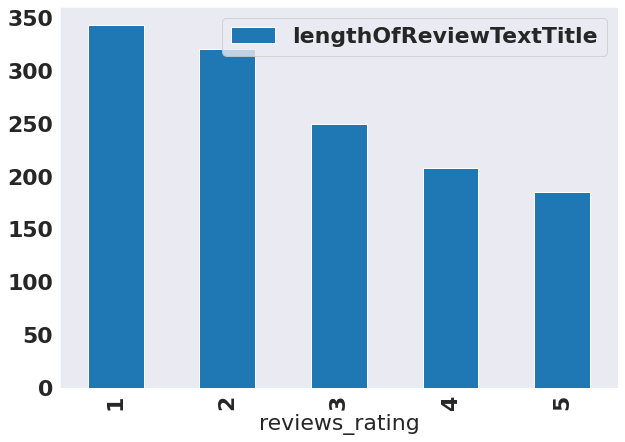

In [81]:
# Bivariate analysis to check if review text length, and review rating are related
pd.pivot_table(data=productReviews,values='lengthOfReviewTextTitle',index=['reviews_rating'],aggfunc='mean').plot(kind='bar',figsize=(10,7))

#### <font color='magenta'><i>We see as rating is lower, The average text length of the review text title is more

In [82]:
productReviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   brand                    30000 non-null  object 
 1   categories               30000 non-null  object 
 2   name                     30000 non-null  object 
 3   reviews_doRecommend      30000 non-null  bool   
 4   reviews_rating           30000 non-null  int64  
 5   reviews_username         30000 non-null  object 
 6   user_sentiment           30000 non-null  int64  
 7   reviews_age              30000 non-null  float64
 8   reviews_year             29946 non-null  float64
 9   reviews_month            29946 non-null  float64
 10  reviews_text_title       30000 non-null  object 
 11  lengthOfReviewTextTitle  30000 non-null  int64  
dtypes: bool(1), float64(3), int64(3), object(5)
memory usage: 2.5+ MB


#### <font color='magenta'><i>checking User Sentiment column , if it is as per User review and recommendation column. As we will be using User Sentiment Column to evalute our model

In [83]:
userSentimentBasedOnRating=pd.pivot_table(data=productReviews,values='reviews_username',columns='reviews_rating',index=['user_sentiment','reviews_doRecommend'],aggfunc='count')
userSentimentBasedOnRating

reviews_rating                          1      2       3       4        5
user_sentiment reviews_doRecommend                                       
0              False               597.00 140.00     nan     nan      nan
               True                   nan    nan  220.00  550.00  1860.00
1              False               787.00 280.00     nan     nan      nan
               True                   nan    nan 1125.00 5470.00 18971.00

<AxesSubplot:xlabel='user_sentiment,reviews_doRecommend'>

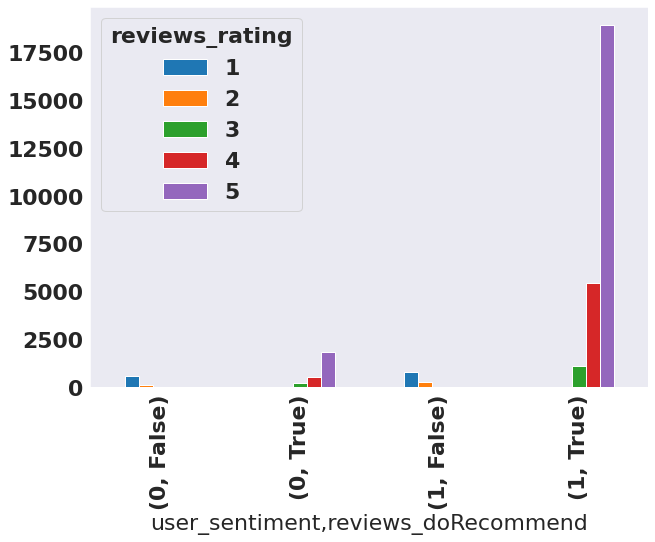

In [84]:
userSentimentBasedOnRating.plot(kind='bar',figsize=(10,7))

#### <font color='magenta'><i>So for few user Sentiment are positve though they have given less rating and also do not recommend (Positive, False) in the above graph. And few it is negative though reviews rating is 3,4 and 5 and also user recommend the product (Negative, True) . we see who has rated 1,2 and Sentiment positive, they did not recommend the product. So those User Sentiment values should be negative. Similarly few users whp given 3,4,5 rating and also recommends the product having User Sentiment as Negative. So there user Sentiment values should be positive. Will check later if before Model evaluation, need to change this column to match with correct prediction

#### <font color='magenta'><i>So Now creating another data frame without those Error User_sentiment records based on if User-Sentiment is not appropriate based on User_Rating and reviews_doRecommend column

In [86]:
PRWithoutErrSentimentRecords=productReviews[((productReviews['user_sentiment']==0 ) & (productReviews['reviews_rating']<=3 ) & (productReviews['reviews_doRecommend']==False ) ) 
| ((productReviews['user_sentiment']==1 ) & (productReviews['reviews_rating']>=3 ) & (productReviews['reviews_doRecommend']==True ) )]

In [87]:
# dataframe without the records for which User Sentiment value does not match based on User_Rating and reviews_doRecommend
PRWithoutErrSentimentRecords.shape

(26303, 12)

In [88]:
# So in this data frame we have all records having User_sentiment correct values as per reviews_rating and reviews_doRecommend
pd.pivot_table(data=PRWithoutErrSentimentRecords,values='reviews_username',columns='reviews_rating',index=['user_sentiment','reviews_doRecommend'],aggfunc='count')

reviews_rating                          1      2       3       4        5
user_sentiment reviews_doRecommend                                       
0              False               597.00 140.00     nan     nan      nan
1              True                   nan    nan 1125.00 5470.00 18971.00

<AxesSubplot:>

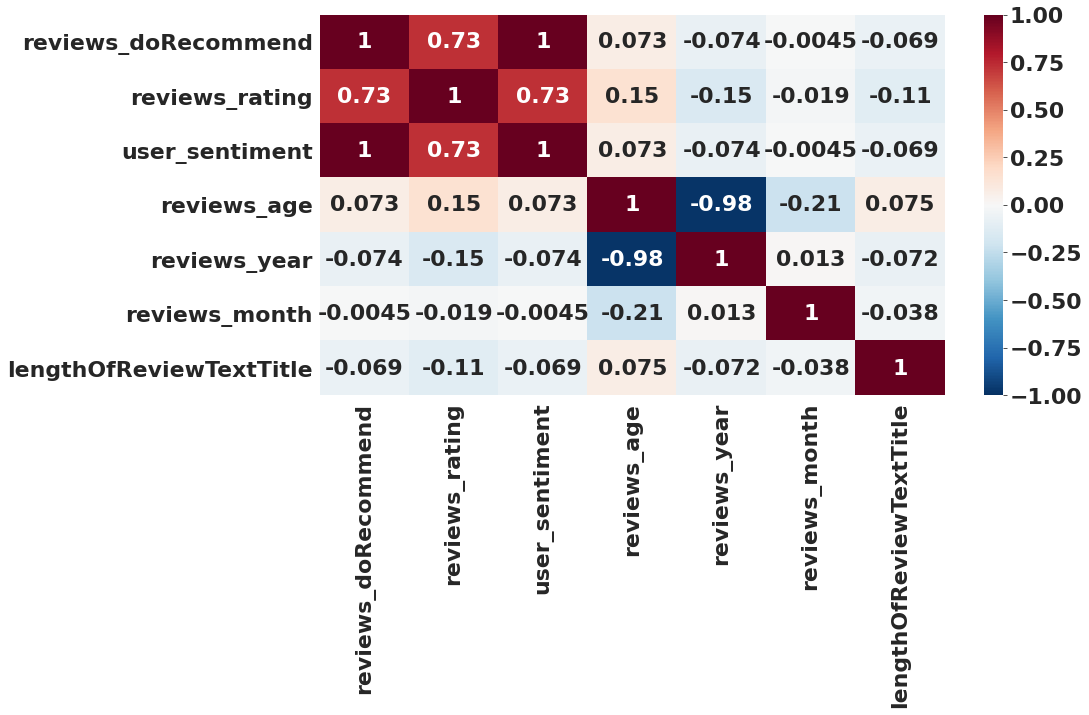

In [89]:
# plot heatmap  to get exact correlation value and how they are correlated for different caregorical ordinal variables after removal of rows 
plt.figure(figsize = (14,7)) 
sns.heatmap(PRWithoutErrSentimentRecords.corr(),annot = True,linewidths=0,vmin=-1,cmap="RdBu_r")

#### <font color='magenta'><i>So after removing the rows for which user_sentiment is not correct based on reviews_rating and reviews_doRecommend column. Corelation betweeb reviews rating and user sentiment increased from 0.22 to 0.73. So review rating and User Sentiment is highly corelated.

In [90]:
(PRWithoutErrSentimentRecords['user_sentiment'].value_counts()/PRWithoutErrSentimentRecords['user_sentiment'].count())*100

1   97.20
0    2.80
Name: user_sentiment, dtype: float64

### So after removing incorrect User Sentiment records based on Reviews Rating and User Recommendation, The total Negative Sentiment Records % coming down to 2.8 % from 11.22%. So we can not loose those records. But to train and Predict properly, we will correct User Sentiment value for those records.So we will make 'User_sentiment' value=1 for which (productReviews['user_sentiment']==0 ) & (productReviews['reviews_rating']>=3 ) & (productReviews['reviews_doRecommend']==True )  and also will make 'User_Sentiment' value=0 for which (productReviews['user_sentiment']==1 ) & (productReviews['reviews_rating']<=3 ) & (productReviews['reviews_doRecommend']==False ) . This way we will only correct the User-Sentiment value in main data frame (productReviews) only for (30000-26303)= 3697 records, which is indicated incorrect.

In [91]:
# Data Frame with all records
PRCorrectedErrSentimentRecords=productReviews.copy()
PRCorrectedErrSentimentRecords.shape

(30000, 12)

In [92]:
PRCorrectedErrSentimentRecords[((productReviews['user_sentiment']==0 ) & (productReviews['reviews_rating']>=3 ) & (productReviews['reviews_doRecommend']==True ) )].head(3)

brand                                                                                                                     categories                                               name  reviews_doRecommend  reviews_rating  reviews_username  user_sentiment  reviews_age  reviews_year  reviews_month                                                                                                                                     reviews_text_title  lengthOfReviewTextTitle
19        K-Y                                          Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants                   K-Y Love Sensuality Pleasure Gel                 True               3        browns fan               0      2018.00       2016.00           1.00  It was my first time using k-y. It didn't do anything in my opinion it felt like every time we did anything. Then again was my first time so proba...                      186
42  Johnson's  Personal Care,Baby Care,Baby Bubble Bath,Baby,Bath & Potty,Toiletries,Bubble Bath,Baby Bath,Bath & Body,Body Wash & Cleansers          Johnson's Baby Bubble Bath and Wash, 15oz                 True               3    gardenbunny318               0      2446.00       2014.00          11.00  You would think it's convenient to have bubble bath and wash in the same container, but it just means you buy twice the amount... My son loves the...                      197
83       Olay             Personal Care,Skin Care,Anti-Aging,Beauty,Face Moisturizers,Facial Moisturizers,Moisturizers,Creams & Moisturizers  Olay Regenerist Deep Hydration Regenerating Cream                 True               3  preacherjackson1               0      1807.00       2016.00           8.00  I would recommend this product to those who don't have the money to spend on expensive lotions daily facial products. As we all know older we get ...                      321

In [93]:
PRCorrectedErrSentimentRecords[((productReviews['user_sentiment']==0 ) & (productReviews['reviews_rating']>=3 ) & (productReviews['reviews_doRecommend']==True ) )]['user_sentiment'].count()

2630

### So the above 2630 records should have user_sentiment=1 based on Reviews rating and user recommend the product.We will correct these 2630 Records.

In [94]:
PRCorrectedErrSentimentRecords[((productReviews['user_sentiment']==0 ) & (productReviews['reviews_rating']>=3 ) & (productReviews['reviews_doRecommend']==True ) )]['user_sentiment']=1

In [95]:
PRCorrectedErrSentimentRecords[((productReviews['user_sentiment']==1 ) & (productReviews['reviews_rating']<=3 ) & (productReviews['reviews_doRecommend']==False ) )]['user_sentiment'].count()

1067

### So the above 1067 records should have user_sentiment=0 based on Reviews rating and user recommend the product.We will correct these 1067 Records.

In [96]:
PRCorrectedErrSentimentRecords[((productReviews['user_sentiment']==1 ) & (productReviews['reviews_rating']<=3 ) & (productReviews['reviews_doRecommend']==False ) )]['user_sentiment']=0

### So now we have 3 data frame. productReviews ( Without any correction of User Sentiment Records based on review rating and User product recommendation flag) , PRWithoutErrSentimentRecords ( Data frame without those rows having user-sentiment not as per review rating and User product recommendation flag), PRCorrectedErrSentimentRecords ( Data frame with corrected values only for those records where user-sentiment was not as per review rating and User product recommendation flag)

In [97]:
(PRCorrectedErrSentimentRecords['user_sentiment'].value_counts()/PRCorrectedErrSentimentRecords['user_sentiment'].count())*100

1   88.78
0   11.22
Name: user_sentiment, dtype: float64

### So in the corrected data frame containing updated User Sentiment values for 3697 records, also having 11.22% negative sentiment. So there is a class imbalance problem but it is same % with the original productReviews data frame.

In [98]:
#After this we do not need reviews_year, reviews_month,reviews_doRecommend,reviews_age,brand,categories,name,lengthOfReviewTextTitle,reviews_username for out sentiment analysis
# Dropping reviews_doRecommend column. 
productReviews.drop(['reviews_doRecommend','reviews_year','reviews_month','reviews_age','brand','categories','name','lengthOfReviewTextTitle','reviews_username'],axis=1,inplace=True)
PRWithoutErrSentimentRecords.drop(['reviews_doRecommend','reviews_year','reviews_month','reviews_age','brand','categories','name','lengthOfReviewTextTitle','reviews_username'],axis=1,inplace=True)
PRCorrectedErrSentimentRecords.drop(['reviews_doRecommend','reviews_year','reviews_month','reviews_age','brand','categories','name','lengthOfReviewTextTitle','reviews_username'],axis=1,inplace=True)

In [99]:
productReviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   reviews_rating      30000 non-null  int64 
 1   user_sentiment      30000 non-null  int64 
 2   reviews_text_title  30000 non-null  object
dtypes: int64(2), object(1)
memory usage: 703.2+ KB


In [100]:
PRWithoutErrSentimentRecords.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26303 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   reviews_rating      26303 non-null  int64 
 1   user_sentiment      26303 non-null  int64 
 2   reviews_text_title  26303 non-null  object
dtypes: int64(2), object(1)
memory usage: 822.0+ KB


In [101]:
PRCorrectedErrSentimentRecords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   reviews_rating      30000 non-null  int64 
 1   user_sentiment      30000 non-null  int64 
 2   reviews_text_title  30000 non-null  object
dtypes: int64(2), object(1)
memory usage: 703.2+ KB


## <font color='magenta'><i>Preprocessing of Reviews Text & Title column (reviews_text_title) for sentiment analysis

In [102]:
stopwords_custom=setStopWords()
for word in stopwords_custom:
    print(word,end=" | ")

before | any | i | which | won't | of | t | is | wasn't | theirs | further | up | s | until | mustn | wouldn't | yours | why | with | she's | needn | there | had | my | yourselves | very | themselves | isn't | shouldn | myself | when | was | now | ma | d | only | against | again | hadn | them | the | shouldn't | in | as | but | your | ours | at | by | doesn't | will | don't | other | we | to | below | such | his | herself | shan't | who | m | were | into | no | hasn | yourself | that | wasn | from | haven | this | mustn't | haven't | didn't | about | she | on | where | once | hasn't | between | its | aren | for | ain | here | you'd | most | few | should've | both | re | ve | didn | couldn | all | should | over | o | do | after | if | through | him | while | been | those | own | me | under | won | hadn't | just | you'll | has | each | than | weren | too | what | mightn't | doing | wouldn | they | aren't | am | during | our | some | a | he | are | mightn | these | himself | being | you'v

In [103]:
# Checking few negative comments having negative words
productReviews[(productReviews['user_sentiment']==0) & ((productReviews['reviews_text_title'].str.contains("NOT")) |(productReviews['reviews_text_title'].str.contains("N'T")) )][['reviews_text_title']].head(10)

reviews_text_title
40                                                                  I WON'T recommend this product to anyone It has a nasty smell that would get anyone sick
1238   HAVING A 3 MONTH OLD DAUGHTER MEANS I HAVE NO TIME AT ALL, BUT AFTER FINDING FINISH DISHWASHER TABLETS I HAVE REALISED I DON'T KNOW HAVE TO PRE-WA...
1245   I RECENTLY USED FINISH QUANTUM FOR THE FIRST TIME AFTER I FOUND SOME OTHER DISHWASHER TABLETS LEFT STREAKS ON MY GLASSES/PLATES AND I WOULD END UP...
1538   IT WAS SUPPOSE TO BE A 2DISC ITEM,,,THERE WAS ONLY ONE DISC IN THE CASE,AND THE CASE ONLY HAD A SPOT FOR ONE DVD.NOT 2! SO THEY COULD NOT HAVE PUT...
1797   Would ABSOLUTELY NOT recommend. We could only take 15 minutes of it and had to stop. Definitely a movie for our son in college. If I could return,...
3379   I have been using the Pantene Expert Pro-V AgeDefy Conditioner for a couple of week on my short white hair. Never been able to use other condition...
4152                                                   On sale because you cannot push it in plush carpet. Even an employee said so. DO NOT BUY!! Don"t Buy!
4531   Ordered before reading the reviews. I bought this specifically because it said Ultraviolet Copy. Wanted it for my UV collection. You only get one ...
6269   I had to throw out all my Hormel Chili. Some of us don't eat pork for reasons other than health and this was always in our food stock. Very sad th...
16603  I came to the website to email Burt's Bees about Cocoa...to ask whether there was any chance it might be brought back and also to find out what sh...

### <font color='orange'><i>So we see some negative key words are very important for review_text_title . without those key word, review text title will present as Positive sentiment. So from Stop Words we will remove those negative keywords, so that it does not get removed

In [104]:
# checking the stop words
stopwords_custom = [ word for word in stopwords_custom if 'n\'t' not in word and 'not' not in word and 'no' not in word ]
print(stopwords_custom)

['before', 'any', 'i', 'which', 'of', 't', 'is', 'theirs', 'further', 'up', 's', 'until', 'mustn', 'yours', 'why', 'with', "she's", 'needn', 'there', 'had', 'my', 'yourselves', 'very', 'themselves', 'shouldn', 'myself', 'when', 'was', 'ma', 'd', 'only', 'against', 'again', 'hadn', 'them', 'the', 'in', 'as', 'but', 'your', 'ours', 'at', 'by', 'will', 'other', 'we', 'to', 'below', 'such', 'his', 'herself', 'who', 'm', 'were', 'into', 'hasn', 'yourself', 'that', 'wasn', 'from', 'haven', 'this', 'about', 'she', 'on', 'where', 'once', 'between', 'its', 'aren', 'for', 'ain', 'here', "you'd", 'most', 'few', "should've", 'both', 're', 've', 'didn', 'couldn', 'all', 'should', 'over', 'o', 'do', 'after', 'if', 'through', 'him', 'while', 'been', 'those', 'own', 'me', 'under', 'won', 'just', "you'll", 'has', 'each', 'than', 'weren', 'too', 'what', 'doing', 'wouldn', 'they', 'am', 'during', 'our', 'some', 'a', 'he', 'are', 'mightn', 'these', 'himself', 'being', "you've", 'above', 'you', 'their', 'i

In [105]:
### Define a function to clean the text from noizy text data such as: 

    #trimming spacing
    #removing redudant punctuation
    #substituting text to a plain form e.g.: won't -> will not
    #remove stopwords except negative words
    #Lemmatize the Phrases

def text_clean(df,stopwords_custom):

    reviewTextTitleSeries = df.reviews_text_title.copy()
    reviewTextTitleSeries= reviewTextTitleSeries.apply(lambda x: x.lower())
    clean = re.compile('<.*?>') # Remove HTML tag
    reviewTextTitleSeries= reviewTextTitleSeries.apply(lambda x: re.sub(clean, '', x))

    reviewTextTitleSeries = reviewTextTitleSeries.apply(lambda x: re.sub(r"http\S+", "", x))  # removing URls
    reviewTextTitleSeries = reviewTextTitleSeries.apply(lambda x: re.sub(r"www\S+", "", x))


    reviewTextTitleSeries = reviewTextTitleSeries.str.replace('\\*', ' ', regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace('\\/', ' ', regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace('\\\\', ' ', regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace('-', ' ', regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r'/', ' ', regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r'``', ' ', regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r'`', ' ', regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"''", ' ', regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r",", ' ', regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"\.$", ' ', regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r":", ' ', regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"# ", '#', regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r";", ' ', regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"?", ' ', regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"=", ' ', regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace("...", ' ', regex=False)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace("..", ' ', regex=False)

    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r'LRB', ' ', regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r'RRB', ' ', regex=True)
    
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"[W|w]on't", 'will not', regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"[W|w]eren't", 'were not', regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"[W|w]asn't", 'was not', regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"[W|w]ouldn't", 'would not', regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"[D|d]oesn't", 'does not', regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"[I|i]sn't", 'is not', regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"[C|c]ouldn't", 'could not', regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"[D|d]idn't", 'did not', regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"[H|h]asn't", 'has not', regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"[H|h]aven't", 'have not', regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"[D|d]on't", 'do not', regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"[A|a]in't", "not", regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"[N|n]eedn't", "need not", regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"[A|a]ren't", "are not", regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"[S|s]houldn't", "should not", regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"[H|h]adn't", "had not", regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"[C|c]an't", "can not", regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"[M|m]ightn't", "might not", regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"[M|m]ustn't", "must not", regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"[S|s]han't", "shall not", regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"[N|n]t", "not", regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"[W|w]o n't", 'will not', regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"[W|w]ere n't", 'were not', regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"[W|w]as n't", 'was not', regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"[W|w]ould n't", 'would not', regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"[D|d]oes n't", 'does not', regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"[I|i]s n't", 'is not', regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"[C|c]ould n't", 'could not', regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"[D|d]id n't", 'did not', regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"[H|h]as n't", 'has not', regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"[H|h]ave n't", 'have not', regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"[D|d]o n't", 'do not', regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"[A|a]i n't", "not", regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"[N|n]eed n't", "need not", regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"[A|a]re n't", "are not", regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"[S|s]hould n't", "should not", regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"[H|h]ad n't", "had not", regex=True)
    
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"ain", "are not", regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"doesn", "does not", regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"hasn", "has not", regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"didn", "did not", regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"mightn", "might not", regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"shouldn", "should not", regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"hadn", "had not", regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"wasn", "was not", regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"wouldn", "would not", regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"mustn", "must not", regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"needn", "need not", regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"weren", "were not", regex=True)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r"shan", "shall not", regex=True)

    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(" 's", " ", regex=False)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace("'s", "", regex=False)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace("'ve", "have", regex=False)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace("'d", "would", regex=False)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace("'ll", "will", regex=False)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace("'m", "am", regex=False)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace("'n", "and", regex=False)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace("'re", "are", regex=False)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace("'til", "until", regex=False)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(" ' ", " ", regex=False)
    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(" '", " ", regex=False)

    reviewTextTitleSeries = reviewTextTitleSeries.str.replace(r'[ ]{2,}', ' ', regex=True)
    
    # Remove Stopwords and also lemmatize the phrases
    lem=WordNetLemmatizer()
    reviewTextTitleSeries=reviewTextTitleSeries.apply(word_tokenize)
    reviewTextTitleSeries=reviewTextTitleSeries.apply(lambda x: ' '.join(([lem.lemmatize(w, pos='v') for w in x if w not in stopwords_custom])))

    return reviewTextTitleSeries

In [108]:
# Checking how Text Clean is working or not. Checking Wouldn't gettig changed to Would not and then would is removed as part of Stop word custom (keeping negative word)
pd.set_option('display.max_colwidth', 200)
data=["I WON'T recommend this product to anyone It has a nasty smell that would get anyone sick. they ain good"]
df = pd.DataFrame(data, columns = ['reviews_text_title'])
print(text_clean(df,stopwords_custom))

0    not recommend product anyone nasty smell would get anyone sick . not good
Name: reviews_text_title, dtype: object


In [109]:
pd.set_option('display.max_colwidth', 500)
data=["I used this on my 2 boys on the 4th of July, ages 5 9. We have a huge block party with water balloons, swimming, playing in sprinklers. The boys were in their suits all day i re-applied several times through out the day, each time I put it on the boys, they were wet. Well at the end of the day, they were also very burned! I used a coppertone on my daughter and she did not get burned at all. I have been telling all my friends NOT to buy this I would never buy it again."]
df = pd.DataFrame(data, columns = ['reviews_text_title'])
print(text_clean(df,stopwords_custom))

0    use 2 boys 4th july age 5 9. huge block party water balloon swim play sprinklers . boys suit day apply several time day time put boys wet . well end day also burn ! use coppertone daughter not get burn . tell friends not buy would never buy agare not
Name: reviews_text_title, dtype: object


In [110]:
# Checking text Clean function removing URL properly
pd.set_option('display.max_colwidth', 500)
data=["I purchaed 12443842 for 3.28 and 25483701 for 6.37 - the formulas are exactly the same but the prices are drastically different! http://www.walmart.com/ip/Clorox-Disinfecting-Bathroom-Cleaner-30-Fl-Oz/12443842 http://www.walmart.com/ip/Clorox-Company-COX16930-Clorox-Disinfecting-Bathroom-Cleaner-30-oz/25483701 each bottle reads: Ative Ingredients: n-Alkyl (60 C14, 30 C16, 5 C12, 5 C18) 0.1375 dimethylbenzyl ammonium chloride n-Alkyl (68 C12, 32 C14) 0.1375 dimethyl ethlbenzyl ammonium choride 99.7250 other ingredients 100.0000 total"]
df = pd.DataFrame(data, columns = ['reviews_text_title'])
print(text_clean(df,stopwords_custom))

0    purchaed 12443842 3.28 25483701 6.37 formulas exactly price drastically differenot ! bottle read ative ingredienots n alkyl ( 60 c14 30 c16 5 c12 5 c18 ) 0.1375 dimethylbenzyl ammonium chloride n alkyl ( 68 c12 32 c14 ) 0.1375 dimethyl ethlbenzyl ammonium choride 99.7250 ingredienots 100.0000 total
Name: reviews_text_title, dtype: object


In [111]:
import time
start_time=time.time()
productReviews['reviews_text_title']=text_clean(productReviews,stopwords_custom)
print('Elapsed time for review preprocessing : ',((time.time()-start_time)/60),' in minutes')

Elapsed time for review preprocessing :  0.2583913008371989  in minutes


In [112]:
import time
start_time=time.time()
PRWithoutErrSentimentRecords['reviews_text_title']=text_clean(PRWithoutErrSentimentRecords,stopwords_custom)
print('Elapsed time for review preprocessing : ',((time.time()-start_time)/60),' in minutes')

Elapsed time for review preprocessing :  0.22007078329722088  in minutes


In [113]:
import time
start_time=time.time()
PRCorrectedErrSentimentRecords['reviews_text_title']=text_clean(PRCorrectedErrSentimentRecords,stopwords_custom)
print('Elapsed time for review preprocessing : ',((time.time()-start_time)/60),' in minutes')

Elapsed time for review preprocessing :  0.254669447739919  in minutes


In [114]:
# Checking negative comments if changed
pd.set_option('display.max_colwidth', 500)
productReviews[(productReviews['user_sentiment']==0) & ((productReviews['reviews_text_title'].str.contains("not")))][['reviews_text_title']]

reviews_text_title
3      read review look buy one couple lubricanots ultimately disappoinoted not even live review read . starters neither boyfriend nor could notice sort enhance captivate ' sensation . notice however messy consistency reminiscenot liquid vaseline . difficult clean not pleasanot especially since lack captivate ' sensation expect . iam disappoinoted pay much lube not use agare not could use normal personal lubricanot 1 ) less money 2 ) less mess . disappoinoted
4                                                                                                                                                                                                                                                                                                                                                                          husband buy gel us . gel cause irritation felt like burn skin . would not recommend gel . irritation
5                                                                                                                                                                                                                                                                                                         boyfriend buy spice things bedroom highly disappoinoted product . buy one absolutely love ky mine think would similar affect absolutely nothing . not buy . not worth
6                                                                                                                                                                                                                                                                                                                            buy earlier today excite check . base product description expect something like regular ky. fan expect leave little disappoinoted . disappoinoting
7                                                                                                                                                                                                                                                                                                                                      buy product husband try not impress . no tingle warm . leave us sticky . use ky products past ( love ky ) one disappoinoting . not happy
...                                                                                                                                                                                                                                                                                                                                                                                                                                                                         ...
29633                                                                                                                                                                                                                                                                        conditioner not heavy not light good . also not make crazy volume oily day . use scalp not worry annoy . receive product free exchange review review collect part promotion . soft ! soft ! soft !
29818                                                                                                                                                                                                                                                          receive complimenotary sample product work well hair ! thick hair root always get oily end dry leave hair cleanest felt long time . def recommend family friends ! review collect part promotion . great product
29855                                                                                                                                                                                                                                                                        

### <font color='orange'><i>Defining Common function to get bag of words , then top 20 most common words. Find TF-IDF value and get top 20 words having top TF-IDF score

In [115]:
def bagofWordsFindTop20Words(df):
    count = CountVectorizer(min_df=0.005,ngram_range=(1,2))
    count.fit(df['reviews_text_title'])
    print("Length of Vocabulary is")
    print(len(count.vocabulary_))
    #Getting Bag of Words
    bag_of_words = count.transform(productReviews['reviews_text_title'])
    # Top 20 terms
    occ = np.asarray(bag_of_words.sum(axis=0)).ravel().tolist()
    counts_df = pd.DataFrame({'term': count.get_feature_names(), 'occurrences': occ})
    count_top_20 = counts_df.sort_values(by='occurrences', ascending=False).head(20)
    # plot top 20 keywords
    fig, axes= plt.subplots(nrows=1, ncols=1,figsize=(21,7))
    count_top_20.plot(ax=axes,kind='bar',x='term')
    plt.xticks(rotation=60)
    plt.title('Top 20 Most Common Words')
    plt.show()
    # use the TfidfTransformer to calculate the weights for each term
    transformer = TfidfTransformer()
    transformed_weights = transformer.fit_transform(bag_of_words)
    # check the top 20 most common terms by average ti-idf weight
    weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
    weights_df = pd.DataFrame({'term': count.get_feature_names(), 'weight': weights})
    weight_top_20= weights_df.sort_values(by='weight', ascending=False).head(20)
    # plot the top 20 most common terms by average ti-idf weight
    fig, axes= plt.subplots(nrows=1, ncols=1,figsize=(21,7))
    weight_top_20.plot(ax=axes,kind='bar',x='term')
    plt.xticks(rotation=60)
    plt.title('Top 20 Most Common Words By Average ti-idf Weight')
    plt.show()

### <font color='orange'><i>Find bag of words ,then top 20 most common words. Find TF-IDF value and get top 20 words having top TF-IDF score for productReviews Original data frame( Without any correction of User Sentiment Records based on review rating and User product recommendation flag)

Length of Vocabulary is
745


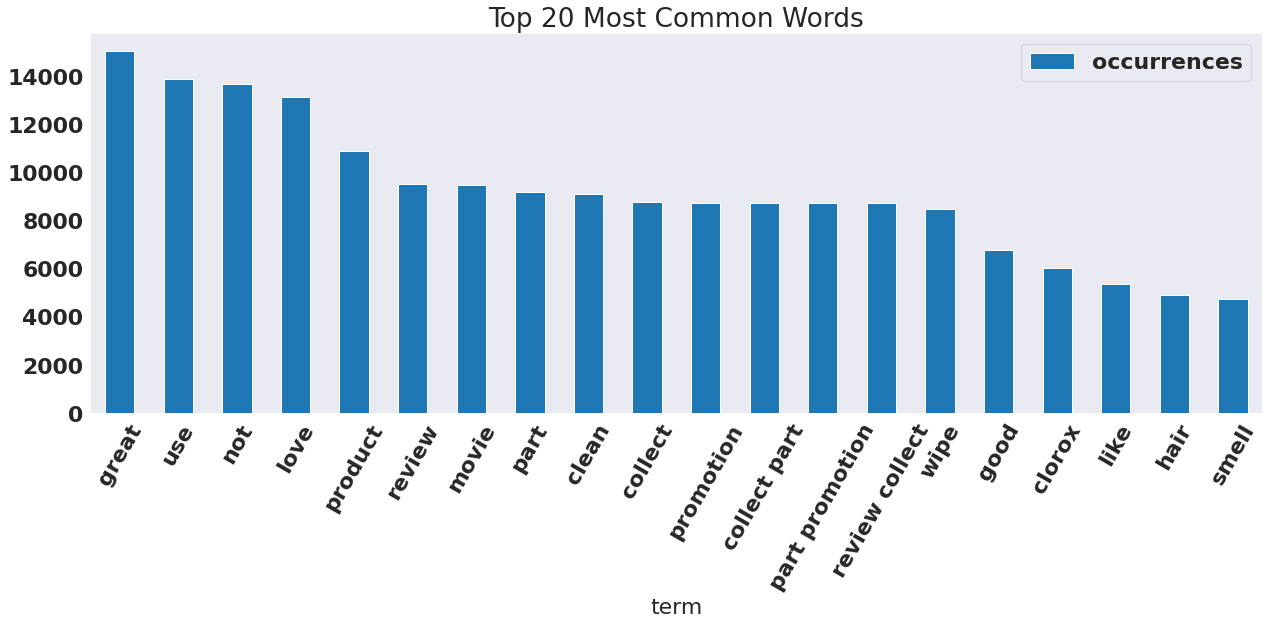

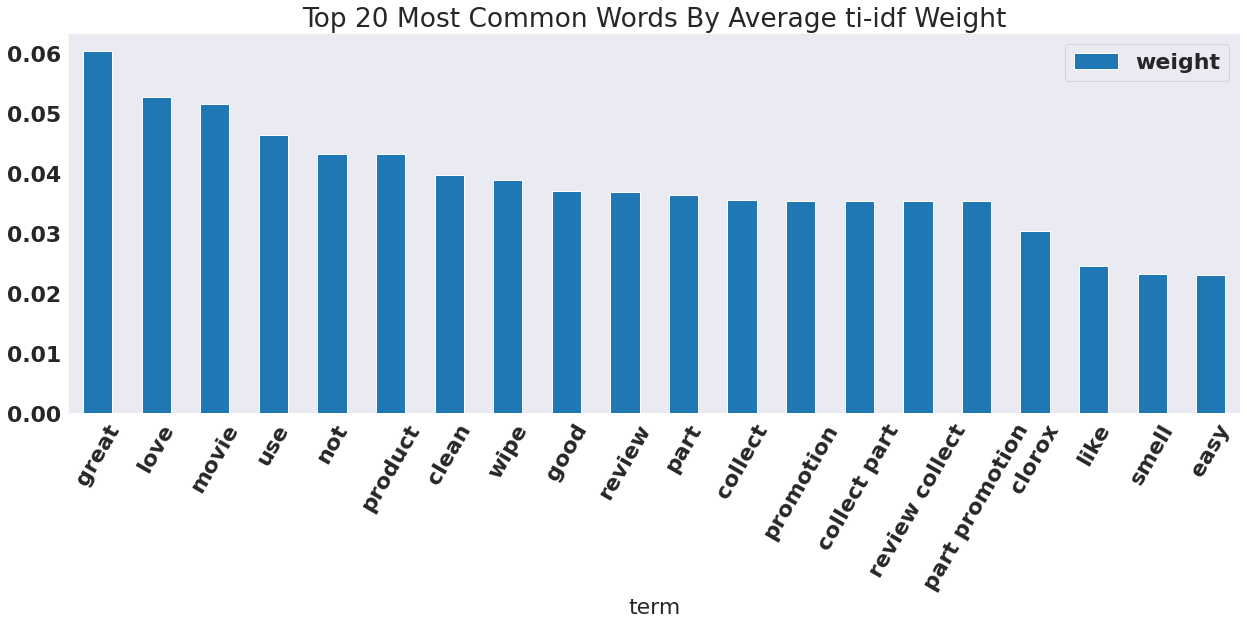

In [116]:
bagofWordsFindTop20Words(productReviews)

### <font color='orange'><i>Find bag of words ,then top 20 most common words. Find TF-IDF value and get top 20 words having top TF-IDF score for PRWithoutErrSentimentRecords ( Data frame without those rows having user-sentiment not as per review rating and User product recommendation flag) 

Length of Vocabulary is
725


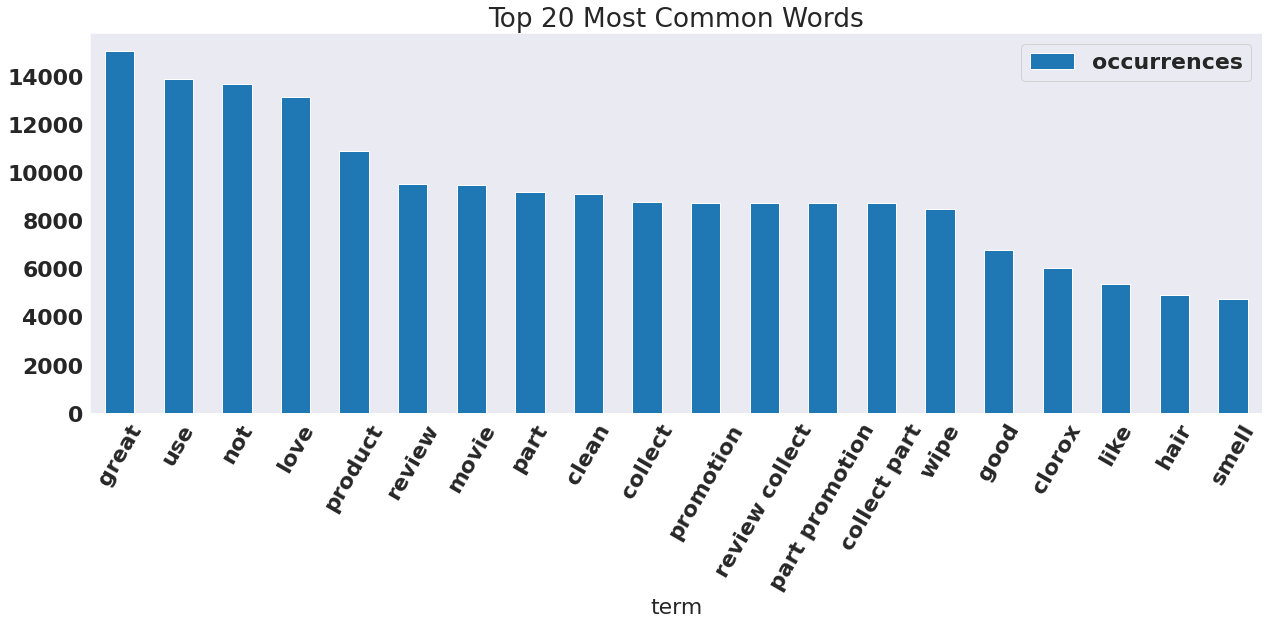

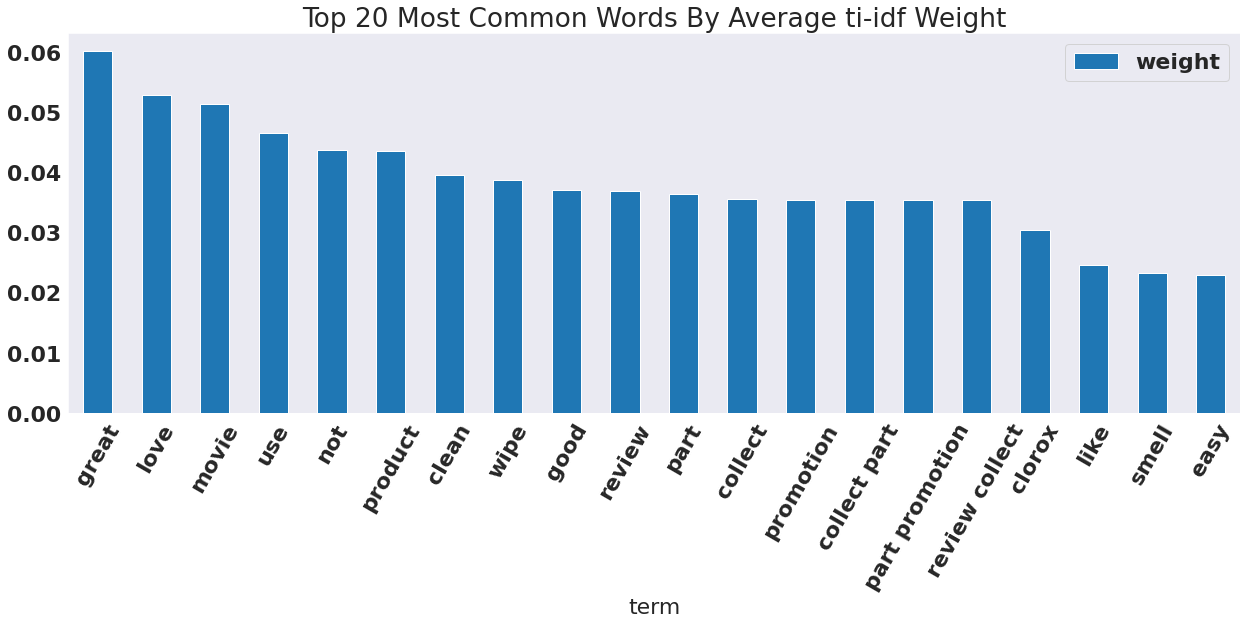

In [117]:
bagofWordsFindTop20Words(PRWithoutErrSentimentRecords)

### <font color='orange'><i>Find bag of words ,then top 20 most common words. Find TF-IDF value and get top 20 words having top TF-IDF score for PRCorrectedErrSentimentRecords ( Data frame with corrected values only for those records where user-sentiment was not as per review rating and User product recommendation flag)

Length of Vocabulary is
745


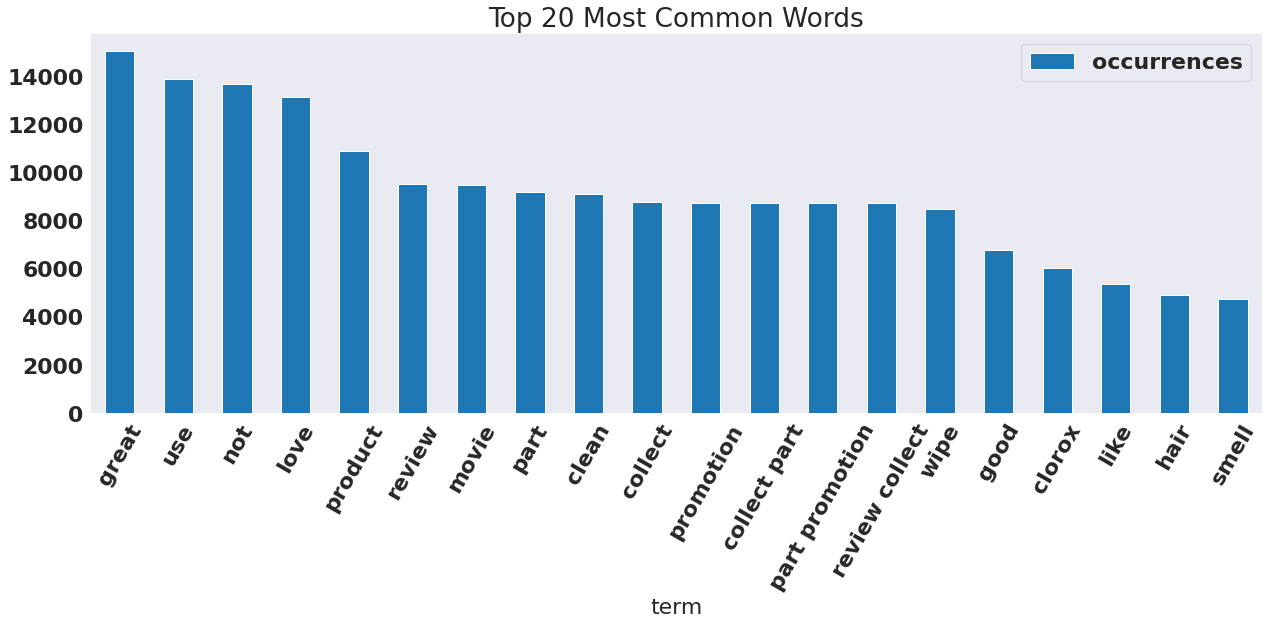

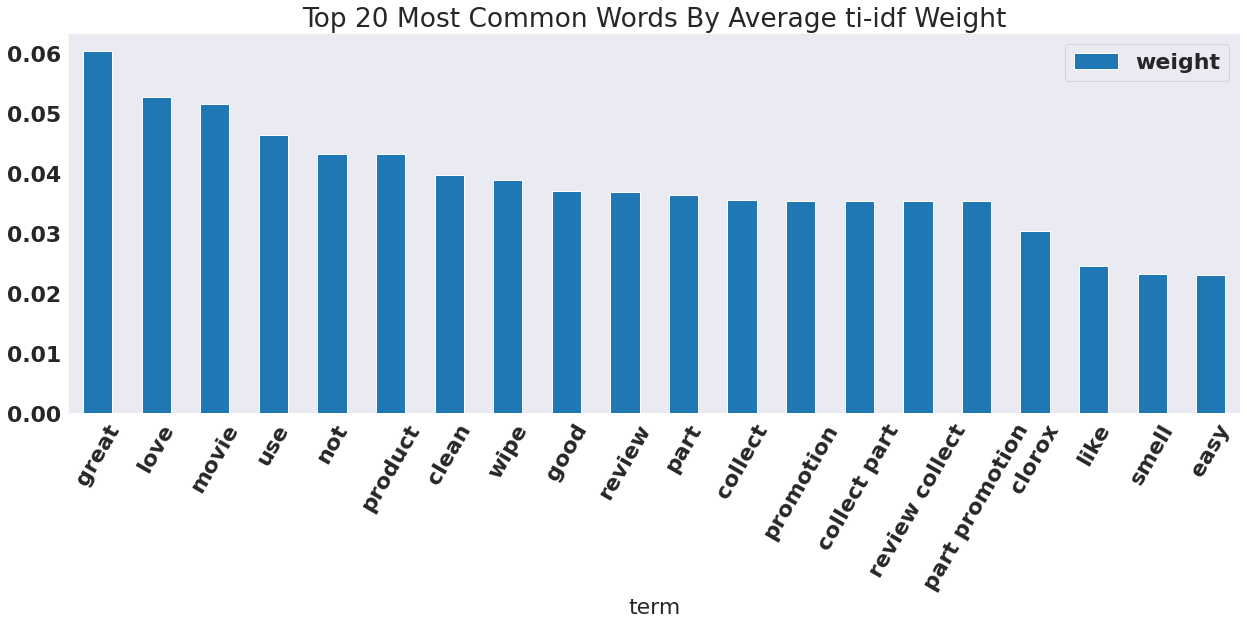

In [118]:
bagofWordsFindTop20Words(PRCorrectedErrSentimentRecords)

#### <font color='magenta'><i>Feature Extraction Common Function using TF-IDF vectorizer and do Train test Split.

In [123]:
def featureExtractionTrainTestSplit(df,saveVectorizer):
    vectorizer = TfidfVectorizer(min_df=0.005,ngram_range=(1,2))
    tfidfVector=vectorizer.fit_transform(df['reviews_text_title'])
    # we are trying to use 
    train_features = pd.DataFrame(tfidfVector.toarray(),columns=vectorizer.get_feature_names())
    #dummy_rating =pd.get_dummies(productReviews['reviews_rating'],drop_first=True) 
    train_features.reset_index(drop=True,inplace=True)
    #dummy_rating.reset_index(drop=True,inplace=True)
    #train_features= pd.concat([train_features,dummy_rating],axis=1)
    dfX = train_features
    dfy =df['user_sentiment'] 
    # train test split
    dfX_train, dfX_test, dfy_train, dfy_test = train_test_split(dfX, dfy, test_size=0.2, random_state=42)
    print("Dimension of X Training  Shape:", dfX_train.shape)
    print("Dimension of y Training Shape:", dfy_train.shape)
    print("Dimension of X Testing  Shape:", dfX_test.shape)
    print("Dimension of y Testing Shape:", dfy_test.shape)
    if(saveVectorizer):
        try:
            # save
            pickle.dump(vectorizer, open("wordVectorizer.pkl", "wb"))
            print("Model saved Successfully!")
        except Exception as e:
            print("There is some error in saving the mode",e)
    return(dfX_train, dfX_test, dfy_train, dfy_test)

#### <font color='magenta'><i>Feature Extraction for productReviews (Original Dataframe) and train test split. We will be predicting User Sentiment only based on Review Text and Title. So not considering reviews rating to predict User Sentiment.

In [689]:
# train test split
X_train, X_test, y_train, y_test = featureExtractionTrainTestSplit(productReviews)

Dimension of X Training  Shape: (24000, 745)
Dimension of y Training Shape: (24000,)
Dimension of X Testing  Shape: (6000, 745)
Dimension of y Testing Shape: (6000,)


In [690]:
X_train.head(2)

10   20   3d  able  absolutely  absolutely love  act  action  actors  actually  add  agare  agare not  age  ago  almost  along  already  also  also use  although  always  always use  amaze  amounot  another  anyone  anything  anywhere  apply  area  areas  around  around house  ask  away  awesome  awesome movie  awesome product  baby  back  back old  bad  bag  bathroom  bathroom kitchen  bathrooms   be  beautiful  become  begin  behind  believe  best  best buy  best product  better  big  bite  black  bleach  blu  blu ray  body  bottle  box  boys  brand  break  bring  bring back  brown  build  buy  canister  car  care  carpet  carry  cast   cd  chair  change  character  children  chip  classic  classroom  clay  clean  clean bathroom  clean disinfect  clean fresh  clean great  clean kitchen  clean mess  clean product  clean review  clean smell  clean up  clean well  clean wipe  cleaner  cleanup  clear  clorox  clorox disinfect  clorox products  clorox wipe  close  clothe  cocoa  \
21753 0.00 0.00 0.00  0.00        0.00             0.00 0.00    0.00    0.00      0.00 0.22   0.00       0.00 0.00 0.00    0.00   0.00     0.00  0.00      0.00      0.00    0.00        0.00   0.00     0.00     0.00    0.00      0.00      0.00   0.00  0.00   0.00    0.00          0.00 0.00  0.00     0.00           0.00             0.00  0.00  0.16      0.00 0.00 0.00      0.00              0.00       0.00 0.00       0.00    0.00   0.00    0.00     0.00  0.00      0.00          0.00    0.00 0.00  0.00   0.00    0.00 0.00     0.00  0.00    0.00 0.00  0.00   0.00   0.00   0.19        0.20   0.00   0.00 0.00      0.00 0.00  0.00    0.00   0.00  0.00 0.00   0.00    0.20       0.00      0.00  0.00     0.00       0.00  0.00   0.00            0.00             0.00         0.00         0.00           0.00        0.00           0.00          0.00         0.00      0.00        0.00        0.00     0.00     0.00   0.00    0.00              0.00             0.00         0.00   0.00    0.00   0.00   
251   0.00 0.00 0.00  0.00        0.00             0.00 0.00    0.00    0.00      0.00 0.00   0.00       0.00 0.00 0.00    0.00   0.00     0.00  0.00      0.00      0.00    0.00        0.00   0.00     0.00     0.00    0.00      0.00      0.00   0.00  0.00   0.00    0.00          0.00 0.00  0.00     0.28           0.00             0.00  0.00  0.00      0.00 0.00 0.00      0.00              0.00       0.00 0.00       0.00    0.00   0.00    0.00     0.00  0.00      0.00          0.00    0.00 0.00  0.00   0.00    0.00 0.00     0.00  0.00    0.00 0.00  0.00   0.00   0.00   0.00        0.00   0.00   0.00 0.00      0.00 0.00  0.00    0.00   0.00  0.00 0.00   0.00    0.00       0.00      0.00  0.00     0.00       0.00  0.00   0.00            0.00             0.00         0.00         0.00           0.00        0.00           0.00          0.00         0.00      0.00        0.00        0.00     0.00     0.00   0.00    0.00              0.00             0.00         0.00   0.00    0.00   0.00   

       cold  collect  collect part  collection  color  come  comedy  comfortable  compare  complare  completely  complimenotary  complimenotary test  condition  conditioner  conotare  conotare noter  conotinue  convenience  convenienot  convenienot use  cook  cool  copy  could  could not  counoter  counoter top  counoters  couple  cover  cream  curly  customer  cut  cute  daily  dark  daughter  day  days  deal  decenot  decide  deep  definitely  definitely recommend  delicious  difference  differenot  digital  disappoinoted  disinfect  disinfect review  disinfect wipe  disinfectanot  disney   do  dog  door  dry  dvd  ease  easier  easily  easy  easy clean  easy use  eat  effect  effective  either  else  end  enjoy  enjoy movie  enjoyable  enotertare  enotertare note  enotire  enough  especially  etc  even  ever  ever use  every  every day  every room  every time  everyday  everyone  everything  everywhere  evil  excellenot  excellenot product  excite  expect  expensive  experience  \
21753

#### <font color='magenta'><i>Feature Extraction for PRWithoutErrSentimentRecords (Updated data frame without the records where user-sentiment was wrong as per user Review rating and user Product recommendation)

In [691]:
# train test split
X_train_WithoutErrSentimentRecords, X_test_WithoutErrSentimentRecords, y_train_WithoutErrSentimentRecords, y_test_WithoutErrSentimentRecords = featureExtractionTrainTestSplit(PRWithoutErrSentimentRecords)

Dimension of X Training  Shape: (21042, 725)
Dimension of y Training Shape: (21042,)
Dimension of X Testing  Shape: (5261, 725)
Dimension of y Testing Shape: (5261,)


In [692]:
X_train_WithoutErrSentimentRecords.head(2)

10   3d  able  absolutely  absolutely love  act  action  actors  actually  add  agare  agare not  age  ago  almost  along  already  also  also use  although  always  amaze  amounot  another  anyone  anything  anywhere  apply  area  areas  around  around house  ask  away  awesome  awesome movie  awesome product  baby  back  bad  bag  bathroom  bathroom kitchen  bathrooms   be  beautiful  begin  behind  believe  best  best buy  best product  better  big  bite  black  bleach  blu  blu ray  body  bottle  box  boys  brand  break  bring  bring back  brown  build  buy  canister  car  care  carpet  carry  cast   cd  chair  change  character  children  chip  classic  classroom  clay  clean  clean bathroom  clean disinfect  clean fresh  clean great  clean kitchen  clean mess  clean product  clean review  clean smell  clean up  clean use  clean well  clean wipe  cleaner  cleanup  clear  clorox  clorox disinfect  clorox products  clorox wipe  close  clothe  cocoa  cold  collect  \
21216 0.00 0.23  0.00        0.00             0.00 0.00    0.18    0.00      0.22 0.00   0.00       0.00 0.00 0.00    0.00   0.00     0.00  0.00      0.00      0.00    0.00   0.00     0.00     0.00    0.00      0.00      0.00   0.00  0.00   0.00    0.00          0.00 0.00  0.00     0.00           0.00             0.00  0.00  0.00 0.00 0.00      0.00              0.00       0.00 0.00       0.00   0.00    0.00     0.00  0.00      0.00          0.00    0.00 0.00  0.00   0.00    0.00 0.00     0.00  0.00    0.00 0.00  0.00   0.00   0.00   0.00        0.00   0.00   0.00 0.00      0.00 0.00  0.00    0.00   0.00  0.00 0.00   0.00    0.00       0.22      0.00  0.00     0.00       0.00  0.00   0.00            0.00             0.00         0.00         0.00           0.00        0.00           0.00          0.00         0.00      0.00       0.00        0.00        0.00     0.00     0.00   0.00    0.00              0.00             0.00         0.00   0.00    0.00   0.00  0.00     0.00   
18825 0.00 0.00  0.00        0.00             0.00 0.00    0.00    0.00      0.00 0.00   0.00       0.00 0.00 0.00    0.00   0.00     0.00  0.00      0.00      0.00    0.00   0.00     0.00     0.00    0.00      0.00      0.00   0.00  0.00   0.00    0.00          0.00 0.00  0.00     0.00           0.00             0.00  0.00  0.16 0.00 0.00      0.00              0.00       0.00 0.00       0.00   0.00    0.00     0.00  0.00      0.00          0.00    0.00 0.00  0.00   0.00    0.00 0.00     0.00  0.00    0.00 0.00  0.00   0.00   0.00   0.00        0.00   0.00   0.00 0.00      0.00 0.00  0.00    0.00   0.00  0.00 0.00   0.00    0.38       0.00      0.00  0.00     0.00       0.00  0.00   0.00            0.00             0.00         0.00         0.00           0.00        0.00           0.00          0.00         0.00      0.00       0.00        0.00        0.00     0.00     0.00   0.00    0.00              0.00             0.00         0.00   0.00    0.00   0.00  0.00     0.00   

       collect part  collection  color  come  comedy  comfortable  compare  complare  complimenotary  complimenotary test  condition  conditioner  conotare  conotare noter  conotinue  convenience  convenienot  convenienot use  cook  cool  copy  could  could not  counoter  counoter top  counoters  couple  cover  cream  cut  cute  daily  dark  daughter  day  days  deal  decenot  decide  deep  definitely  definitely recommend  delicious  difference  differenot  disappoinoted  disinfect  disinfect review  disinfect wipe  disinfectanot  disney   do  dog  door  dry  dvd  ease  easier  easily  easy  easy clean  easy use  eat  effect  effective  else  end  enjoy  enjoy movie  enjoyable  enotertare  enotertare note  enotire  enough  especially  etc  even  ever  ever use  every  every day  every room  every time  everyday  everyone  everything  everywhere  excellenot  excellenot product  excite  expect  experience  extra  extremely  face  fact  family  family movie  fan  fanotastic  far  fast  \
21216          0.00        0.0

#### <font color='magenta'><i>Feature Extraction for PRCorrectedErrSentimentRecords (Updated data frame with corrected user_sentiment value for records where user-sentiment was wrong as per user Review rating and user Product recommendation)

In [693]:
# train test split
X_train_CorrectedErrSentimentRecords, X_test_CorrectedErrSentimentRecords, y_train_CorrectedErrSentimentRecords, y_test_CorrectedErrSentimentRecords = featureExtractionTrainTestSplit(PRCorrectedErrSentimentRecords)

Dimension of X Training  Shape: (24000, 745)
Dimension of y Training Shape: (24000,)
Dimension of X Testing  Shape: (6000, 745)
Dimension of y Testing Shape: (6000,)


In [694]:
X_train_CorrectedErrSentimentRecords.head(2)

10   20   3d  able  absolutely  absolutely love  act  action  actors  actually  add  agare  agare not  age  ago  almost  along  already  also  also use  although  always  always use  amaze  amounot  another  anyone  anything  anywhere  apply  area  areas  around  around house  ask  away  awesome  awesome movie  awesome product  baby  back  back old  bad  bag  bathroom  bathroom kitchen  bathrooms   be  beautiful  become  begin  behind  believe  best  best buy  best product  better  big  bite  black  bleach  blu  blu ray  body  bottle  box  boys  brand  break  bring  bring back  brown  build  buy  canister  car  care  carpet  carry  cast   cd  chair  change  character  children  chip  classic  classroom  clay  clean  clean bathroom  clean disinfect  clean fresh  clean great  clean kitchen  clean mess  clean product  clean review  clean smell  clean up  clean well  clean wipe  cleaner  cleanup  clear  clorox  clorox disinfect  clorox products  clorox wipe  close  clothe  cocoa  \
21753 0.00 0.00 0.00  0.00        0.00             0.00 0.00    0.00    0.00      0.00 0.22   0.00       0.00 0.00 0.00    0.00   0.00     0.00  0.00      0.00      0.00    0.00        0.00   0.00     0.00     0.00    0.00      0.00      0.00   0.00  0.00   0.00    0.00          0.00 0.00  0.00     0.00           0.00             0.00  0.00  0.16      0.00 0.00 0.00      0.00              0.00       0.00 0.00       0.00    0.00   0.00    0.00     0.00  0.00      0.00          0.00    0.00 0.00  0.00   0.00    0.00 0.00     0.00  0.00    0.00 0.00  0.00   0.00   0.00   0.19        0.20   0.00   0.00 0.00      0.00 0.00  0.00    0.00   0.00  0.00 0.00   0.00    0.20       0.00      0.00  0.00     0.00       0.00  0.00   0.00            0.00             0.00         0.00         0.00           0.00        0.00           0.00          0.00         0.00      0.00        0.00        0.00     0.00     0.00   0.00    0.00              0.00             0.00         0.00   0.00    0.00   0.00   
251   0.00 0.00 0.00  0.00        0.00             0.00 0.00    0.00    0.00      0.00 0.00   0.00       0.00 0.00 0.00    0.00   0.00     0.00  0.00      0.00      0.00    0.00        0.00   0.00     0.00     0.00    0.00      0.00      0.00   0.00  0.00   0.00    0.00          0.00 0.00  0.00     0.28           0.00             0.00  0.00  0.00      0.00 0.00 0.00      0.00              0.00       0.00 0.00       0.00    0.00   0.00    0.00     0.00  0.00      0.00          0.00    0.00 0.00  0.00   0.00    0.00 0.00     0.00  0.00    0.00 0.00  0.00   0.00   0.00   0.00        0.00   0.00   0.00 0.00      0.00 0.00  0.00    0.00   0.00  0.00 0.00   0.00    0.00       0.00      0.00  0.00     0.00       0.00  0.00   0.00            0.00             0.00         0.00         0.00           0.00        0.00           0.00          0.00         0.00      0.00        0.00        0.00     0.00     0.00   0.00    0.00              0.00             0.00         0.00   0.00    0.00   0.00   

       cold  collect  collect part  collection  color  come  comedy  comfortable  compare  complare  completely  complimenotary  complimenotary test  condition  conditioner  conotare  conotare noter  conotinue  convenience  convenienot  convenienot use  cook  cool  copy  could  could not  counoter  counoter top  counoters  couple  cover  cream  curly  customer  cut  cute  daily  dark  daughter  day  days  deal  decenot  decide  deep  definitely  definitely recommend  delicious  difference  differenot  digital  disappoinoted  disinfect  disinfect review  disinfect wipe  disinfectanot  disney   do  dog  door  dry  dvd  ease  easier  easily  easy  easy clean  easy use  eat  effect  effective  either  else  end  enjoy  enjoy movie  enjoyable  enotertare  enotertare note  enotire  enough  especially  etc  even  ever  ever use  every  every day  every room  every time  everyday  everyone  everything  everywhere  evil  excellenot  excellenot product  excite  expect  expensive  experience  \
21753

#### <font color='magenta'><i>Model Building

#### <font color='magenta'><i>Defining Common method for Evaluating Model

In [695]:
def evaluateModel(model,dfX_test,dfy_test):
    # confusion_matrix
    print("confusion_matrix")
    skplt.metrics.plot_confusion_matrix(model.predict(dfX_test), dfy_test, normalize=True)
    plt.show()
    # classification report
    print("classification report")
    print(classification_report(model.predict(dfX_test), dfy_test))
    cm = confusion_matrix(dfy_test, model.predict(dfX_test))
    print('Accuracy is ', accuracy_score(dfy_test, model.predict(dfX_test)))
    print('Sensitivity is {}'.format(cm[1][1]/sum(cm[1])))
    print('Specificity is {}'.format(cm[0][0]/sum(cm[0])))

#### <font color='magenta'><i>Defining Common Naive Bayes function to use for all 3 different data frame

In [696]:
def applyNaiveBayesModel(dfX_train,dfy_train,dfX_test,dfy_test):
    # GridSearch
    naive_gird = {'alpha':[.1, 1, 5, 10, 50]}
    NBModel = MultinomialNB()
    NBModel=GridSearchCV(NBModel, naive_gird,scoring = "accuracy",cv = 5)
    NBModel.fit(dfX_train, dfy_train)
    print('best parameter:{}'.format(NBModel.best_params_),'best score: {}'.format(NBModel.best_score_))
    # fit the data with best model
    NBModel = MultinomialNB(alpha = list(NBModel.best_params_.values())[0])
    NBModel.fit(dfX_train, dfy_train)
    evaluateModel(NBModel,dfX_test,dfy_test)
    return(NBModel)

#### <font color='magenta'><i>Applying Naive Bayes for productReviews Original data frame( Without any correction of User Sentiment Records based on review rating and User product recommendation flag) )

best parameter:{'alpha': 10} best score: 0.8875
confusion_matrix


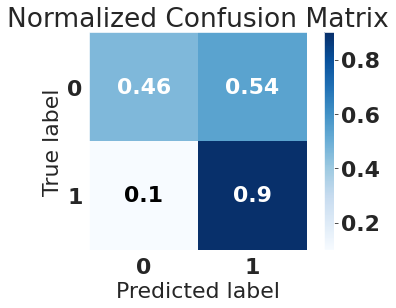

classification report
              precision    recall  f1-score   support

           0       0.05      0.46      0.09        71
           1       0.99      0.90      0.94      5929

    accuracy                           0.89      6000
   macro avg       0.52      0.68      0.52      6000
weighted avg       0.98      0.89      0.93      6000

Accuracy is  0.8906666666666667
Sensitivity is 0.9928958683866144
Specificity is 0.05069124423963134


In [697]:
NBModelAllData=applyNaiveBayesModel(X_train,y_train,X_test,y_test)

#### <font color='magenta'><i>Applying Naive Bayes for PRWithoutErrSentimentRecords ( Data frame without those rows having user-sentiment not as per review rating and User product recommendation flag) 

best parameter:{'alpha': 0.1} best score: 0.983366453110165
confusion_matrix


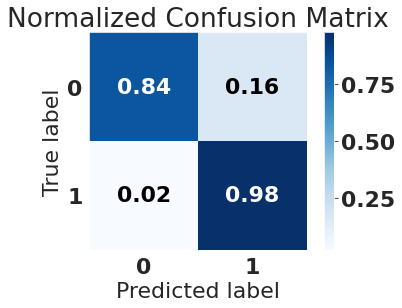

classification report
              precision    recall  f1-score   support

           0       0.45      0.84      0.58        82
           1       1.00      0.98      0.99      5179

    accuracy                           0.98      5261
   macro avg       0.72      0.91      0.79      5261
weighted avg       0.99      0.98      0.98      5261

Accuracy is  0.9811822847367421
Sensitivity is 0.9974539757148453
Specificity is 0.44516129032258067


In [698]:
NBModelWithoutErrSentimentRecords=applyNaiveBayesModel(X_train_WithoutErrSentimentRecords,y_train_WithoutErrSentimentRecords,X_test_WithoutErrSentimentRecords,y_test_WithoutErrSentimentRecords)

#### <font color='magenta'><i>Applying Naive Bayes for PRCorrectedErrSentimentRecords ( Data frame with corrected values only for those records where user-sentiment was not as per review rating and User product recommendation flag)

best parameter:{'alpha': 10} best score: 0.8875
confusion_matrix


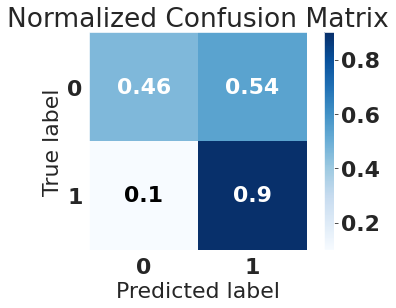

classification report
              precision    recall  f1-score   support

           0       0.05      0.46      0.09        71
           1       0.99      0.90      0.94      5929

    accuracy                           0.89      6000
   macro avg       0.52      0.68      0.52      6000
weighted avg       0.98      0.89      0.93      6000

Accuracy is  0.8906666666666667
Sensitivity is 0.9928958683866144
Specificity is 0.05069124423963134


In [699]:
NBModelCorrectedErrSentimentRecords=applyNaiveBayesModel(X_train_CorrectedErrSentimentRecords,y_train_CorrectedErrSentimentRecords,X_test_CorrectedErrSentimentRecords,y_test_CorrectedErrSentimentRecords)

#### <font color='magenta'>So for all data frame we have specificity value less . This is because we have class imbalance problem. We will use SMOTE library to fix class imbalance problem

In [700]:
from imblearn.over_sampling import SMOTE 

In [ ]:
def fixClassImbalance(dfX_tr,dfy_tr):
    # Taking Smote instance
    smote = SMOTE(random_state=1)
    # fitting the sample for Current train data set
    dfX_tr,dfy_tr = smote.fit_resample(dfX_tr,dfy_tr)
    # Printing shape for Train data set after class imbalance taken care using SMOTE
    print("Dimension of X_tr Shape:", dfX_tr.shape)
    print("Dimension of y_tr Shape:", dfy_tr.shape)

    print("Checking Class imbalance taken care using SMOTE . Now Imbalance in training data set is :",(dfy_tr != 0).sum()/(dfy_tr == 0).sum())
    return dfX_tr,dfy_tr

#### <font color='magenta'><i>Applying Naive Bayes for productReviews Original data frame with SMOTE( Without any correction of User Sentiment Records based on review rating and User product recommendation flag) )

Dimension of X_tr Shape: (42568, 745)
Dimension of y_tr Shape: (42568,)
Checking Class imbalance taken care using SMOTE . Now Imbalance in training data set is : 1.0
best parameter:{'alpha': 0.1} best score: 0.766937473594324
confusion_matrix


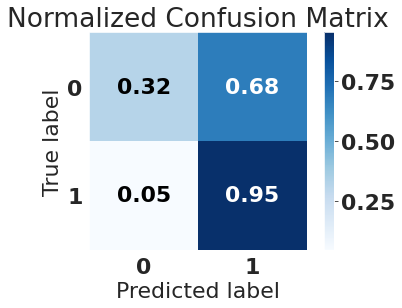

classification report
              precision    recall  f1-score   support

           0       0.67      0.32      0.44      1353
           1       0.83      0.95      0.89      4647

    accuracy                           0.81      6000
   macro avg       0.75      0.64      0.66      6000
weighted avg       0.79      0.81      0.79      6000

Accuracy is  0.8116666666666666
Sensitivity is 0.8287530379510188
Specificity is 0.6712749615975423


In [555]:
X_tr_SMOTE,y_tr_SMOTE = fixClassImbalance(X_train,y_train)
NBModelAllDataSMOTE=applyNaiveBayesModel(X_tr_SMOTE,y_tr_SMOTE,X_test,y_test)

#### <font color='magenta'><i>Applying Naive Bayes for PRWithoutErrSentimentRecords with SMOTE ( Data frame without those rows having user-sentiment not as per review rating and User product recommendation flag) 

Dimension of X_tr Shape: (40920, 725)
Dimension of y_tr Shape: (40920,)
Checking Class imbalance taken care using SMOTE . Now Imbalance in training data set is : 1.0
best parameter:{'alpha': 0.1} best score: 0.9394672531769306
confusion_matrix


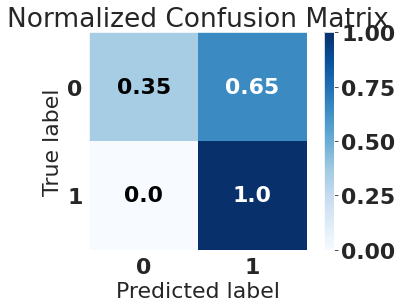

classification report
              precision    recall  f1-score   support

           0       0.86      0.35      0.50       383
           1       0.95      1.00      0.97      4878

    accuracy                           0.95      5261
   macro avg       0.91      0.67      0.74      5261
weighted avg       0.94      0.95      0.94      5261

Accuracy is  0.9486789583729329
Sensitivity is 0.9512338425381903
Specificity is 0.864516129032258


In [556]:
X_train_WithoutErrSentimentRecords_SMOTE,y_train_WithoutErrSentimentRecords_SMOTE = fixClassImbalance(X_train_WithoutErrSentimentRecords,y_train_WithoutErrSentimentRecords)
NBModelWithoutErrSentimentRecordsSMOTE=applyNaiveBayesModel(X_train_WithoutErrSentimentRecords_SMOTE,y_train_WithoutErrSentimentRecords_SMOTE,X_test_WithoutErrSentimentRecords,y_test_WithoutErrSentimentRecords)

#### <font color='magenta'><i>Applying Naive Bayes for PRCorrectedErrSentimentRecords with SMOTE ( Data frame with corrected values only for those records where user-sentiment was not as per review rating and User product recommendation flag)

Dimension of X_tr Shape: (42568, 745)
Dimension of y_tr Shape: (42568,)
Checking Class imbalance taken care using SMOTE . Now Imbalance in training data set is : 1.0
best parameter:{'alpha': 0.1} best score: 0.766937473594324
confusion_matrix


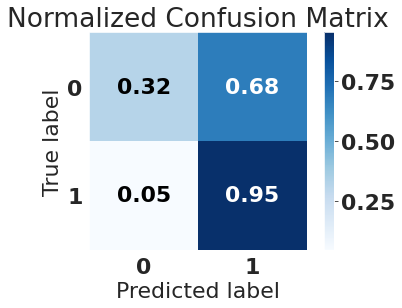

classification report
              precision    recall  f1-score   support

           0       0.67      0.32      0.44      1353
           1       0.83      0.95      0.89      4647

    accuracy                           0.81      6000
   macro avg       0.75      0.64      0.66      6000
weighted avg       0.79      0.81      0.79      6000

Accuracy is  0.8116666666666666
Sensitivity is 0.8287530379510188
Specificity is 0.6712749615975423


In [557]:
X_train_CorrectedErrSentimentRecords_SMOTE,y_train_CorrectedErrSentimentRecords_SMOTE = fixClassImbalance(X_train_CorrectedErrSentimentRecords,y_train_CorrectedErrSentimentRecords)
NBModelCorrectedErrSentimentRecordsSMOTE=applyNaiveBayesModel(X_train_CorrectedErrSentimentRecords_SMOTE,y_train_CorrectedErrSentimentRecords_SMOTE,X_test_CorrectedErrSentimentRecords,y_test_CorrectedErrSentimentRecords)

#### <font color='magenta'>Sensitivity of a classifier is the ratio between how much were correctly identified as positive to how much were actually positive.Sensitivity = TP / FN+TP
#### <font color='magenta'>Specificity of a classifier is the ratio between how much were correctly classified as negative to how much was actually negative.Specificity = TN/FP+TN
#### <font color='magenta'>Precision- How much were correctly classified as positive out of all positives.Precision = TP/TP+FP
#### <font color='magenta'>Recall - Recall and sensitivity are one and the same.Recall = TP / FN+TP
#### <font color='magenta'>f1-Score - The harmonic mean of precision and recall gives a score call f1 score which is a measure of performance of the model’s classification ability.F1 score = 2 * (precision * recall)/ (precision + recall).F1 score is considered a better indicator of the classifier’s performance than the regular accuracy measure.

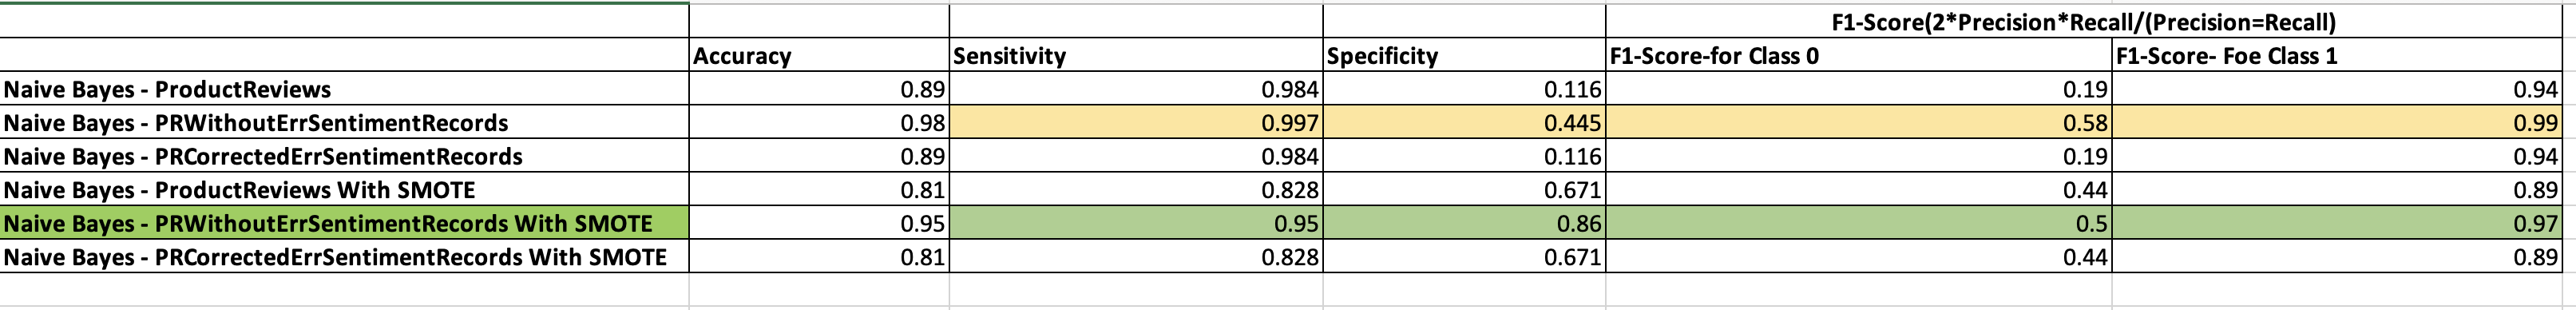

#### <font color='magenta'>So definitely if we have removed the records for which User_Sentiment is wrong respected to Review Rating and User Recommendation. F1 Score both class 0 (Negative)  and 1 ( positive) has increased.Also we see after using SMOTE to fix class imbalance problem, F1Score for Class0 and Specificity drastically improved. F1 score is considered a better indicator of the classifier’s performance than the regular accuracy measure.Considering this for next Models we will use the generated training data set using SMOTE library.

#### <font color='magenta'><i>Logistic Regression Common Function 

In [551]:
def applyLRModel(dfX_train,dfy_train,dfX_test,dfy_test):
    # GridSearch
    logreg_gird = {'C':[.1, 1, 5, 10]}
    logreg = LogisticRegression(max_iter=1000)
    logreg = GridSearchCV(logreg, logreg_gird,scoring = "accuracy",cv = 5)
    logreg.fit(dfX_train, dfy_train)
    print('best parameter:{}'.format(logreg.best_params_),'best score:{}'.format(logreg.best_score_))
    # fit the data with best model
    logreg = LogisticRegression(C = list(logreg.best_params_.values())[0],max_iter=1000)
    logreg.fit(dfX_train, dfy_train)
    evaluateModel(logreg,dfX_test,dfy_test)
    return(logreg)

#### <font color='magenta'><i>Applying Logistic Regression for productReviews Original data frame with SMOTE( Without any correction of User Sentiment Records based on review rating and User product recommendation flag) )

best parameter:{'C': 10} best score:0.9054459676023413
confusion_matrix


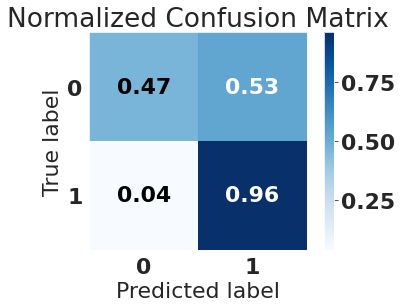

classification report
              precision    recall  f1-score   support

           0       0.69      0.47      0.56       964
           1       0.90      0.96      0.93      5036

    accuracy                           0.88      6000
   macro avg       0.80      0.71      0.75      6000
weighted avg       0.87      0.88      0.87      6000

Accuracy is  0.8815
Sensitivity is 0.9042811740512245
Specificity is 0.6943164362519201


In [552]:
LRModelAllDataSMOTE=applyLRModel(X_tr_SMOTE,y_tr_SMOTE,X_test,y_test)

#### <font color='magenta'><i>Applying Logistic Regression for PRWithoutErrSentimentRecords with SMOTE ( Data frame without those rows having user-sentiment not as per review rating and User product recommendation flag) 

best parameter:{'C': 10} best score:0.9888074291300099
confusion_matrix


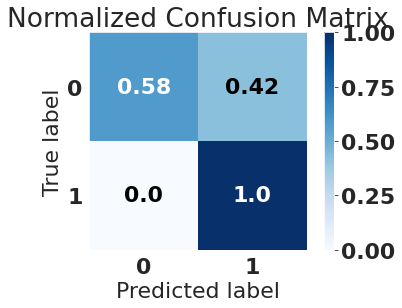

classification report
              precision    recall  f1-score   support

           0       0.85      0.58      0.69       227
           1       0.98      1.00      0.99      5034

    accuracy                           0.98      5261
   macro avg       0.92      0.79      0.84      5261
weighted avg       0.98      0.98      0.98      5261

Accuracy is  0.9775708040296521
Sensitivity is 0.9813944379161771
Specificity is 0.8516129032258064


In [553]:
LRModelWithoutErrSentimentRecordsSMOTE=applyLRModel(X_train_WithoutErrSentimentRecords_SMOTE,y_train_WithoutErrSentimentRecords_SMOTE,X_test_WithoutErrSentimentRecords,y_test_WithoutErrSentimentRecords)

#### <font color='magenta'><i>Applying Logistic Regression for PRCorrectedErrSentimentRecords with SMOTE ( Data frame with corrected values only for those records where user-sentiment was not as per review rating and User product recommendation flag)

best parameter:{'C': 10} best score:0.9054459676023413
confusion_matrix


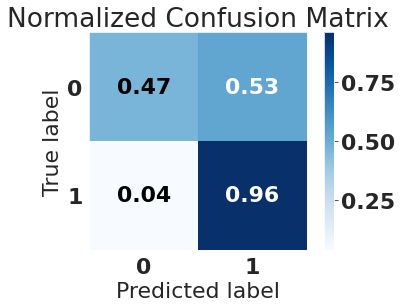

classification report
              precision    recall  f1-score   support

           0       0.69      0.47      0.56       964
           1       0.90      0.96      0.93      5036

    accuracy                           0.88      6000
   macro avg       0.80      0.71      0.75      6000
weighted avg       0.87      0.88      0.87      6000

Accuracy is  0.8815
Sensitivity is 0.9042811740512245
Specificity is 0.6943164362519201


In [554]:
LRModelCorrectedErrSentimentRecordsSMOTE=applyLRModel(X_train_CorrectedErrSentimentRecords_SMOTE,y_train_CorrectedErrSentimentRecords_SMOTE,X_test_CorrectedErrSentimentRecords,y_test_CorrectedErrSentimentRecords)

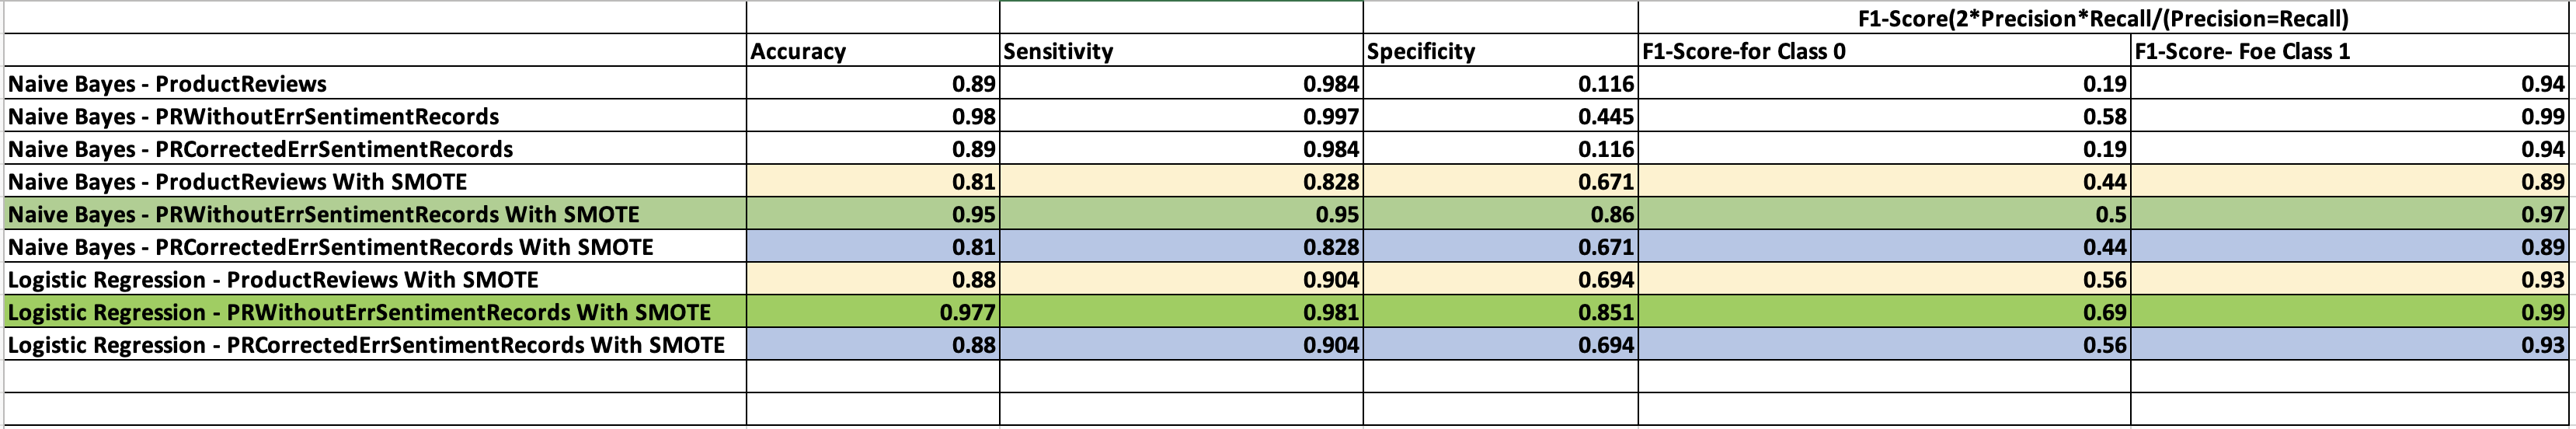

#### <font color='magenta'><i>We see for all 3 data sets (ProductReviews ( All data), PRWithoutErrSentimentRecords,PRCorrectedErrSentimentRecords) with Smote, Logistic Regression performed better than Naive bayes. Among those 3 data set also, we see PRWithoutErrSentimentRecords have better result for both cases Naive bayes and Logistic Regression

#### <font color='magenta'><i>Random Forest Common Function

In [515]:
def applyRandomForestModel(dfX_train,dfy_train,dfX_test,dfy_test):
    #GirdSearch
    random_gird={'max_depth':[10,30,50,70],
             'min_samples_leaf':[1,2,4,6],
              'max_features':['auto','sqrt']}
    model_rf = RandomForestClassifier()
    model_rf = GridSearchCV(model_rf, random_gird,scoring = "accuracy",cv = 5)
    model_rf.fit(dfX_train, dfy_train)
    evaluateModel(model_rf,dfX_test,dfy_test)
    return(model_rf)

#### <font color='magenta'><i>Applying Logistic Regression for productReviews Original data frame with SMOTE( Without any correction of User Sentiment Records based on review rating and User product recommendation flag) )

confusion_matrix


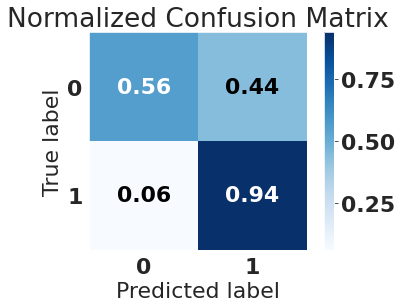

classification report
              precision    recall  f1-score   support

           0       0.50      0.56      0.53       580
           1       0.95      0.94      0.95      5420

    accuracy                           0.90      6000
   macro avg       0.73      0.75      0.74      6000
weighted avg       0.91      0.90      0.91      6000

Accuracy is  0.9038333333333334
Sensitivity is 0.9527014395214058
Specificity is 0.5023041474654378


In [516]:
RFModelAllDataSMOTE=applyRandomForestModel(X_tr_SMOTE,y_tr_SMOTE,X_test,y_test)

#### <font color='magenta'><i>Applying Logistic Regression for PRWithoutErrSentimentRecords with SMOTE ( Data frame without those rows having user-sentiment not as per review rating and User product recommendation flag) 

confusion_matrix


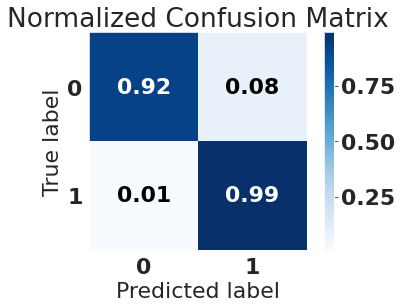

classification report
              precision    recall  f1-score   support

           0       0.63      0.92      0.75       107
           1       1.00      0.99      0.99      5154

    accuracy                           0.99      5261
   macro avg       0.82      0.95      0.87      5261
weighted avg       0.99      0.99      0.99      5261

Accuracy is  0.9874548564911614
Sensitivity is 0.9982373678025852
Specificity is 0.632258064516129


In [517]:
RFModelWithoutErrSentimentRecordsSMOTE=applyRandomForestModel(X_train_WithoutErrSentimentRecords_SMOTE,y_train_WithoutErrSentimentRecords_SMOTE,X_test_WithoutErrSentimentRecords,y_test_WithoutErrSentimentRecords)

#### <font color='magenta'><i>Applying Logistic Regression for PRCorrectedErrSentimentRecords with SMOTE ( Data frame with corrected values only for those records where user-sentiment was not as per review rating and User product recommendation flag)

confusion_matrix


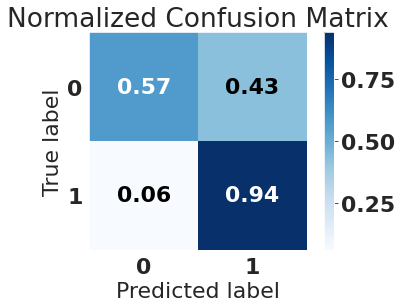

classification report
              precision    recall  f1-score   support

           0       0.49      0.57      0.53       567
           1       0.95      0.94      0.95      5433

    accuracy                           0.90      6000
   macro avg       0.72      0.75      0.74      6000
weighted avg       0.91      0.90      0.91      6000

Accuracy is  0.9043333333333333
Sensitivity is 0.9541970461768555
Specificity is 0.4946236559139785


In [518]:
RFModelCorrectedErrSentimentRecordsSMOTE=applyRandomForestModel(X_train_CorrectedErrSentimentRecords_SMOTE,y_train_CorrectedErrSentimentRecords_SMOTE,X_test_CorrectedErrSentimentRecords,y_test_CorrectedErrSentimentRecords)

#### <font color='magenta'><i>We see for all 3 data sets (ProductReviews ( All data), PRWithoutErrSentimentRecords,PRCorrectedErrSentimentRecords) with Smote, Logistic Regression performed better than Naive bayes. Among those 3 data set also, we see PRWithoutErrSentimentRecords have better result for both cases Naive bayes and Logistic Regression

#### <font color='magenta'><i>XGBoost Common Function

In [519]:
def applyXGBoostModel(dfX_train,dfy_train,dfX_test,dfy_test):
    xgb= XGBClassifier(n_estimators=1000,max_depth=6)
    xgb.fit(dfX_train, dfy_train)
    y_pred=xgb.predict(dfX_test)
    evaluateModel(xgb,dfX_test,dfy_test)
    return(xgb)

#### <font color='magenta'><i>Applying Logistic Regression for productReviews Original data frame with SMOTE( Without any correction of User Sentiment Records based on review rating and User product recommendation flag) )

/Users/taraknathkonar/_11Tarak/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:46:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
confusion_matrix


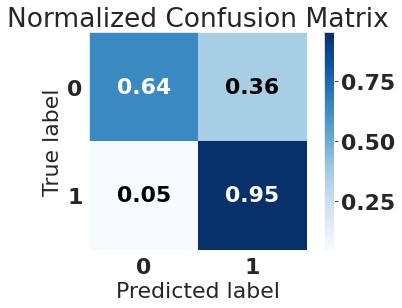

classification report
              precision    recall  f1-score   support

           0       0.59      0.64      0.61       602
           1       0.96      0.95      0.95      5398

    accuracy                           0.92      6000
   macro avg       0.77      0.79      0.78      6000
weighted avg       0.92      0.92      0.92      6000

Accuracy is  0.9191666666666667
Sensitivity is 0.959244718638998
Specificity is 0.5898617511520737


In [520]:
XGModelAllDataSMOTE=applyXGBoostModel(X_tr_SMOTE,y_tr_SMOTE,X_test,y_test)

#### <font color='magenta'><i>Applying Logistic Regression for PRWithoutErrSentimentRecords with SMOTE ( Data frame without those rows having user-sentiment not as per review rating and User product recommendation flag) 

/Users/taraknathkonar/_11Tarak/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:50:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
confusion_matrix


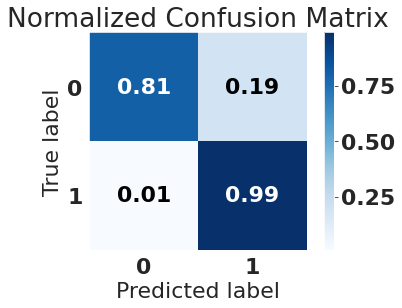

classification report
              precision    recall  f1-score   support

           0       0.72      0.81      0.76       137
           1       0.99      0.99      0.99      5124

    accuracy                           0.99      5261
   macro avg       0.86      0.90      0.88      5261
weighted avg       0.99      0.99      0.99      5261

Accuracy is  0.9866945447633529
Sensitivity is 0.9949079514296906
Specificity is 0.7161290322580646


In [521]:
XGModelWithoutErrSentimentRecordsSMOTE=applyXGBoostModel(X_train_WithoutErrSentimentRecords_SMOTE,y_train_WithoutErrSentimentRecords_SMOTE,X_test_WithoutErrSentimentRecords,y_test_WithoutErrSentimentRecords)

#### <font color='magenta'><i>Applying Logistic Regression for PRCorrectedErrSentimentRecords with SMOTE ( Data frame with corrected values only for those records where user-sentiment was not as per review rating and User product recommendation flag)

/Users/taraknathkonar/_11Tarak/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:54:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
confusion_matrix


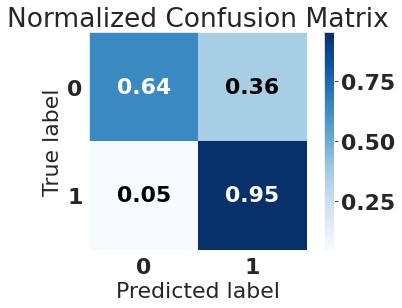

classification report
              precision    recall  f1-score   support

           0       0.59      0.64      0.61       602
           1       0.96      0.95      0.95      5398

    accuracy                           0.92      6000
   macro avg       0.77      0.79      0.78      6000
weighted avg       0.92      0.92      0.92      6000

Accuracy is  0.9191666666666667
Sensitivity is 0.959244718638998
Specificity is 0.5898617511520737


In [522]:
XGModelCorrectedErrSentimentRecordsSMOTE=applyXGBoostModel(X_train_CorrectedErrSentimentRecords_SMOTE,y_train_CorrectedErrSentimentRecords_SMOTE,X_test_CorrectedErrSentimentRecords,y_test_CorrectedErrSentimentRecords)

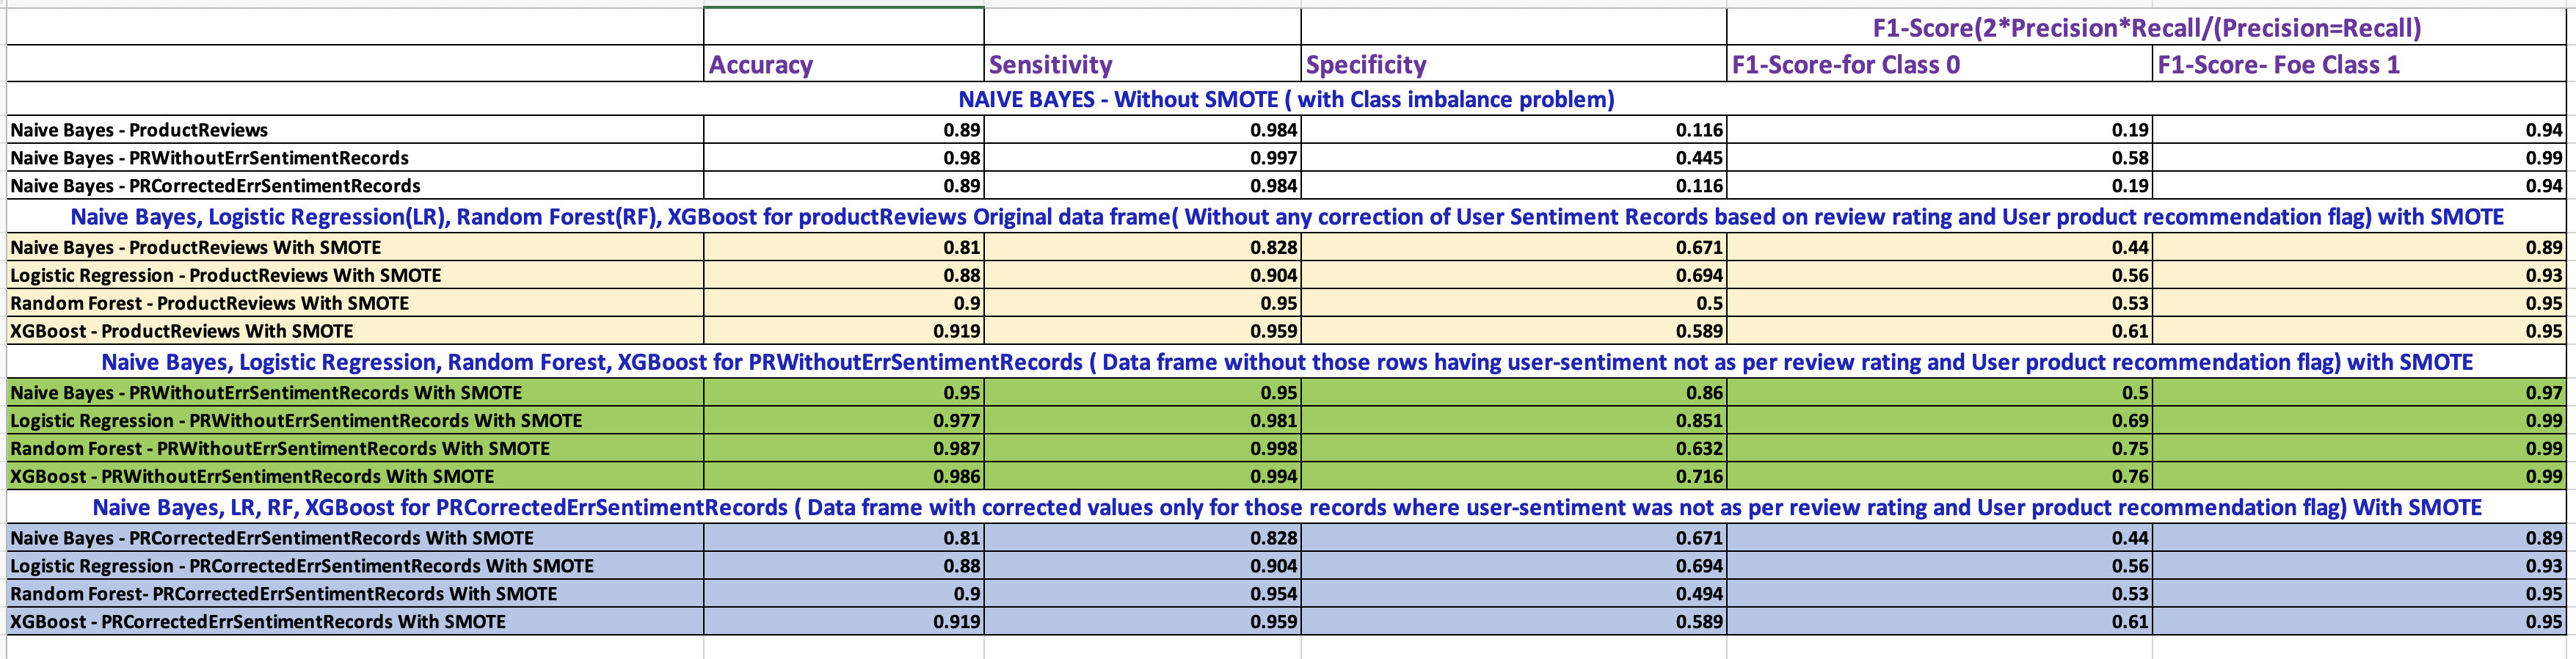

#### <font color='magenta'><i>We see for all 3 data sets (ProductReviews ( All data), PRWithoutErrSentimentRecords,PRCorrectedErrSentimentRecords) with Smote, XGBoost performed better than Others considering F1- Score for class 0, 1, Sensityvity, Specificity and Accuracy. Among those 3 data set , we see PRWithoutErrSentimentRecords have better result for both cases Naive bayes and Logistic Regression. We also obeserved, Data set after resolving class imbalance problem with SMOTE gives better performance.

#### <font color='magenta'><i>So finally selecting XGBoost Model trained on PRCorrectedErrSentimentRecords ( Data frame with corrected values only for those records where user-sentiment was not as per review rating and User product recommendation flag) with SMOTE having class imbalance problem

#### <font color='magenta'><i>Now as we see XGBoost is the best Model , we will try to tune it more to get final model by controlling hyperparameters

In [538]:
import warnings
warnings.filterwarnings('ignore')
# hyperparameter tuning with XGBoost

# creating a KFold object 
folds = 3

# specify range of hyperparameters
param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          


# specify model
xgb_model_WithoutErrSentimentRecordsSMOTE = XGBClassifier(max_depth=6, n_estimators=1000,eval_metric='mlogloss')

# set up GridSearchCV()
model_cv_WithoutErrSentimentRecordsSMOTE = GridSearchCV(estimator = xgb_model_WithoutErrSentimentRecordsSMOTE, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

In [539]:
# fit the model
model_cv_WithoutErrSentimentRecordsSMOTE.fit(X_train_WithoutErrSentimentRecords_SMOTE, y_train_WithoutErrSentimentRecords_SMOTE)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=6, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=1000, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=N

In [540]:
# cv results
cv_results = pd.DataFrame(model_cv_WithoutErrSentimentRecordsSMOTE.cv_results_)
cv_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_learning_rate param_subsample                                    params  split0_test_score  split1_test_score  split2_test_score  mean_test_score  std_test_score  rank_test_score  split0_train_score  split1_train_score  split2_train_score  mean_train_score  std_train_score
0         112.95          3.98             0.10            0.00                0.20            0.30  {'learning_rate': 0.2, 'subsample': 0.3}               1.00               1.00               1.00             1.00            0.00                5                1.00                1.00                1.00              1.00             0.00
1         173.17          5.29             0.12            0.01                0.20            0.60  {'learning_rate': 0.2, 'subsample': 0.6}               1.00               1.00               1.00             1.00            0.00                2                1.00                1.00                1.00              1.00             0.00
2         182.72          3.50             0.12            0.01                0.20            0.90  {'learning_rate': 0.2, 'subsample': 0.9}               1.00               1.00               1.00             1.00            0.00                1                1.00                1.00                1.00              1.00             0.00
3         120.14          3.15             0.11            0.00                0.60            0.30  {'learning_rate': 0.6, 'subsample': 0.3}               1.00               1.00               1.00             1.00            0.00                6                1.00                1.00                1.00              1.00             0.00
4         165.65          2.55             0.10            0.00                0.60            0.60  {'learning_rate': 0.6, 'subsample': 0.6}               1.00               1.00               1.00             1.00            0.00                4                1.00                1.00                1.00              1.00             0.00
5         174.17          3.57             0.10            0.00                0.60            0.90  {'learning_rate': 0.6, 'subsample': 0.9}               1.00               1.00               1.00             1.00            0.00                3                1.00                1.00                1.00              1.00             0.00

#### <font color='magenta'><i>So here we see the nest Parameter is Learning_rate=0.2 and Subsampple=0.9
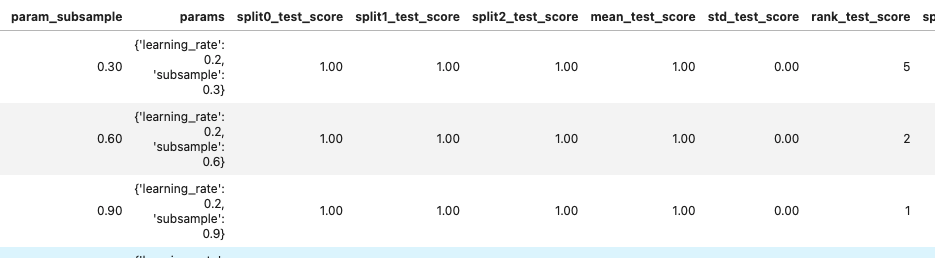

confusion_matrix


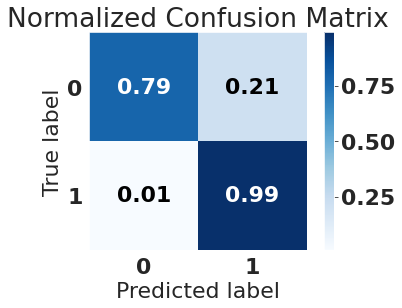

classification report
              precision    recall  f1-score   support

           0       0.74      0.79      0.76       146
           1       0.99      0.99      0.99      5115

    accuracy                           0.99      5261
   macro avg       0.87      0.89      0.88      5261
weighted avg       0.99      0.99      0.99      5261

Accuracy is  0.9865044668314009
Sensitivity is 0.9939287113200157
Specificity is 0.7419354838709677


In [549]:
# fit model on training data with choosed hyperparamters
Final_XGBModel_WithoutErrSentimentRecordsSMOTE = XGBClassifier(max_depth=6, n_estimators=1000,eval_metric='mlogloss',learning_rate=0.2,subsample=0.9,)
Final_XGBModel_WithoutErrSentimentRecordsSMOTE.fit(X_train_WithoutErrSentimentRecords_SMOTE, y_train_WithoutErrSentimentRecords_SMOTE)
evaluateModel(Final_XGBModel_WithoutErrSentimentRecordsSMOTE,X_test_WithoutErrSentimentRecords,y_test_WithoutErrSentimentRecords)

#### <font color='magenta'><i> We see with hyperparameters tuned specificity improved keeping same Accuracy, Sensitivity and F1 Score

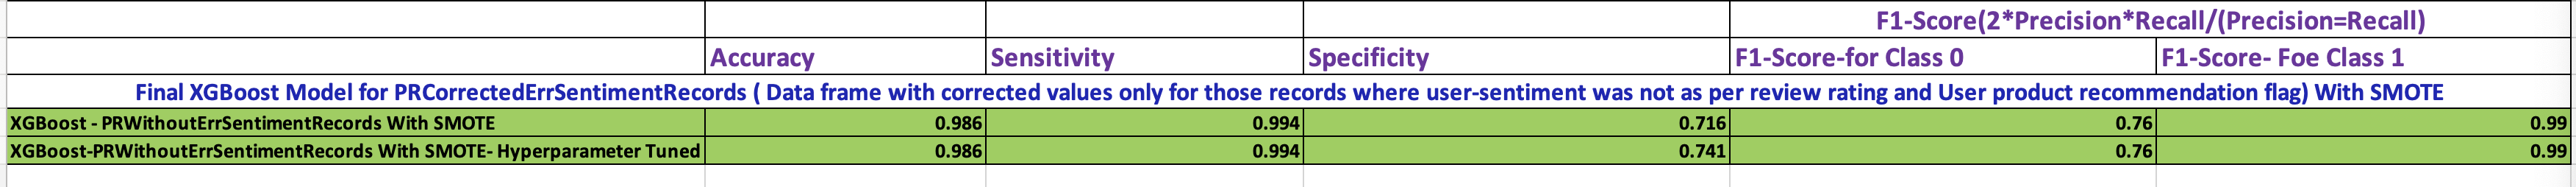

#### <font color='magenta'><i>Saving the Best Model - Final_XGBModel_WithoutErrSentimentRecordsSMOTE

In [550]:
import pickle
file_name = "BestSentimentAnalysisModel_XGBoost_Tuned.pkl"

try:
    # save
    pickle.dump(Final_XGBModel_WithoutErrSentimentRecordsSMOTE, open(file_name, "wb"))
    print("Model saved Successfully!")
except Exception as e:
    print("There is some error in saving the mode",e)

Model saved Successfully!


In [124]:
# Saving the pickle file for the word Vectorizer for the corrected dataset
# passing True here to cutom function featureExtractionTrainTestSplit , which will save the word vectorizer model for this data set
X_train_WithoutErrSentimentRecords, X_test_WithoutErrSentimentRecords, y_train_WithoutErrSentimentRecords, y_test_WithoutErrSentimentRecords = featureExtractionTrainTestSplit(PRWithoutErrSentimentRecords,True)

Dimension of X Training  Shape: (21042, 725)
Dimension of y Training Shape: (21042,)
Dimension of X Testing  Shape: (5261, 725)
Dimension of y Testing Shape: (5261,)
Model saved Successfully!


# Recommendation System Notebook
- User based recommendation
- User based prediction & evaluation
- Item based recommendation
- Item based prediction & evaluation

Different Approaches to develop Recommendation System -

1. Demographich based Recommendation System

2. Content Based Recommendation System

3. Collaborative filtering Recommendation System

In [142]:
# import libraties
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('max_colwidth',50)

In [143]:
# Reading ratings file from GitHub. # MovieLens
ratings = pd.read_csv('sample30.csv' , encoding='latin-1')
ratings.head(3)

id            brand  \
0  AV13O1A8GV-KLJ3akUyj  Universal Music   
1  AV14LG0R-jtxr-f38QfS         Lundberg   
2  AV14LG0R-jtxr-f38QfS         Lundberg   

                                          categories  \
0  Movies, Music & Books,Music,R&b,Movies & TV,Mo...   
1  Food,Packaged Foods,Snacks,Crackers,Snacks, Co...   
2  Food,Packaged Foods,Snacks,Crackers,Snacks, Co...   

                         manufacturer  \
0  Universal Music Group / Cash Money   
1                            Lundberg   
2                            Lundberg   

                                         name              reviews_date  \
0   Pink Friday: Roman Reloaded Re-Up (w/dvd)  2012-11-30T06:21:45.000Z   
1  Lundberg Organic Cinnamon Toast Rice Cakes  2017-07-09T00:00:00.000Z   
2  Lundberg Organic Cinnamon Toast Rice Cakes  2017-07-09T00:00:00.000Z   

  reviews_didPurchase reviews_doRecommend  reviews_rating  \
0                 NaN                 NaN               5   
1                True                 NaN               5   
2                True                 NaN               5   

                                        reviews_text reviews_title  \
0  i love this album. it's very good. more to the...  Just Awesome   
1  Good flavor. This review was collected as part...          Good   
2                                       Good flavor.          Good   

  reviews_userCity reviews_userProvince reviews_username user_sentiment  
0      Los Angeles                  NaN           joshua       Positive  
1              NaN                  NaN        dorothy w       Positive  
2              NaN                  NaN        dorothy w       Positive

In [144]:
#checking is there are duplicate records based on User Name (reviews_username) and product ID (id)
dfDuplicate = pd.DataFrame(ratings,columns = ['reviews_username', 'id'])
dfDuplicate = dfDuplicate[dfDuplicate.duplicated()]

In [145]:
dfDuplicate.shape

(2395, 2)

### <font color='magenta'><i>So there are total 2395 records showing having same user, product ID

In [146]:
dfDuplicate.head(2)

reviews_username                    id
2         dorothy w  AV14LG0R-jtxr-f38QfS
12          jds1992  AV16khLE-jtxr-f38VFn

In [147]:
# Verifying for one user and product how duplicate rows are. 
ratings[((ratings['reviews_username']=='dorothy w') & (ratings['id']=='AV14LG0R-jtxr-f38QfS'))]

id     brand  \
1  AV14LG0R-jtxr-f38QfS  Lundberg   
2  AV14LG0R-jtxr-f38QfS  Lundberg   

                                          categories manufacturer  \
1  Food,Packaged Foods,Snacks,Crackers,Snacks, Co...     Lundberg   
2  Food,Packaged Foods,Snacks,Crackers,Snacks, Co...     Lundberg   

                                         name              reviews_date  \
1  Lundberg Organic Cinnamon Toast Rice Cakes  2017-07-09T00:00:00.000Z   
2  Lundberg Organic Cinnamon Toast Rice Cakes  2017-07-09T00:00:00.000Z   

  reviews_didPurchase reviews_doRecommend  reviews_rating  \
1                True                 NaN               5   
2                True                 NaN               5   

                                        reviews_text reviews_title  \
1  Good flavor. This review was collected as part...          Good   
2                                       Good flavor.          Good   

  reviews_userCity reviews_userProvince reviews_username user_sentiment  
1              NaN                  NaN        dorothy w       Positive  
2              NaN                  NaN        dorothy w       Positive

### <font color='magenta'><i>So here we see for same user and product even their rating is also same as 5

In [148]:
# Verifying for another user and product how duplicate rows are. 
ratings[((ratings['reviews_username']=='jds1992') & (ratings['id']=='AV16khLE-jtxr-f38VFn'))]

id brand  \
10  AV16khLE-jtxr-f38VFn   K-Y   
12  AV16khLE-jtxr-f38VFn   K-Y   

                                           categories manufacturer  \
10  Personal Care,Medicine Cabinet,Lubricant/Sperm...          K-Y   
12  Personal Care,Medicine Cabinet,Lubricant/Sperm...          K-Y   

                                name              reviews_date  \
10  K-Y Love Sensuality Pleasure Gel  2016-04-08T00:00:00.000Z   
12  K-Y Love Sensuality Pleasure Gel  2016-04-08T00:00:00.000Z   

   reviews_didPurchase reviews_doRecommend  reviews_rating  \
10               False               False               1   
12               False               False               1   

                                         reviews_text        reviews_title  \
10  tried it with my husband and felt no different...  pretty dissapoitned   
12  Bought this to enhance our time a bit, did abs...       waste of money   

   reviews_userCity reviews_userProvince reviews_username user_sentiment  
10              NaN                  NaN          jds1992       Negative  
12              NaN                  NaN          jds1992       Negative

### <font color='magenta'><i>So here we see for same user and product even their rating is also same as 1

In [149]:
# Sorting the rows based on Reviews UserName, Product ID and then review rating . This will give us all rows for same user and product having highest rating as last row. As we are sorting Ascending.
ratings = ratings.sort_values(['reviews_username', 'id','reviews_rating'], ascending = (True))
ratings.head(5)

id                 brand  \
3499   AVpe6FfKilAPnD_xQmHi                  Chex   
1804   AVpe41TqilAPnD_xQH3d                   FOX   
2603   AVpe59io1cnluZ0-ZgDU  Universal Home Video   
23216  AVpfPaoqLJeJML435Xk9     Warner Home Video   
25656  AVpfPaoqLJeJML435Xk9     Warner Home Video   

                                              categories  \
3499   Food,Packaged Foods,Snacks,Snacks, Cookies & C...   
1804   Movies & TV Shows,Movies,Romance,Romantic Come...   
2603   Movies, Music & Books,Movies,Comedy,Movies & T...   
23216  Movies, Music & Books,Movies,Action & Adventur...   
25656  Movies, Music & Books,Movies,Action & Adventur...   

                    manufacturer  \
3499   GENERAL MILLS SALES, INC.   
1804       Twentieth Century Fox   
2603                   Universal   
23216                       Test   
25656                       Test   

                                                    name  \
3499        Chex Muddy Buddies Brownie Supreme Snack Mix   
1804        Mike Dave Need Wedding Dates (dvd + Digital)   
2603   My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...   
23216  Godzilla 3d Includes Digital Copy Ultraviolet ...   
25656  Godzilla 3d Includes Digital Copy Ultraviolet ...   

                   reviews_date reviews_didPurchase reviews_doRecommend  \
3499   2013-12-16T00:00:00.000Z                True                True   
1804   2017-03-14T00:00:00.000Z                 NaN               False   
2603   2016-07-09T00:00:00.000Z                 NaN               False   
23216  2014-11-06T00:00:00.000Z                 NaN                True   
25656  2014-11-05T00:00:00.000Z                 NaN                True   

       reviews_rating                                       reviews_text  \
3499                4  Very chocolaty taste to them. It hits the swee...   
1804                1  The trailers made the movie look like it had p...   
2603                3  Not as good as the 1st movie...usually not an ...   
23216               3  This movie was fun and entertaining for my fam...   
25656               5  Awesome movie! Excellent movie to watch, with ...   

                      reviews_title reviews_userCity reviews_userProvince  \
3499            something different              NaN                  NaN   
1804   Much worse then had hoped...              NaN                  NaN   
2603             Not as good as....              NaN                  NaN   
23216          Fun and entertaining              NaN                  NaN   
25656                Awesome movie!              NaN                  NaN   

      reviews_username user_sentiment  
3499            00dog3       Positive  
1804           00sab00       Positive  
2603           00sab00       Positive  
23216         01impala       Positive  
25656         02dakota       Positive

In [150]:
# Now dropping duplicates where user Name, ID and Review rating are same. And keeping the last record for that. We can keep any as all 3 are same
ratings=ratings.drop_duplicates(subset=['reviews_username', 'id','reviews_rating'], keep="last")

In [151]:
#Checking if there are till any duplicate rows only based on user Name and Product ID.
dfDuplicate = pd.DataFrame(ratings,columns = ['reviews_username', 'id'])
dfDuplicate = dfDuplicate[dfDuplicate.duplicated()]

In [152]:
# So now duplicates removed based on all 3 columns where same ['reviews_username', 'id','reviews_rating'] . But till there are duplicated based on only User Name and Product ID
dfDuplicate.shape

(158, 2)

### <font color='magenta'><i>So here we see we have 158 records duplicate values having same User and Product ID. But there review ratings are different. As earlier we already removed duplicates where review user Name, id and review rating were same

In [153]:
dfDuplicate.head(2)

reviews_username                    id
28354         7.87E+11  AVpfRTh1ilAPnD_xYic2
2219             aaron  AVpe41TqilAPnD_xQH3d

In [154]:
# now there are till duplicates where User, product ID is same but Rating is different. As below For same user and ID, it is rating 4 and 5. We will take last record as already sorted by review rating
ratings[((ratings['reviews_username']=='aaron') & (ratings['id']=='AVpe41TqilAPnD_xQH3d'))]

id brand  \
2121  AVpe41TqilAPnD_xQH3d   FOX   
2219  AVpe41TqilAPnD_xQH3d   FOX   

                                             categories  \
2121  Movies & TV Shows,Movies,Romance,Romantic Come...   
2219  Movies & TV Shows,Movies,Romance,Romantic Come...   

               manufacturer                                          name  \
2121  Twentieth Century Fox  Mike Dave Need Wedding Dates (dvd + Digital)   
2219  Twentieth Century Fox  Mike Dave Need Wedding Dates (dvd + Digital)   

                  reviews_date reviews_didPurchase reviews_doRecommend  \
2121  2017-03-15T00:00:00.000Z                 NaN                True   
2219  2016-11-03T00:00:00.000Z                 NaN                True   

      reviews_rating                                       reviews_text  \
2121               4  Movie is good and picture looks amazing on 4KR...   
2219               5  Very good casting of two funny people. The plo...   

     reviews_title reviews_userCity reviews_userProvince reviews_username  \
2121   Mike & Dave              NaN                  NaN            aaron   
2219      So funny              NaN                  NaN            aaron   

     user_sentiment  
2121       Positive  
2219       Positive

### <font color='magenta'><i>So here we see for same user and product ID here we have 2 rows . first one havig rating as 4. Second one having rating as 5. We will keep the last row. As We already sorted is ascending earlier. So we will keep the highest rating given by any user for any product.

In [155]:
# Dropping duplicated based on User Name and ID, Keeping the last record
ratings=ratings.drop_duplicates(subset=['reviews_username', 'id'], keep="last")

In [156]:
#Verifying if now there are no duplicates based on User Name and Product ID
dfDuplicate = pd.DataFrame(ratings,columns = ['reviews_username', 'id'])
dfDuplicate = dfDuplicate[dfDuplicate.duplicated()]

In [157]:
# So now No Duplicates
dfDuplicate.shape

(0, 2)

In [158]:
# Here are all the records where there is no duplicate based on these 3 columns= ['reviews_username', 'id','reviews_rating']
ratings.shape

(27605, 15)

### <font color='magenta'><i>So Now all duplicates are removed. And we have 27605 rows where combination of User and prodict ID is unique

In [159]:
# Verifying for one product what are the users. We will use this produdct ID through out this program to verify different matrix . we will build
print(list(ratings[((ratings['id']=='AV1YmDL9vKc47QAVgr7_'))]['reviews_username']))
print()
print(" So total number of unique users who given review rating for this product AV1YmDL9vKc47QAVgr7_  "+str(len(list(ratings[((ratings['id']=='AV1YmDL9vKc47QAVgr7_'))]['reviews_username']))))

['10ten', '2062351337', 'alaynamarie09', 'allyson55', 'amberd14', 'amy0916', 'apw513', 'ashday01', 'ashleydurry', 'aussiefanalltheway', 'babygirl24jg', 'bakerchef', 'bdeck', 'boyi', 'brit227', 'burber', 'caitb23', 'carsonensley', 'cdguerrero', 'cherylc', 'chris c', 'coupongirl63301', 'csofi11', 'ctn91', 'danielle', 'doll', 'dollface', 'dolpnlover', 'expertless', 'faith', 'falisha', 'gelo33', 'gelon33', 'heathernicole', 'hopea25', 'hurricanetoddlersmom', 'imsosalty', 'irna', 'jackie27', 'jenn1285', 'jocelyn987', 'jsob', 'justmissymoo2', 'kbella', 'keegan', 'kimba', 'kimmicha', 'kimt', 'kittycatty', 'leepatane', 'lexiibryant', 'lindsaymarieh', 'lmira', 'mary', 'megang123', 'megvan17', 'mercy55', 'milaya', 'mom and teacher', 'momandteacher', 'mommomofshyla', 'mrsmchenry2016', 'mrsperkins15', 'mysaturnsw2', 'nearthebeach', 'purple22', 'rachelroo33', 'rayray', 'rbreezy', 'rebeccam1126', 'rissalyn', 'sem40', 'sequindreams', 'shelbynos', 'summer', 'sunid83', 'supersquishy', 'sussan', 'tania',

In [160]:
# Copying ratings dataframe to into a new data frame
dfCollaborative=ratings.copy()

In [161]:
# checking info for new data frame
dfCollaborative.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27605 entries, 3499 to 21828
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    27605 non-null  object
 1   brand                 27605 non-null  object
 2   categories            27605 non-null  object
 3   manufacturer          27465 non-null  object
 4   name                  27605 non-null  object
 5   reviews_date          27562 non-null  object
 6   reviews_didPurchase   14926 non-null  object
 7   reviews_doRecommend   25239 non-null  object
 8   reviews_rating        27605 non-null  int64 
 9   reviews_text          27605 non-null  object
 10  reviews_title         27420 non-null  object
 11  reviews_userCity      1518 non-null   object
 12  reviews_userProvince  146 non-null    object
 13  reviews_username      27588 non-null  object
 14  user_sentiment        27604 non-null  object
dtypes: int64(1), object(14)
memory us

In [162]:
# Dropping unnecessary columns which are not needed for collaborative based recommendation system
dfCollaborative.drop(['brand','categories','manufacturer','name','reviews_date','reviews_didPurchase','reviews_doRecommend','reviews_text','reviews_title','reviews_userCity','reviews_userProvince','user_sentiment'],axis=1,inplace=True)

In [163]:
# Checking info after removal of unnecessary columns
dfCollaborative.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27605 entries, 3499 to 21828
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                27605 non-null  object
 1   reviews_rating    27605 non-null  int64 
 2   reviews_username  27588 non-null  object
dtypes: int64(1), object(2)
memory usage: 862.7+ KB


### <font color='magenta'><i>So there are few rows (27605-27588)=17 where user name is null. Will remove those rows

In [164]:
#dropping those 17 rows where User Name is null
dfCollaborative.dropna(subset = ["reviews_username"], inplace=True)

In [165]:
dfCollaborative.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27588 entries, 3499 to 7256
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                27588 non-null  object
 1   reviews_rating    27588 non-null  int64 
 2   reviews_username  27588 non-null  object
dtypes: int64(1), object(2)
memory usage: 862.1+ KB


In [166]:
dfCollaborative.describe()

reviews_rating
count    27588.000000
mean         4.525953
std          0.933354
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000

In [167]:
NoOfUsers=dfCollaborative['reviews_username'].nunique()
print("No Of unique Users in the dataset "+str(NoOfUsers))
NoOfProducts=dfCollaborative['id'].nunique()
print("No Of unique Items in the dataset "+str(NoOfProducts))

No Of unique Users in the dataset 24914
No Of unique Items in the dataset 271


## Dividing the dataset into train and test

In [168]:
# Test and Train split of the dataset.
from sklearn.model_selection import train_test_split
train, test = train_test_split(dfCollaborative, test_size=0.30, random_state=31)

In [169]:
print(train.shape)
print(test.shape)

(19311, 3)
(8277, 3)


In [170]:
train.head(2)

id  reviews_rating reviews_username
19980  AVpfJP1C1cnluZ0-e3Xy               5      southern123
2856   AVpe59io1cnluZ0-ZgDU               5        pamelarei

In [171]:
test.head(2)

id  reviews_rating reviews_username
15508  AVpf5olc1cnluZ0-tPrO               5            pinky
498    AV1l8zRZvKc47QAVhnAv               5          rlester

In [172]:
# Pivot the train ratings' dataset into matrix format in which columns are movies and the rows are user IDs.
df_pivot = train.pivot(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).fillna(0)

df_pivot.head(3)

id                AV13O1A8GV-KLJ3akUyj  AV14LG0R-jtxr-f38QfS  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   

id                AV1YIch7GV-KLJ3addeG  AV1YlENIglJLPUi8IHsX  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   

id                AV1YmBrdGV-KLJ3adewb  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  ...  \
reviews_username                                              ...   
00dog3                             0.0                   0.0  ...   
00sab00                            0.0                   0.0  ...   
01impala                           0.0                   0.0  ...   

id                AVpfrfHF1cnluZ0-pRai  AVpfrgjFLJeJML43BvCc  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   

id                AVpfs0tUilAPnD_xgqN2  AVpfsQoeilAPnD_xgfx5  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   

id                AVpfshNsLJeJML43CB8q  AVpfthSailAPnD_xg3ON  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   

id                AVpftikC1cnluZ0-p31V  AVpftymALJeJML43CZ6y  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   

id                AVpfv4TlilAPnD_xhjNS  AVpfvieo1cnluZ0-qdnu  
reviews_username                                              
00dog3                             0.0                   0.0  
00sab00                            0.0                   0.0  
01impala                           0.0                   0.0  

[3 rows x 256 columns]

In [173]:
# check number of unique users in unique products in Train Data set
NoOfUsers=train['reviews_username'].nunique()
print("No Of unique Users in the dataset "+str(NoOfUsers))
NoOfProducts=train['id'].nunique()
print("No Of unique Items in the train dataset "+str(NoOfProducts))

No Of unique Users in the dataset 17868
No Of unique Items in the train dataset 256


In [174]:
df_pivot.shape

(17868, 256)

### <font color='magenta'><i>So df_pivot size is matching with the No Of unique users and products in the train data set

In [175]:
#Checking if for this specific product all rating by users showing properly on Pivot table. To Confirm Pivot table done properly
df_pivot[(df_pivot['AV1YmDL9vKc47QAVgr7_']>0)].head(5)

id                AV13O1A8GV-KLJ3akUyj  AV14LG0R-jtxr-f38QfS  \
reviews_username                                               
10ten                              0.0                   0.0   
2062351337                         0.0                   0.0   
alaynamarie09                      0.0                   0.0   
allyson55                          0.0                   0.0   
amberd14                           0.0                   0.0   

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
10ten                              0.0                   0.0   
2062351337                         0.0                   0.0   
alaynamarie09                      0.0                   0.0   
allyson55                          0.0                   0.0   
amberd14                           0.0                   0.0   

id                AV1YIch7GV-KLJ3addeG  AV1YlENIglJLPUi8IHsX  \
reviews_username                                               
10ten                              0.0                   0.0   
2062351337                         0.0                   0.0   
alaynamarie09                      0.0                   0.0   
allyson55                          0.0                   0.0   
amberd14                           0.0                   0.0   

id                AV1YmBrdGV-KLJ3adewb  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
10ten                              0.0                   1.0   
2062351337                         0.0                   5.0   
alaynamarie09                      0.0                   4.0   
allyson55                          0.0                   4.0   
amberd14                           0.0                   4.0   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  ...  \
reviews_username                                              ...   
10ten                              0.0                   0.0  ...   
2062351337                         0.0                   0.0  ...   
alaynamarie09                      0.0                   0.0  ...   
allyson55                          0.0                   0.0  ...   
amberd14                           0.0                   0.0  ...   

id                AVpfrfHF1cnluZ0-pRai  AVpfrgjFLJeJML43BvCc  \
reviews_username                                               
10ten                              0.0                   0.0   
2062351337                         0.0                   0.0   
alaynamarie09                      0.0                   0.0   
allyson55                          0.0                   0.0   
amberd14                           0.0                   0.0   

id                AVpfs0tUilAPnD_xgqN2  AVpfsQoeilAPnD_xgfx5  \
reviews_username                                               
10ten                              0.0                   0.0   
2062351337                         0.0                   0.0   
alaynamarie09                      0.0                   0.0   
allyson55                          0.0                   0.0   
amberd14                           0.0                   0.0   

id                AVpfshNsLJeJML43CB8q  AVpfthSailAPnD_xg3ON  \
reviews_username                                               
10ten                              0.0                   0.0   
2062351337                         0.0                   0.0   
alaynamarie09                      0.0                   0.0   
allyson55                          0.0                   0.0   
amberd14                           0.0                   0.0   

id                AVpftikC1cnluZ0-p31V  AVpftymALJeJML43CZ6y  \
reviews_username                                               
10ten                              0.0                   0.0   
2062351337                         0.0                   0.0   
alaynamarie09                      0.0                   0.0   
allyson55                          0.0               

### Creating dummy train & dummy test dataset
These dataset will be used for prediction 
- Dummy train will be used later for prediction of the movies which has not been rated by the user. To ignore the movies rated by the user, we will mark it as 0 during prediction. The movies not rated by user is marked as 1 for prediction in dummy train dataset. 

- Dummy test will be used for evaluation. To evaluate, we will only make prediction on the movies rated by the user. So, this is marked as 1. This is just opposite of dummy_train.

In [176]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()

In [177]:
# The movies not rated by user is marked as 1 for prediction. 
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [178]:
# Convert the dummy train dataset into matrix format.
dummy_train = dummy_train.pivot(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).fillna(1)

In [179]:
# So checking for below users who rated this product AV1YmDL9vKc47QAVgr7_. For them in dummy_train , the value is 0 and for other product where they have not rated is showing 1
dummy_train[(dummy_train.AV1YmDL9vKc47QAVgr7_<1)].head(5)

id                AV13O1A8GV-KLJ3akUyj  AV14LG0R-jtxr-f38QfS  \
reviews_username                                               
10ten                              1.0                   1.0   
2062351337                         1.0                   1.0   
alaynamarie09                      1.0                   1.0   
allyson55                          1.0                   1.0   
amberd14                           1.0                   1.0   

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
10ten                              1.0                   1.0   
2062351337                         1.0                   1.0   
alaynamarie09                      1.0                   1.0   
allyson55                          1.0                   1.0   
amberd14                           1.0                   1.0   

id                AV1YIch7GV-KLJ3addeG  AV1YlENIglJLPUi8IHsX  \
reviews_username                                               
10ten                              1.0                   1.0   
2062351337                         1.0                   1.0   
alaynamarie09                      1.0                   1.0   
allyson55                          1.0                   1.0   
amberd14                           1.0                   1.0   

id                AV1YmBrdGV-KLJ3adewb  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
10ten                              1.0                   0.0   
2062351337                         1.0                   0.0   
alaynamarie09                      1.0                   0.0   
allyson55                          1.0                   0.0   
amberd14                           1.0                   0.0   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  ...  \
reviews_username                                              ...   
10ten                              1.0                   1.0  ...   
2062351337                         1.0                   1.0  ...   
alaynamarie09                      1.0                   1.0  ...   
allyson55                          1.0                   1.0  ...   
amberd14                           1.0                   1.0  ...   

id                AVpfrfHF1cnluZ0-pRai  AVpfrgjFLJeJML43BvCc  \
reviews_username                                               
10ten                              1.0                   1.0   
2062351337                         1.0                   1.0   
alaynamarie09                      1.0                   1.0   
allyson55                          1.0                   1.0   
amberd14                           1.0                   1.0   

id                AVpfs0tUilAPnD_xgqN2  AVpfsQoeilAPnD_xgfx5  \
reviews_username                                               
10ten                              1.0                   1.0   
2062351337                         1.0                   1.0   
alaynamarie09                      1.0                   1.0   
allyson55                          1.0                   1.0   
amberd14                           1.0                   1.0   

id                AVpfshNsLJeJML43CB8q  AVpfthSailAPnD_xg3ON  \
reviews_username                                               
10ten                              1.0                   1.0   
2062351337                         1.0                   1.0   
alaynamarie09                      1.0                   1.0   
allyson55                          1.0                   1.0   
amberd14                           1.0                   1.0   

id                AVpftikC1cnluZ0-p31V  AVpftymALJeJML43CZ6y  \
reviews_username                                               
10ten                              1.0                   1.0   
2062351337                         1.0                   1.0   
alaynamarie09                      1.0                   1.0   
allyson55                          1.0               

**Cosine Similarity**

Cosine Similarity is a measurement that quantifies the similarity between two vectors [Which is Rating Vector in this case] 

**Adjusted Cosine**

Adjusted cosine similarity is a modified version of vector-based similarity where we incorporate the fact that different users have different ratings schemes. In other words, some users might rate items highly in general, and others might give items lower ratings as a preference. To handle this nature from rating given by user , we subtract average ratings for each user from each user's rating for different movies.



# User Similarity Matrix

## Using Cosine Similarity

In [180]:
from sklearn.metrics.pairwise import pairwise_distances

# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_pivot, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1.        0.        0.        ... 0.        0.        0.       ]
 [0.        1.        0.        ... 0.        0.9486833 0.       ]
 [0.        0.        1.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 1.        0.        1.       ]
 [0.        0.9486833 0.        ... 0.        1.        0.       ]
 [0.        0.        0.        ... 1.        0.        1.       ]]


In [181]:
user_correlation.shape

(17868, 17868)

In [182]:
ratings[(ratings['reviews_username']=='00sab00') | (ratings['reviews_username']=='zzdiane')]

id                 brand  \
1804  AVpe41TqilAPnD_xQH3d                   FOX   
2603  AVpe59io1cnluZ0-ZgDU  Universal Home Video   
3043  AVpe59io1cnluZ0-ZgDU  Universal Home Video   

                                             categories  \
1804  Movies & TV Shows,Movies,Romance,Romantic Come...   
2603  Movies, Music & Books,Movies,Comedy,Movies & T...   
3043  Movies, Music & Books,Movies,Comedy,Movies & T...   

               manufacturer  \
1804  Twentieth Century Fox   
2603              Universal   
3043              Universal   

                                                   name  \
1804       Mike Dave Need Wedding Dates (dvd + Digital)   
2603  My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...   
3043  My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...   

                  reviews_date reviews_didPurchase reviews_doRecommend  \
1804  2017-03-14T00:00:00.000Z                 NaN               False   
2603  2016-07-09T00:00:00.000Z                 NaN               False   
3043  2016-09-02T00:00:00.000Z                 NaN                True   

      reviews_rating                                       reviews_text  \
1804               1  The trailers made the movie look like it had p...   
2603               3  Not as good as the 1st movie...usually not an ...   
3043               5  Very funny and definitely as good as the first...   

                     reviews_title reviews_userCity reviews_userProvince  \
1804  Much worse then had hoped...              NaN                  NaN   
2603            Not as good as....              NaN                  NaN   
3043                    Good Movie              NaN                  NaN   

     reviews_username user_sentiment  
1804          00sab00       Positive  
2603          00sab00       Positive  
3043          zzdiane       Positive

### <font color='magenta'><i>So user corelation is 17868*17868 matrix. Which is basically no of unique users in the train data set. So each value indicates corelation in between 2 users. If we see corner values having 1. As because user1's corelation will be 1 with user 1, User2 - corelation will be 1 with user 2. In the above Matrix we see, user [17868-1] having a corelation with user 2 as 0.9486833. We have verified above for those 2 users 00sab00 and zzdiane given rating for product AVpe59io1cnluZ0-ZgDU as 3 and 5. So they have corelation showing similarity. So usr_corelation matrix has formed correctly

## Using adjusted Cosine 

### Here, we are not removing the NaN values and calculating the mean only for the movies rated by the user

In [183]:
# Create a user-movie matrix.
df_pivotAdjCosine = train.pivot(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
)
df_pivotAdjCosine.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17868 entries, 00dog3 to zzz1127
Columns: 256 entries, AV13O1A8GV-KLJ3akUyj to AVpfvieo1cnluZ0-qdnu
dtypes: float64(256)
memory usage: 35.0+ MB


In [184]:
#Checking if for this specific product all rating by users showing properly on Pivot table. To Confirm Pivot table done properly
df_pivotAdjCosine[(df_pivotAdjCosine['AV1YmDL9vKc47QAVgr7_']>0)].head(5)

id                AV13O1A8GV-KLJ3akUyj  AV14LG0R-jtxr-f38QfS  \
reviews_username                                               
10ten                              NaN                   NaN   
2062351337                         NaN                   NaN   
alaynamarie09                      NaN                   NaN   
allyson55                          NaN                   NaN   
amberd14                           NaN                   NaN   

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
10ten                              NaN                   NaN   
2062351337                         NaN                   NaN   
alaynamarie09                      NaN                   NaN   
allyson55                          NaN                   NaN   
amberd14                           NaN                   NaN   

id                AV1YIch7GV-KLJ3addeG  AV1YlENIglJLPUi8IHsX  \
reviews_username                                               
10ten                              NaN                   NaN   
2062351337                         NaN                   NaN   
alaynamarie09                      NaN                   NaN   
allyson55                          NaN                   NaN   
amberd14                           NaN                   NaN   

id                AV1YmBrdGV-KLJ3adewb  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
10ten                              NaN                   1.0   
2062351337                         NaN                   5.0   
alaynamarie09                      NaN                   4.0   
allyson55                          NaN                   4.0   
amberd14                           NaN                   4.0   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  ...  \
reviews_username                                              ...   
10ten                              NaN                   NaN  ...   
2062351337                         NaN                   NaN  ...   
alaynamarie09                      NaN                   NaN  ...   
allyson55                          NaN                   NaN  ...   
amberd14                           NaN                   NaN  ...   

id                AVpfrfHF1cnluZ0-pRai  AVpfrgjFLJeJML43BvCc  \
reviews_username                                               
10ten                              NaN                   NaN   
2062351337                         NaN                   NaN   
alaynamarie09                      NaN                   NaN   
allyson55                          NaN                   NaN   
amberd14                           NaN                   NaN   

id                AVpfs0tUilAPnD_xgqN2  AVpfsQoeilAPnD_xgfx5  \
reviews_username                                               
10ten                              NaN                   NaN   
2062351337                         NaN                   NaN   
alaynamarie09                      NaN                   NaN   
allyson55                          NaN                   NaN   
amberd14                           NaN                   NaN   

id                AVpfshNsLJeJML43CB8q  AVpfthSailAPnD_xg3ON  \
reviews_username                                               
10ten                              NaN                   NaN   
2062351337                         NaN                   NaN   
alaynamarie09                      NaN                   NaN   
allyson55                          NaN                   NaN   
amberd14                           NaN                   NaN   

id                AVpftikC1cnluZ0-p31V  AVpftymALJeJML43CZ6y  \
reviews_username                                               
10ten                              NaN                   NaN   
2062351337                         NaN                   NaN   
alaynamarie09                      NaN                   NaN   
allyson55                          NaN               

### Normalising the rating of the movie for each user around 0 mean

In [185]:
# getting mean for average rating for all users 
mean = np.nanmean(df_pivotAdjCosine, axis=1)

In [186]:
# printing mean
mean

array([4., 2., 3., ..., 5., 5., 4.])

In [187]:
# mean length is equal to Number of users on the train data set whish is 17868
mean.shape

(17868,)

In [188]:
#verifying if mean is done prperly for first 2 users
df_pivotAdjCosine.head(2)

id                AV13O1A8GV-KLJ3akUyj  AV14LG0R-jtxr-f38QfS  \
reviews_username                                               
00dog3                             NaN                   NaN   
00sab00                            NaN                   NaN   

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
00dog3                             NaN                   NaN   
00sab00                            NaN                   NaN   

id                AV1YIch7GV-KLJ3addeG  AV1YlENIglJLPUi8IHsX  \
reviews_username                                               
00dog3                             NaN                   NaN   
00sab00                            NaN                   NaN   

id                AV1YmBrdGV-KLJ3adewb  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
00dog3                             NaN                   NaN   
00sab00                            NaN                   NaN   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  ...  \
reviews_username                                              ...   
00dog3                             NaN                   NaN  ...   
00sab00                            NaN                   NaN  ...   

id                AVpfrfHF1cnluZ0-pRai  AVpfrgjFLJeJML43BvCc  \
reviews_username                                               
00dog3                             NaN                   NaN   
00sab00                            NaN                   NaN   

id                AVpfs0tUilAPnD_xgqN2  AVpfsQoeilAPnD_xgfx5  \
reviews_username                                               
00dog3                             NaN                   NaN   
00sab00                            NaN                   NaN   

id                AVpfshNsLJeJML43CB8q  AVpfthSailAPnD_xg3ON  \
reviews_username                                               
00dog3                             NaN                   NaN   
00sab00                            NaN                   NaN   

id                AVpftikC1cnluZ0-p31V  AVpftymALJeJML43CZ6y  \
reviews_username                                               
00dog3                             NaN                   NaN   
00sab00                            NaN                   NaN   

id                AVpfv4TlilAPnD_xhjNS  AVpfvieo1cnluZ0-qdnu  
reviews_username                                              
00dog3                             NaN                   NaN  
00sab00                            NaN                   NaN  

[2 rows x 256 columns]

In [189]:
ratings[(ratings['reviews_username']=='00sab00') | (ratings['reviews_username']=='00dog3')]

id                 brand  \
3499  AVpe6FfKilAPnD_xQmHi                  Chex   
1804  AVpe41TqilAPnD_xQH3d                   FOX   
2603  AVpe59io1cnluZ0-ZgDU  Universal Home Video   

                                             categories  \
3499  Food,Packaged Foods,Snacks,Snacks, Cookies & C...   
1804  Movies & TV Shows,Movies,Romance,Romantic Come...   
2603  Movies, Music & Books,Movies,Comedy,Movies & T...   

                   manufacturer  \
3499  GENERAL MILLS SALES, INC.   
1804      Twentieth Century Fox   
2603                  Universal   

                                                   name  \
3499       Chex Muddy Buddies Brownie Supreme Snack Mix   
1804       Mike Dave Need Wedding Dates (dvd + Digital)   
2603  My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...   

                  reviews_date reviews_didPurchase reviews_doRecommend  \
3499  2013-12-16T00:00:00.000Z                True                True   
1804  2017-03-14T00:00:00.000Z                 NaN               False   
2603  2016-07-09T00:00:00.000Z                 NaN               False   

      reviews_rating                                       reviews_text  \
3499               4  Very chocolaty taste to them. It hits the swee...   
1804               1  The trailers made the movie look like it had p...   
2603               3  Not as good as the 1st movie...usually not an ...   

                     reviews_title reviews_userCity reviews_userProvince  \
3499           something different              NaN                  NaN   
1804  Much worse then had hoped...              NaN                  NaN   
2603            Not as good as....              NaN                  NaN   

     reviews_username user_sentiment  
3499           00dog3       Positive  
1804          00sab00       Positive  
2603          00sab00       Positive

### <font color='magenta'><i>So here we see for first 2 users 00sab00- Given rating as 4 for one product. So average is 4 and for second user 00dog3 - given rating 1 and 3 for 2 products. So averate rating is (1+3)/2=2 . Which is matching with the mean value- array([4., 2., 3., ..., 5., 5., 4.])

In [190]:
# transpose the matrix to get User Name as column and Product IDs as rows
df_pivotAdjCosine.T

reviews_username      00dog3  00sab00  01impala  02dakota  02deuce  0325home  \
id                                                                             
AV13O1A8GV-KLJ3akUyj     NaN      NaN       NaN       NaN      NaN       NaN   
AV14LG0R-jtxr-f38QfS     NaN      NaN       NaN       NaN      NaN       NaN   
AV16khLE-jtxr-f38VFn     NaN      NaN       NaN       NaN      NaN       NaN   
AV1YGDqsGV-KLJ3adc-O     NaN      NaN       NaN       NaN      NaN       NaN   
AV1YIch7GV-KLJ3addeG     NaN      NaN       NaN       NaN      NaN       NaN   
...                      ...      ...       ...       ...      ...       ...   
AVpfthSailAPnD_xg3ON     NaN      NaN       NaN       NaN      NaN       NaN   
AVpftikC1cnluZ0-p31V     NaN      NaN       NaN       NaN      NaN       NaN   
AVpftymALJeJML43CZ6y     NaN      NaN       NaN       NaN      NaN       NaN   
AVpfv4TlilAPnD_xhjNS     NaN      NaN       NaN       NaN      NaN       NaN   
AVpfvieo1cnluZ0-qdnu     NaN      NaN       NaN       NaN      NaN       NaN   

reviews_username      06stidriver  09mommy11  1085  10ten  ...  zpalma  \
id                                                         ...           
AV13O1A8GV-KLJ3akUyj          NaN        NaN   NaN    NaN  ...     NaN   
AV14LG0R-jtxr-f38QfS          NaN        NaN   NaN    NaN  ...     NaN   
AV16khLE-jtxr-f38VFn          NaN        NaN   NaN    NaN  ...     NaN   
AV1YGDqsGV-KLJ3adc-O          NaN        NaN   NaN    NaN  ...     NaN   
AV1YIch7GV-KLJ3addeG          NaN        NaN   NaN    NaN  ...     NaN   
...                           ...        ...   ...    ...  ...     ...   
AVpfthSailAPnD_xg3ON          NaN        NaN   NaN    NaN  ...     NaN   
AVpftikC1cnluZ0-p31V          NaN        NaN   NaN    NaN  ...     NaN   
AVpftymALJeJML43CZ6y          NaN        NaN   NaN    NaN  ...     NaN   
AVpfv4TlilAPnD_xhjNS          NaN        NaN   NaN    NaN  ...     NaN   
AVpfvieo1cnluZ0-qdnu          NaN        NaN   NaN    NaN  ...     NaN   

reviews_username      zsarah  zsazsa  zubb  zulaa118  zwithanx  zxcsdfd  \
id                                                                        
AV13O1A8GV-KLJ3akUyj     NaN     NaN   NaN       NaN       NaN      NaN   
AV14LG0R-jtxr-f38QfS     NaN     NaN   NaN       NaN       NaN      NaN   
AV16khLE-jtxr-f38VFn     NaN     NaN   NaN       NaN       NaN      NaN   
AV1YGDqsGV-KLJ3adc-O     NaN     NaN   NaN       NaN       NaN      NaN   
AV1YIch7GV-KLJ3addeG     NaN     NaN   NaN       NaN       NaN      NaN   
...                      ...     ...   ...       ...       ...      ...   
AVpfthSailAPnD_xg3ON     NaN     NaN   NaN       NaN       NaN      NaN   
AVpftikC1cnluZ0-p31V     NaN     NaN   NaN       NaN       NaN      NaN   
AVpftymALJeJML43CZ6y     NaN     NaN   NaN       NaN       NaN      NaN   
AVpfv4TlilAPnD_xhjNS     NaN     NaN   NaN       NaN       NaN      NaN   
AVpfvieo1cnluZ0-qdnu     NaN     NaN   NaN       NaN       NaN      NaN   

reviews_username      zyiah4  zzdiane  zzz1127  
id                                              
AV13O1A8GV-KLJ3akUyj     NaN      NaN      NaN  
AV14LG0R-jtxr-f38QfS     NaN      NaN      NaN  
AV16khLE-jtxr-f38VFn     NaN      NaN      NaN  
AV1YGDqsGV-KLJ3adc-O     NaN      NaN      NaN  
AV1YIch7GV-KLJ3addeG     NaN      NaN      NaN  
...                      ...      ...      ...  
AVpfthSailAPnD_xg3ON     NaN      NaN      NaN  
AVpftikC1cnluZ0-p31V     NaN      NaN      NaN  
AVpftymALJeJML43CZ6y     NaN      NaN      NaN  
AVpfv4TlilAPnD_xhjNS     NaN      NaN      NaN  
AVpfvieo1cnluZ0-qdnu     NaN      NaN      NaN  

[256 rows x 17868 columns]

In [191]:
#Verifying how transpose matrix showing rating values
df_pivotAdjCosine.T[(df_pivotAdjCosine.T.danielle>1)]

reviews_username      00dog3  00sab00  01impala  02dakota  02deuce  0325home  \
id                                                                             
AV1h6gSl-jtxr-f31p40     NaN      NaN       NaN       NaN      NaN       NaN   
AVpe59io1cnluZ0-ZgDU     NaN      3.0       NaN       NaN      NaN       NaN   
AVpf5olc1cnluZ0-tPrO     NaN      NaN       NaN       NaN      NaN       NaN   

reviews_username      06stidriver  09mommy11  1085  10ten  ...  zpalma  \
id                                                         ...           
AV1h6gSl-jtxr-f31p40          NaN        NaN   NaN    NaN  ...     NaN   
AVpe59io1cnluZ0-ZgDU          NaN        NaN   5.0    NaN  ...     NaN   
AVpf5olc1cnluZ0-tPrO          NaN        NaN   NaN    NaN  ...     NaN   

reviews_username      zsarah  zsazsa  zubb  zulaa118  zwithanx  zxcsdfd  \
id                                                                        
AV1h6gSl-jtxr-f31p40     NaN     NaN   NaN       NaN       NaN      NaN   
AVpe59io1cnluZ0-ZgDU     NaN     NaN   NaN       NaN       NaN      NaN   
AVpf5olc1cnluZ0-tPrO     NaN     NaN   NaN       NaN       NaN      NaN   

reviews_username      zyiah4  zzdiane  zzz1127  
id                                              
AV1h6gSl-jtxr-f31p40     NaN      NaN      NaN  
AVpe59io1cnluZ0-ZgDU     NaN      5.0      NaN  
AVpf5olc1cnluZ0-tPrO     NaN      NaN      NaN  

[3 rows x 17868 columns]

In [192]:
(df_pivotAdjCosine.T-mean)[((df_pivotAdjCosine.T-mean).danielle>0)]

reviews_username      00dog3  00sab00  01impala  02dakota  02deuce  0325home  \
id                                                                             
AVpe59io1cnluZ0-ZgDU     NaN      1.0       NaN       NaN      NaN       NaN   
AVpf5olc1cnluZ0-tPrO     NaN      NaN       NaN       NaN      NaN       NaN   

reviews_username      06stidriver  09mommy11  1085  10ten  ...  zpalma  \
id                                                         ...           
AVpe59io1cnluZ0-ZgDU          NaN        NaN   0.0    NaN  ...     NaN   
AVpf5olc1cnluZ0-tPrO          NaN        NaN   NaN    NaN  ...     NaN   

reviews_username      zsarah  zsazsa  zubb  zulaa118  zwithanx  zxcsdfd  \
id                                                                        
AVpe59io1cnluZ0-ZgDU     NaN     NaN   NaN       NaN       NaN      NaN   
AVpf5olc1cnluZ0-tPrO     NaN     NaN   NaN       NaN       NaN      NaN   

reviews_username      zyiah4  zzdiane  zzz1127  
id                                              
AVpe59io1cnluZ0-ZgDU     NaN      0.0      NaN  
AVpf5olc1cnluZ0-tPrO     NaN      NaN      NaN  

[2 rows x 17868 columns]

### <font color='magenta'><i>So for user 00sab00 mean was 2, and it rated product - AVpe59io1cnluZ0-ZgDU as 3. So after subtracting mean, it's new rating becoming (3-2)=1. For user 1085, it rated product AVpe59io1cnluZ0-ZgDU as 5. But as it rated only one product so mean was 5. Then for df_pivot.T-mean it becomes (5-5)=0

In [193]:
df_subtracted = (df_pivotAdjCosine.T-mean).T

In [194]:
# Checking in original oivot data frame what was the rating for the product AV1YmDL9vKc47QAVgr7_
df_pivotAdjCosine[(df_pivotAdjCosine['AV1YmDL9vKc47QAVgr7_']>=0)].head(5)

id                AV13O1A8GV-KLJ3akUyj  AV14LG0R-jtxr-f38QfS  \
reviews_username                                               
10ten                              NaN                   NaN   
2062351337                         NaN                   NaN   
alaynamarie09                      NaN                   NaN   
allyson55                          NaN                   NaN   
amberd14                           NaN                   NaN   

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
10ten                              NaN                   NaN   
2062351337                         NaN                   NaN   
alaynamarie09                      NaN                   NaN   
allyson55                          NaN                   NaN   
amberd14                           NaN                   NaN   

id                AV1YIch7GV-KLJ3addeG  AV1YlENIglJLPUi8IHsX  \
reviews_username                                               
10ten                              NaN                   NaN   
2062351337                         NaN                   NaN   
alaynamarie09                      NaN                   NaN   
allyson55                          NaN                   NaN   
amberd14                           NaN                   NaN   

id                AV1YmBrdGV-KLJ3adewb  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
10ten                              NaN                   1.0   
2062351337                         NaN                   5.0   
alaynamarie09                      NaN                   4.0   
allyson55                          NaN                   4.0   
amberd14                           NaN                   4.0   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  ...  \
reviews_username                                              ...   
10ten                              NaN                   NaN  ...   
2062351337                         NaN                   NaN  ...   
alaynamarie09                      NaN                   NaN  ...   
allyson55                          NaN                   NaN  ...   
amberd14                           NaN                   NaN  ...   

id                AVpfrfHF1cnluZ0-pRai  AVpfrgjFLJeJML43BvCc  \
reviews_username                                               
10ten                              NaN                   NaN   
2062351337                         NaN                   NaN   
alaynamarie09                      NaN                   NaN   
allyson55                          NaN                   NaN   
amberd14                           NaN                   NaN   

id                AVpfs0tUilAPnD_xgqN2  AVpfsQoeilAPnD_xgfx5  \
reviews_username                                               
10ten                              NaN                   NaN   
2062351337                         NaN                   NaN   
alaynamarie09                      NaN                   NaN   
allyson55                          NaN                   NaN   
amberd14                           NaN                   NaN   

id                AVpfshNsLJeJML43CB8q  AVpfthSailAPnD_xg3ON  \
reviews_username                                               
10ten                              NaN                   NaN   
2062351337                         NaN                   NaN   
alaynamarie09                      NaN                   NaN   
allyson55                          NaN                   NaN   
amberd14                           NaN                   NaN   

id                AVpftikC1cnluZ0-p31V  AVpftymALJeJML43CZ6y  \
reviews_username                                               
10ten                              NaN                   NaN   
2062351337                         NaN                   NaN   
alaynamarie09                      NaN                   NaN   
allyson55                          NaN               

In [195]:
# Checking in subtracted data frame what is the rating for those users for this product - AV1YmDL9vKc47QAVgr7_
df_subtracted[(df_subtracted['AV1YmDL9vKc47QAVgr7_']>=0)].head(5)

id                AV13O1A8GV-KLJ3akUyj  AV14LG0R-jtxr-f38QfS  \
reviews_username                                               
10ten                              NaN                   NaN   
2062351337                         NaN                   NaN   
alaynamarie09                      NaN                   NaN   
allyson55                          NaN                   NaN   
amberd14                           NaN                   NaN   

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
10ten                              NaN                   NaN   
2062351337                         NaN                   NaN   
alaynamarie09                      NaN                   NaN   
allyson55                          NaN                   NaN   
amberd14                           NaN                   NaN   

id                AV1YIch7GV-KLJ3addeG  AV1YlENIglJLPUi8IHsX  \
reviews_username                                               
10ten                              NaN                   NaN   
2062351337                         NaN                   NaN   
alaynamarie09                      NaN                   NaN   
allyson55                          NaN                   NaN   
amberd14                           NaN                   NaN   

id                AV1YmBrdGV-KLJ3adewb  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
10ten                              NaN                   0.0   
2062351337                         NaN                   0.0   
alaynamarie09                      NaN                   0.0   
allyson55                          NaN                   0.0   
amberd14                           NaN                   0.0   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  ...  \
reviews_username                                              ...   
10ten                              NaN                   NaN  ...   
2062351337                         NaN                   NaN  ...   
alaynamarie09                      NaN                   NaN  ...   
allyson55                          NaN                   NaN  ...   
amberd14                           NaN                   NaN  ...   

id                AVpfrfHF1cnluZ0-pRai  AVpfrgjFLJeJML43BvCc  \
reviews_username                                               
10ten                              NaN                   NaN   
2062351337                         NaN                   NaN   
alaynamarie09                      NaN                   NaN   
allyson55                          NaN                   NaN   
amberd14                           NaN                   NaN   

id                AVpfs0tUilAPnD_xgqN2  AVpfsQoeilAPnD_xgfx5  \
reviews_username                                               
10ten                              NaN                   NaN   
2062351337                         NaN                   NaN   
alaynamarie09                      NaN                   NaN   
allyson55                          NaN                   NaN   
amberd14                           NaN                   NaN   

id                AVpfshNsLJeJML43CB8q  AVpfthSailAPnD_xg3ON  \
reviews_username                                               
10ten                              NaN                   NaN   
2062351337                         NaN                   NaN   
alaynamarie09                      NaN                   NaN   
allyson55                          NaN                   NaN   
amberd14                           NaN                   NaN   

id                AVpftikC1cnluZ0-p31V  AVpftymALJeJML43CZ6y  \
reviews_username                                               
10ten                              NaN                   NaN   
2062351337                         NaN                   NaN   
alaynamarie09                      NaN                   NaN   
allyson55                          NaN               

### <font color='magenta'><i>So for this product AV1YmDL9vKc47QAVgr7_ , for the users who rated only for one product in df_subtracted those values becomes 0

In [196]:
df_subtracted.T[(df_subtracted.T.danielle>0)]

reviews_username      00dog3  00sab00  01impala  02dakota  02deuce  0325home  \
id                                                                             
AVpe59io1cnluZ0-ZgDU     NaN      1.0       NaN       NaN      NaN       NaN   
AVpf5olc1cnluZ0-tPrO     NaN      NaN       NaN       NaN      NaN       NaN   

reviews_username      06stidriver  09mommy11  1085  10ten  ...  zpalma  \
id                                                         ...           
AVpe59io1cnluZ0-ZgDU          NaN        NaN   0.0    NaN  ...     NaN   
AVpf5olc1cnluZ0-tPrO          NaN        NaN   NaN    NaN  ...     NaN   

reviews_username      zsarah  zsazsa  zubb  zulaa118  zwithanx  zxcsdfd  \
id                                                                        
AVpe59io1cnluZ0-ZgDU     NaN     NaN   NaN       NaN       NaN      NaN   
AVpf5olc1cnluZ0-tPrO     NaN     NaN   NaN       NaN       NaN      NaN   

reviews_username      zyiah4  zzdiane  zzz1127  
id                                              
AVpe59io1cnluZ0-ZgDU     NaN      0.0      NaN  
AVpf5olc1cnluZ0-tPrO     NaN      NaN      NaN  

[2 rows x 17868 columns]

### <font color='magenta'><i>So for user 00sab00 mean was 2, and it rated product - AVpe59io1cnluZ0-ZgDU as 3. So after subtracting mean, it's new rating becoming (3-2)=1. For user 1085, it rated product AVpe59io1cnluZ0-ZgDU as 5. But as it rated only one product so mean was 5. Then for df_pivot.T-mean it becomes (5-5)=0. Same is now refecting in df_subtracted matrix

### Finding Adjusted cosine similarity

In [197]:
from sklearn.metrics.pairwise import pairwise_distances

In [198]:
# Creating the User Similarity Matrix using pairwise_distance function and using this updated dataframe- df_subtracted
user_correlationAdjCosine = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlationAdjCosine[np.isnan(user_correlationAdjCosine)] = 0
print(user_correlationAdjCosine)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [199]:
user_correlationAdjCosine.shape

(17868, 17868)

In [200]:
type(user_correlationAdjCosine)

numpy.ndarray

In [201]:
# check number of unique users in unique products in Train Data set
NoOfUsers=train['reviews_username'].nunique()
print("No Of unique Users in the dataset "+str(NoOfUsers))
train.shape

No Of unique Users in the dataset 17868


(19311, 3)

In [202]:
df_subtracted[(df_subtracted['AV1YmDL9vKc47QAVgr7_']>=0)].head(5)

id                AV13O1A8GV-KLJ3akUyj  AV14LG0R-jtxr-f38QfS  \
reviews_username                                               
10ten                              NaN                   NaN   
2062351337                         NaN                   NaN   
alaynamarie09                      NaN                   NaN   
allyson55                          NaN                   NaN   
amberd14                           NaN                   NaN   

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
10ten                              NaN                   NaN   
2062351337                         NaN                   NaN   
alaynamarie09                      NaN                   NaN   
allyson55                          NaN                   NaN   
amberd14                           NaN                   NaN   

id                AV1YIch7GV-KLJ3addeG  AV1YlENIglJLPUi8IHsX  \
reviews_username                                               
10ten                              NaN                   NaN   
2062351337                         NaN                   NaN   
alaynamarie09                      NaN                   NaN   
allyson55                          NaN                   NaN   
amberd14                           NaN                   NaN   

id                AV1YmBrdGV-KLJ3adewb  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
10ten                              NaN                   0.0   
2062351337                         NaN                   0.0   
alaynamarie09                      NaN                   0.0   
allyson55                          NaN                   0.0   
amberd14                           NaN                   0.0   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  ...  \
reviews_username                                              ...   
10ten                              NaN                   NaN  ...   
2062351337                         NaN                   NaN  ...   
alaynamarie09                      NaN                   NaN  ...   
allyson55                          NaN                   NaN  ...   
amberd14                           NaN                   NaN  ...   

id                AVpfrfHF1cnluZ0-pRai  AVpfrgjFLJeJML43BvCc  \
reviews_username                                               
10ten                              NaN                   NaN   
2062351337                         NaN                   NaN   
alaynamarie09                      NaN                   NaN   
allyson55                          NaN                   NaN   
amberd14                           NaN                   NaN   

id                AVpfs0tUilAPnD_xgqN2  AVpfsQoeilAPnD_xgfx5  \
reviews_username                                               
10ten                              NaN                   NaN   
2062351337                         NaN                   NaN   
alaynamarie09                      NaN                   NaN   
allyson55                          NaN                   NaN   
amberd14                           NaN                   NaN   

id                AVpfshNsLJeJML43CB8q  AVpfthSailAPnD_xg3ON  \
reviews_username                                               
10ten                              NaN                   NaN   
2062351337                         NaN                   NaN   
alaynamarie09                      NaN                   NaN   
allyson55                          NaN                   NaN   
amberd14                           NaN                   NaN   

id                AVpftikC1cnluZ0-p31V  AVpftymALJeJML43CZ6y  \
reviews_username                                               
10ten                              NaN                   NaN   
2062351337                         NaN                   NaN   
alaynamarie09                      NaN                   NaN   
allyson55                          NaN               

### <font color='magenta'><i>So we see for product AV1YmDL9vKc47QAVgr7_ , where user had only one rating for one product only and after subtracting Mean, It becomes 0. Also for this reason we see user_correlationAdjCosine matrix , even most of the corners which indicates corelation in between 2 users becomes 0. 
### <font color='magenta'><i>We have total 17868 unique users in the train data set and 19311 rows. So approx 93 % users in the dataset only have one rating.So, We will use normal Cosine for recommendation prediction instead of adjusted cosine and verify the result. 

## Prediction - User User

Doing the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, ignoring the correlation for values less than 0. 

In [203]:
user_correlation[user_correlation<0]=0
user_correlation

array([[1.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.       , 0.       , ..., 0.       , 0.9486833,
        0.       ],
       [0.       , 0.       , 1.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        1.       ],
       [0.       , 0.9486833, 0.       , ..., 0.       , 1.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        1.       ]])

In [204]:
df_pivot.head(6)

id                AV13O1A8GV-KLJ3akUyj  AV14LG0R-jtxr-f38QfS  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   
0325home                           0.0                   0.0   

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   
0325home                           0.0                   0.0   

id                AV1YIch7GV-KLJ3addeG  AV1YlENIglJLPUi8IHsX  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   
0325home                           0.0                   0.0   

id                AV1YmBrdGV-KLJ3adewb  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   
0325home                           0.0                   0.0   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  ...  \
reviews_username                                              ...   
00dog3                             0.0                   0.0  ...   
00sab00                            0.0                   0.0  ...   
01impala                           0.0                   0.0  ...   
02dakota                           0.0                   0.0  ...   
02deuce                            0.0                   0.0  ...   
0325home                           0.0                   0.0  ...   

id                AVpfrfHF1cnluZ0-pRai  AVpfrgjFLJeJML43BvCc  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   
0325home                           0.0                   0.0   

id                AVpfs0tUilAPnD_xgqN2  AVpfsQoeilAPnD_xgfx5  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   
0325home                           0.0                   0.0   

id                AVpfshNsLJeJML43CB8q  AVpfthSailAPnD_xg3ON  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0           

In [205]:
df_pivot.shape

(17868, 256)

Rating predicted by the user (for movies rated as well as not rated) is the weighted sum of correlation with the movie rating (as present in the rating dataset). 

In [206]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.9877296 , ..., 0.        , 2.37998648,
        0.66421116],
       [0.        , 0.        , 4.93870805, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        2.88675135],
       [0.        , 0.        , 0.        , ..., 0.        , 2.09060503,
        0.70014004],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        2.88675135]])

In [207]:
user_predicted_ratings.shape

(17868, 256)

In [209]:
dummy_train.shape

(17868, 256)

In [210]:
dummy_train.head(2)

id                AV13O1A8GV-KLJ3akUyj  AV14LG0R-jtxr-f38QfS  \
reviews_username                                               
00dog3                             1.0                   1.0   
00sab00                            1.0                   1.0   

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
00dog3                             1.0                   1.0   
00sab00                            1.0                   1.0   

id                AV1YIch7GV-KLJ3addeG  AV1YlENIglJLPUi8IHsX  \
reviews_username                                               
00dog3                             1.0                   1.0   
00sab00                            1.0                   1.0   

id                AV1YmBrdGV-KLJ3adewb  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
00dog3                             1.0                   1.0   
00sab00                            1.0                   1.0   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  ...  \
reviews_username                                              ...   
00dog3                             1.0                   1.0  ...   
00sab00                            1.0                   1.0  ...   

id                AVpfrfHF1cnluZ0-pRai  AVpfrgjFLJeJML43BvCc  \
reviews_username                                               
00dog3                             1.0                   1.0   
00sab00                            1.0                   1.0   

id                AVpfs0tUilAPnD_xgqN2  AVpfsQoeilAPnD_xgfx5  \
reviews_username                                               
00dog3                             1.0                   1.0   
00sab00                            1.0                   1.0   

id                AVpfshNsLJeJML43CB8q  AVpfthSailAPnD_xg3ON  \
reviews_username                                               
00dog3                             1.0                   1.0   
00sab00                            1.0                   1.0   

id                AVpftikC1cnluZ0-p31V  AVpftymALJeJML43CZ6y  \
reviews_username                                               
00dog3                             1.0                   1.0   
00sab00                            1.0                   1.0   

id                AVpfv4TlilAPnD_xhjNS  AVpfvieo1cnluZ0-qdnu  
reviews_username                                              
00dog3                             1.0                   1.0  
00sab00                            1.0                   1.0  

[2 rows x 256 columns]

Since we are interested only in the movies not rated by the user, we will ignore the movies rated by the user by making it zero. 

In [208]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

id                AV13O1A8GV-KLJ3akUyj  AV14LG0R-jtxr-f38QfS  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
00dog3                        0.000000              0.000000   
00sab00                       0.987730             13.313356   
01impala                      4.938708             18.501549   
02dakota                      4.938708             18.501549   
02deuce                       4.938708             18.501549   

id                AV1YIch7GV-KLJ3addeG  AV1YlENIglJLPUi8IHsX  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   

id                AV1YmBrdGV-KLJ3adewb  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  ...  \
reviews_username                                              ...   
00dog3                        0.000000                   0.0  ...   
00sab00                       0.000000                   0.0  ...   
01impala                      2.620712                   0.0  ...   
02dakota                      2.620712                   0.0  ...   
02deuce                       2.620712                   0.0  ...   

id                AVpfrfHF1cnluZ0-pRai  AVpfrgjFLJeJML43BvCc  \
reviews_username                                               
00dog3                             0.0              0.000000   
00sab00                            0.0              0.000000   
01impala                           0.0              1.636634   
02dakota                           0.0              1.636634   
02deuce                            0.0              1.636634   

id                AVpfs0tUilAPnD_xgqN2  AVpfsQoeilAPnD_xgfx5  \
reviews_username                                               
00dog3                        0.000000                   0.0   
00sab00                       2.108185                   0.0   
01impala                      0.000000                   0.0   
02dakota                      0.000000                   0.0   
02deuce                       0.000000                   0.0   

id                AVpfshNsLJeJML43CB8q  AVpfthSailAPnD_xg3ON  \
reviews_username                                               
00dog3                             0.0               0.00000   
00sab00                            0.0               2.12132   
01impala                           0.0               0.00000   
02dakota                           0.0               0.00000   
02deuce                            0.0               0.00000   

id                AVpftikC1cnluZ0-p31V  AVpftymALJeJML43CZ6y  \
reviews_username                                               
00dog3                        0.000000                   0.0   
00sab00                       2.806615                   0.0   
01impala                      2.208631                   0.0   
02dakota                      2.208631               

In [211]:
user_final_rating.shape

(17868, 256)

### Finding the top 20 recommendation for the *user*

In [212]:
# Take the user ID as input.
user_input = str(input("Enter your user name"))
print(user_input)

Enter your user name tammy


tammy


In [213]:
user_final_rating.head(2)

id                AV13O1A8GV-KLJ3akUyj  AV14LG0R-jtxr-f38QfS  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
00dog3                         0.00000              0.000000   
00sab00                        0.98773             13.313356   

id                AV1YIch7GV-KLJ3addeG  AV1YlENIglJLPUi8IHsX  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   

id                AV1YmBrdGV-KLJ3adewb  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  ...  \
reviews_username                                              ...   
00dog3                             0.0                   0.0  ...   
00sab00                            0.0                   0.0  ...   

id                AVpfrfHF1cnluZ0-pRai  AVpfrgjFLJeJML43BvCc  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   

id                AVpfs0tUilAPnD_xgqN2  AVpfsQoeilAPnD_xgfx5  \
reviews_username                                               
00dog3                        0.000000                   0.0   
00sab00                       2.108185                   0.0   

id                AVpfshNsLJeJML43CB8q  AVpfthSailAPnD_xg3ON  \
reviews_username                                               
00dog3                             0.0               0.00000   
00sab00                            0.0               2.12132   

id                AVpftikC1cnluZ0-p31V  AVpftymALJeJML43CZ6y  \
reviews_username                                               
00dog3                        0.000000                   0.0   
00sab00                       2.806615                   0.0   

id                AVpfv4TlilAPnD_xhjNS  AVpfvieo1cnluZ0-qdnu  
reviews_username                                              
00dog3                        0.000000              0.000000  
00sab00                       2.379986              0.664211  

[2 rows x 256 columns]

In [214]:
d = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
d

id
AVpfRTh1ilAPnD_xYic2    97.994946
AVpe41TqilAPnD_xQH3d    66.779187
AVpf0eb2LJeJML43EVSt    62.849112
AVpe59io1cnluZ0-ZgDU    48.770808
AVpf3VOfilAPnD_xjpun    46.674148
AVpf2tw1ilAPnD_xjflC    41.179527
AVpfJP1C1cnluZ0-e3Xy    29.989099
AVpe31o71cnluZ0-YrSD    17.121218
AVpf0thK1cnluZ0-r8vR    15.749216
AV1YGDqsGV-KLJ3adc-O    15.348495
AVpfR5m0LJeJML436K3W    15.123549
AVpfD9xTLJeJML431ig2    13.360838
AVpf385g1cnluZ0-s0_t    12.858450
AVpfPnrU1cnluZ0-g9rL    12.449670
AVpf5Z1zLJeJML43FpB-     9.638065
AVpfOIrkilAPnD_xXgDG     9.466514
AVpe8gsILJeJML43y6Ed     9.158725
AVpfMpZ51cnluZ0-f_L9     8.347275
AVpf63aJLJeJML43F__Q     7.944358
AVpe9W4D1cnluZ0-avf0     7.614455
Name: tammy, dtype: float64

In [290]:
#Checking user_final_rating for one product really rasings are showing with such values
user_final_rating[user_final_rating['AV1YGDqsGV-KLJ3adc-O']>0]

id                AV13O1A8GV-KLJ3akUyj  AV14LG0R-jtxr-f38QfS  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   
0325home                           0.0                   0.0   
...                                ...                   ...   
zwithanx                           0.0                   0.0   
zxcsdfd                            0.0                   0.0   
zyiah4                             0.0                   0.0   
zzdiane                            0.0                   0.0   
zzz1127                            0.0                   0.0   

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
00sab00                       0.987730             13.313356   
01impala                      4.938708             18.501549   
02dakota                      4.938708             18.501549   
02deuce                       4.938708             18.501549   
0325home                      0.000000              8.082249   
...                                ...                   ...   
zwithanx                      0.000000              8.082249   
zxcsdfd                       0.000000              8.082249   
zyiah4                        0.000000              8.082249   
zzdiane                       0.000000             11.625623   
zzz1127                       0.000000              8.082249   

id                AV1YIch7GV-KLJ3addeG  AV1YlENIglJLPUi8IHsX  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   
0325home                           0.0                   0.0   
...                                ...                   ...   
zwithanx                           0.0                   0.0   
zxcsdfd                            0.0                   0.0   
zyiah4                             0.0                   0.0   
zzdiane                            0.0                   0.0   
zzz1127                            0.0                   0.0   

id                AV1YmBrdGV-KLJ3adewb  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   
0325home                           0.0                   0.0   
...                                ...                   ...   
zwithanx                           0.0                   0.0   
zxcsdfd                            0.0                   0.0   
zyiah4                             0.0                   0.0   
zzdiane                            0.0                   0.0   
zzz1127                            0.0                   0.0   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  ...  \
reviews_username                                              ...   
00sab00                       0.000000                   0.0  ...   
01impala                      2.620712                   0.0  ...   
02dakota                      2.620712                   0.0  ...   
02deuce                       2.620712                   0.0  ...   
0325home                      6.937603                   0.0  ...   
...                                ...                   ...  ...   
zwithanx                      6.937603                   0.0  ...   
zxcsdfd                       6.937603         

In [215]:
#Mapping with Movie Title / Genres 
ratings.head(3)

id                 brand  \
3499  AVpe6FfKilAPnD_xQmHi                  Chex   
1804  AVpe41TqilAPnD_xQH3d                   FOX   
2603  AVpe59io1cnluZ0-ZgDU  Universal Home Video   

                                             categories  \
3499  Food,Packaged Foods,Snacks,Snacks, Cookies & C...   
1804  Movies & TV Shows,Movies,Romance,Romantic Come...   
2603  Movies, Music & Books,Movies,Comedy,Movies & T...   

                   manufacturer  \
3499  GENERAL MILLS SALES, INC.   
1804      Twentieth Century Fox   
2603                  Universal   

                                                   name  \
3499       Chex Muddy Buddies Brownie Supreme Snack Mix   
1804       Mike Dave Need Wedding Dates (dvd + Digital)   
2603  My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...   

                  reviews_date reviews_didPurchase reviews_doRecommend  \
3499  2013-12-16T00:00:00.000Z                True                True   
1804  2017-03-14T00:00:00.000Z                 NaN               False   
2603  2016-07-09T00:00:00.000Z                 NaN               False   

      reviews_rating                                       reviews_text  \
3499               4  Very chocolaty taste to them. It hits the swee...   
1804               1  The trailers made the movie look like it had p...   
2603               3  Not as good as the 1st movie...usually not an ...   

                     reviews_title reviews_userCity reviews_userProvince  \
3499           something different              NaN                  NaN   
1804  Much worse then had hoped...              NaN                  NaN   
2603            Not as good as....              NaN                  NaN   

     reviews_username user_sentiment  
3499           00dog3       Positive  
1804          00sab00       Positive  
2603          00sab00       Positive

In [218]:
d = pd.merge(d,ratings,left_on='id',right_on='id', how = 'left')
d.head(3)

id      tammy brand_x  \
0  AVpfRTh1ilAPnD_xYic2  97.994946  Disney   
1  AVpfRTh1ilAPnD_xYic2  97.994946  Disney   
2  AVpfRTh1ilAPnD_xYic2  97.994946  Disney   

                                        categories_x manufacturer_x  \
0  Movies, Music & Books,Movies,Kids' & Family,Wa...    Walt Disney   
1  Movies, Music & Books,Movies,Kids' & Family,Wa...    Walt Disney   
2  Movies, Music & Books,Movies,Kids' & Family,Wa...    Walt Disney   

                                              name_x  \
0  Planes: Fire Rescue (2 Discs) (includes Digita...   
1  Planes: Fire Rescue (2 Discs) (includes Digita...   
2  Planes: Fire Rescue (2 Discs) (includes Digita...   

             reviews_date_x reviews_didPurchase_x reviews_doRecommend_x  \
0  2014-11-07T00:00:00.000Z                   NaN                  True   
1  2014-11-07T00:00:00.000Z                   NaN                  True   
2  2014-11-07T00:00:00.000Z                   NaN                  True   

   reviews_rating_x  ...            reviews_date_y reviews_didPurchase_y  \
0                 5  ...  2014-11-07T00:00:00.000Z                   NaN   
1                 5  ...  2014-11-07T00:00:00.000Z                   NaN   
2                 5  ...  2014-12-05T00:00:00.000Z                   NaN   

  reviews_doRecommend_y reviews_rating_y  \
0                  True                5   
1                  True                5   
2                  True                5   

                                      reviews_text_y          reviews_title_y  \
0  My 4-year-old son loves rescue vehicles and pl...   Great children's movie   
1  i liked the story line also the new group of c...              great value   
2  Another Disney favorite. Great story and brigh...  Disney's done it again!   

  reviews_userCity_y reviews_userProvince_y reviews_username_y  \
0                NaN                    NaN          1happymom   
1                NaN                    NaN               2big   
2                NaN                    NaN           2ds4es14   

  user_sentiment_y  
0         Positive  
1         Positive  
2         Positive  

[3 rows x 30 columns]

# Evaluation - User User 

Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the movie already rated by the user insead of predicting it for the movie not rated by the user. 

In [219]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

(1075, 3)

In [220]:
common.head()

id  reviews_rating reviews_username
24650  AVpfPaoqLJeJML435Xk9               5            jilly
2357   AVpe41TqilAPnD_xQH3d               5            steph
20886  AVpfM_ytilAPnD_xXIJb               2     disappointed
21131  AVpfM_ytilAPnD_xXIJb               5            donna
24714  AVpfPaoqLJeJML435Xk9               5            jimbo

In [221]:
# convert into the user-movie matrix.
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')

In [222]:
common_user_based_matrix.head(6)

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
1234                               NaN                   NaN   
1943                               NaN                   NaN   
1witch                             NaN                   NaN   
50cal                              NaN                   NaN   
aaron                              NaN                   NaN   
acjuarez08                         NaN                   NaN   

id                AV1YlENIglJLPUi8IHsX  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
1234                               NaN                   NaN   
1943                               NaN                   NaN   
1witch                             NaN                   NaN   
50cal                              NaN                   NaN   
aaron                              NaN                   NaN   
acjuarez08                         NaN                   NaN   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  \
reviews_username                                               
1234                               NaN                   NaN   
1943                               NaN                   NaN   
1witch                             NaN                   NaN   
50cal                              NaN                   NaN   
aaron                              NaN                   NaN   
acjuarez08                         NaN                   NaN   

id                AV1YnUMYglJLPUi8IJpK  AV1YqAaMGV-KLJ3adiDj  \
reviews_username                                               
1234                               NaN                   NaN   
1943                               NaN                   NaN   
1witch                             NaN                   NaN   
50cal                              NaN                   NaN   
aaron                              NaN                   NaN   
acjuarez08                         NaN                   NaN   

id                AV1Ys0kTvKc47QAVgx1C  AV1YtGjdglJLPUi8IOfJ  ...  \
reviews_username                                              ...   
1234                               NaN                   NaN  ...   
1943                               NaN                   NaN  ...   
1witch                             NaN                   NaN  ...   
50cal                              NaN                   NaN  ...   
aaron                              NaN                   NaN  ...   
acjuarez08                         NaN                   NaN  ...   

id                AVpfnRuSilAPnD_xfB8l  AVpfnS4eLJeJML43AfZe  \
reviews_username                                               
1234                               NaN                   NaN   
1943                               NaN                   NaN   
1witch                             NaN                   NaN   
50cal                              NaN                   NaN   
aaron                              NaN                   NaN   
acjuarez08                         NaN                   NaN   

id                AVpfnjBILJeJML43AkO3  AVpfoSS51cnluZ0-oVH9  \
reviews_username                                               
1234                               NaN                   NaN   
1943                               NaN                   NaN   
1witch                             NaN                   NaN   
50cal                              NaN                   NaN   
aaron                              NaN                   NaN   
acjuarez08                         NaN                   NaN   

id                AVpfov9TLJeJML43A7B0  AVpfpM2yilAPnD_xfmDG  \
reviews_username                                               
1234                               NaN                   NaN   
1943                               NaN                   NaN   
1witch                             NaN                   NaN   
50cal                              NaN           

In [223]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)

In [224]:
user_correlation_df.head(6)

0      1      2      3      4      5      6      7         8      9      \
0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000000    0.0   
1    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0  0.948683    0.0   
2    0.0    0.0    1.0    1.0    1.0    0.0    0.0    0.0  0.000000    0.0   
3    0.0    0.0    1.0    1.0    1.0    0.0    0.0    0.0  0.000000    0.0   
4    0.0    0.0    1.0    1.0    1.0    0.0    0.0    0.0  0.000000    0.0   
5    0.0    0.0    0.0    0.0    0.0    1.0    1.0    0.0  0.000000    0.0   

   ...     17858  17859  17860  17861  17862  17863  17864  17865     17866  \
0  ...  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000000   
1  ...  0.316228    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.948683   
2  ...  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000000   
3  ...  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000000   
4  ...  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000000   
5  ...  0.000000    1.0    0.0    0.0    0.0    1.0    1.0    1.0  0.000000   

   17867  
0    0.0  
1    0.0  
2    0.0  
3    0.0  
4    0.0  
5    1.0  

[6 rows x 17868 columns]

In [225]:
user_correlation_df['reviews_username'] = df_subtracted.index
user_correlation_df.set_index('reviews_username',inplace=True)
user_correlation_df.head()

0      1      2      3      4      5      6      7      \
reviews_username                                                           
00dog3              1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
00sab00             0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
01impala            0.0    0.0    1.0    1.0    1.0    0.0    0.0    0.0   
02dakota            0.0    0.0    1.0    1.0    1.0    0.0    0.0    0.0   
02deuce             0.0    0.0    1.0    1.0    1.0    0.0    0.0    0.0   

                     8      9      ...     17858  17859  17860  17861  17862  \
reviews_username                   ...                                         
00dog3            0.000000    0.0  ...  0.000000    0.0    0.0    0.0    0.0   
00sab00           0.948683    0.0  ...  0.316228    0.0    0.0    0.0    0.0   
01impala          0.000000    0.0  ...  0.000000    0.0    0.0    0.0    0.0   
02dakota          0.000000    0.0  ...  0.000000    0.0    0.0    0.0    0.0   
02deuce           0.000000    0.0  ...  0.000000    0.0    0.0    0.0    0.0   

                  17863  17864  17865     17866  17867  
reviews_username                                        
00dog3              0.0    0.0    0.0  0.000000    0.0  
00sab00             0.0    0.0    0.0  0.948683    0.0  
01impala            0.0    0.0    0.0  0.000000    0.0  
02dakota            0.0    0.0    0.0  0.000000    0.0  
02deuce             0.0    0.0    0.0  0.000000    0.0  

[5 rows x 17868 columns]

In [226]:
common.head(1)

id  reviews_rating reviews_username
24650  AVpfPaoqLJeJML435Xk9               5            jilly

In [227]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_subtracted.index.tolist()


user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [228]:
user_correlation_df_1.shape

(890, 17868)

In [229]:
user_correlation_df_1.head(6)

00dog3   00sab00  01impala  02dakota   02deuce  0325home  \
reviews_username                                                             
1234                 0.0  0.000000  0.577350  0.577350  0.577350   0.57735   
1943                 0.0  0.000000  1.000000  1.000000  1.000000   0.00000   
1witch               0.0  0.948683  0.000000  0.000000  0.000000   0.00000   
50cal                0.0  0.000000  0.000000  0.000000  0.000000   0.00000   
aaron                0.0  0.223607  0.707107  0.707107  0.707107   0.00000   
acjuarez08           0.0  0.000000  0.000000  0.000000  0.000000   1.00000   

                  06stidriver  09mommy11  1085  10ten  ...    zpalma   zsarah  \
reviews_username                                       ...                      
1234                  0.57735        0.0   0.0    0.0  ...  0.000000  0.57735   
1943                  0.00000        0.0   0.0    0.0  ...  0.000000  0.00000   
1witch                0.00000        0.0   1.0    0.0  ...  0.000000  0.00000   
50cal                 0.00000        0.0   0.0    0.0  ...  0.000000  0.00000   
aaron                 0.00000        0.0   0.0    0.0  ...  0.707107  0.00000   
acjuarez08            1.00000        0.0   0.0    0.0  ...  0.000000  1.00000   

                  zsazsa  zubb  zulaa118  zwithanx  zxcsdfd   zyiah4  zzdiane  \
reviews_username                                                                
1234                 0.0   0.0       0.0   0.57735  0.57735  0.57735      0.0   
1943                 0.0   0.0       0.0   0.00000  0.00000  0.00000      0.0   
1witch               0.0   0.0       0.0   0.00000  0.00000  0.00000      1.0   
50cal                0.0   1.0       0.0   0.00000  0.00000  0.00000      0.0   
aaron                0.0   0.0       0.0   0.00000  0.00000  0.00000      0.0   
acjuarez08           0.0   0.0       0.0   1.00000  1.00000  1.00000      0.0   

                  zzz1127  
reviews_username           
1234              0.57735  
1943              0.00000  
1witch            0.00000  
50cal             0.00000  
aaron             0.00000  
acjuarez08        1.00000  

[6 rows x 17868 columns]

In [230]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [231]:
user_correlation_df_2.head(6)

reviews_username      1234      1943  1witch  50cal     aaron  acjuarez08  \
1234              1.000000  0.577350     0.0    0.0  0.408248     0.57735   
1943              0.577350  1.000000     0.0    0.0  0.707107     0.00000   
1witch            0.000000  0.000000     1.0    0.0  0.000000     0.00000   
50cal             0.000000  0.000000     0.0    1.0  0.000000     0.00000   
aaron             0.408248  0.707107     0.0    0.0  1.000000     0.00000   
acjuarez08        0.577350  0.000000     0.0    0.0  0.000000     1.00000   

reviews_username  adriana  adriana9999  adrienne     ah78  ...  whome  \
1234                  0.0      0.57735       0.0  0.57735  ...    0.0   
1943                  0.0      0.00000       0.0  0.00000  ...    0.0   
1witch                0.0      0.00000       0.0  0.00000  ...    1.0   
50cal                 0.0      0.00000       0.0  0.00000  ...    0.0   
aaron                 0.0      0.00000       0.0  0.00000  ...    0.0   
acjuarez08            0.0      1.00000       0.0  1.00000  ...    0.0   

reviews_username   wimbly      wind  wolverine     woody  worm  xavier  \
1234              0.57735  0.577350   0.577350  0.360668   0.0     0.0   
1943              0.00000  1.000000   1.000000  0.624695   0.0     0.0   
1witch            0.00000  0.000000   0.000000  0.000000   0.0     0.0   
50cal             0.00000  0.000000   0.000000  0.000000   0.0     0.0   
aaron             0.00000  0.707107   0.707107  0.441726   0.0     0.0   
acjuarez08        1.00000  0.000000   0.000000  0.000000   0.0     0.0   

reviews_username  xstr8edgex     yeyo  zach  
1234                0.000000  0.57735   0.0  
1943                0.000000  0.00000   0.0  
1witch              0.000000  0.00000   0.0  
50cal               0.000000  0.00000   1.0  
aaron               0.707107  0.00000   0.0  
acjuarez08          0.000000  1.00000   0.0  

[6 rows x 890 columns]

In [232]:
user_correlation_df_3 = user_correlation_df_2.T

In [233]:
user_correlation_df_3.head()

1234      1943  1witch  50cal     aaron  acjuarez08  \
reviews_username                                                            
1234              1.000000  0.577350     0.0    0.0  0.408248     0.57735   
1943              0.577350  1.000000     0.0    0.0  0.707107     0.00000   
1witch            0.000000  0.000000     1.0    0.0  0.000000     0.00000   
50cal             0.000000  0.000000     0.0    1.0  0.000000     0.00000   
aaron             0.408248  0.707107     0.0    0.0  1.000000     0.00000   

                  adriana  adriana9999  adrienne     ah78  ...  whome  \
reviews_username                                           ...          
1234                  0.0      0.57735       0.0  0.57735  ...    0.0   
1943                  0.0      0.00000       0.0  0.00000  ...    0.0   
1witch                0.0      0.00000       0.0  0.00000  ...    1.0   
50cal                 0.0      0.00000       0.0  0.00000  ...    0.0   
aaron                 0.0      0.00000       0.0  0.00000  ...    0.0   

                   wimbly      wind  wolverine     woody  worm  xavier  \
reviews_username                                                         
1234              0.57735  0.577350   0.577350  0.360668   0.0     0.0   
1943              0.00000  1.000000   1.000000  0.624695   0.0     0.0   
1witch            0.00000  0.000000   0.000000  0.000000   0.0     0.0   
50cal             0.00000  0.000000   0.000000  0.000000   0.0     0.0   
aaron             0.00000  0.707107   0.707107  0.441726   0.0     0.0   

                  xstr8edgex     yeyo  zach  
reviews_username                             
1234                0.000000  0.57735   0.0  
1943                0.000000  0.00000   0.0  
1witch              0.000000  0.00000   0.0  
50cal               0.000000  0.00000   1.0  
aaron               0.707107  0.00000   0.0  

[5 rows x 890 columns]

In [234]:
user_correlation_df_3.shape

(890, 890)

In [235]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[ 0.        , 11.77466158,  0.        , ...,  4.73400422,
         0.41311822,  0.        ],
       [ 0.        ,  8.03301419,  0.        , ...,  6.25915952,
         0.26832816,  0.        ],
       [ 0.        ,  6.66666667,  0.        , ...,  1.94037631,
         0.4472136 ,  0.        ],
       ...,
       [ 0.        ,  8.26761275,  0.        , ...,  0.        ,
         0.        ,  0.62469505],
       [ 0.        , 10.69463123,  0.        , ...,  0.        ,
         0.4472136 ,  0.        ],
       [ 0.        ,  1.66666667,  0.        , ...,  4.26156804,
         0.        ,  0.        ]])

In [236]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').fillna(0)

In [237]:
dummy_test.shape

(890, 124)

In [238]:
dummy_test.head(6)

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
1234                               0.0                   0.0   
1943                               0.0                   0.0   
1witch                             0.0                   0.0   
50cal                              0.0                   0.0   
aaron                              0.0                   0.0   
acjuarez08                         0.0                   0.0   

id                AV1YlENIglJLPUi8IHsX  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
1234                               0.0                   0.0   
1943                               0.0                   0.0   
1witch                             0.0                   0.0   
50cal                              0.0                   0.0   
aaron                              0.0                   0.0   
acjuarez08                         0.0                   0.0   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  \
reviews_username                                               
1234                               0.0                   0.0   
1943                               0.0                   0.0   
1witch                             0.0                   0.0   
50cal                              0.0                   0.0   
aaron                              0.0                   0.0   
acjuarez08                         0.0                   0.0   

id                AV1YnUMYglJLPUi8IJpK  AV1YqAaMGV-KLJ3adiDj  \
reviews_username                                               
1234                               0.0                   0.0   
1943                               0.0                   0.0   
1witch                             0.0                   0.0   
50cal                              0.0                   0.0   
aaron                              0.0                   0.0   
acjuarez08                         0.0                   0.0   

id                AV1Ys0kTvKc47QAVgx1C  AV1YtGjdglJLPUi8IOfJ  ...  \
reviews_username                                              ...   
1234                               0.0                   0.0  ...   
1943                               0.0                   0.0  ...   
1witch                             0.0                   0.0  ...   
50cal                              0.0                   0.0  ...   
aaron                              0.0                   0.0  ...   
acjuarez08                         0.0                   0.0  ...   

id                AVpfnRuSilAPnD_xfB8l  AVpfnS4eLJeJML43AfZe  \
reviews_username                                               
1234                               0.0                   0.0   
1943                               0.0                   0.0   
1witch                             0.0                   0.0   
50cal                              0.0                   0.0   
aaron                              0.0                   0.0   
acjuarez08                         0.0                   0.0   

id                AVpfnjBILJeJML43AkO3  AVpfoSS51cnluZ0-oVH9  \
reviews_username                                               
1234                               0.0                   0.0   
1943                               0.0                   0.0   
1witch                             0.0                   0.0   
50cal                              0.0                   0.0   
aaron                              0.0                   0.0   
acjuarez08                         0.0                   0.0   

id                AVpfov9TLJeJML43A7B0  AVpfpM2yilAPnD_xfmDG  \
reviews_username                                               
1234                               0.0                   0.0   
1943                               0.0                   0.0   
1witch                             0.0                   0.0   
50cal                              0.0           

In [239]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [240]:
common_user_predicted_ratings.head(6)

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
1234                               0.0                   0.0   
1943                               0.0                   0.0   
1witch                             0.0                   0.0   
50cal                              0.0                   0.0   
aaron                              0.0                   0.0   
acjuarez08                         0.0                   0.0   

id                AV1YlENIglJLPUi8IHsX  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
1234                               0.0                   0.0   
1943                               0.0                   0.0   
1witch                             0.0                   0.0   
50cal                              0.0                   0.0   
aaron                              0.0                   0.0   
acjuarez08                         0.0                   0.0   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  \
reviews_username                                               
1234                               0.0                   0.0   
1943                               0.0                   0.0   
1witch                             0.0                   0.0   
50cal                              0.0                   0.0   
aaron                              0.0                   0.0   
acjuarez08                         0.0                   0.0   

id                AV1YnUMYglJLPUi8IJpK  AV1YqAaMGV-KLJ3adiDj  \
reviews_username                                               
1234                               0.0                   0.0   
1943                               0.0                   0.0   
1witch                             0.0                   0.0   
50cal                              0.0                   0.0   
aaron                              0.0                   0.0   
acjuarez08                         0.0                   0.0   

id                AV1Ys0kTvKc47QAVgx1C  AV1YtGjdglJLPUi8IOfJ  ...  \
reviews_username                                              ...   
1234                               0.0                   0.0  ...   
1943                               0.0                   0.0  ...   
1witch                             0.0                   0.0  ...   
50cal                              0.0                   0.0  ...   
aaron                              0.0                   0.0  ...   
acjuarez08                         0.0                   0.0  ...   

id                AVpfnRuSilAPnD_xfB8l  AVpfnS4eLJeJML43AfZe  \
reviews_username                                               
1234                               0.0                   0.0   
1943                               0.0                   0.0   
1witch                             0.0                   0.0   
50cal                              0.0                   0.0   
aaron                              0.0                   0.0   
acjuarez08                         0.0                   0.0   

id                AVpfnjBILJeJML43AkO3  AVpfoSS51cnluZ0-oVH9  \
reviews_username                                               
1234                               0.0                   0.0   
1943                               0.0                   0.0   
1witch                             0.0                   0.0   
50cal                              0.0                   0.0   
aaron                              0.0                   0.0   
acjuarez08                         0.0                   0.0   

id                AVpfov9TLJeJML43A7B0  AVpfpM2yilAPnD_xfmDG  \
reviews_username                                               
1234                               0.0                   0.0   
1943                               0.0                   0.0   
1witch                             0.0                   0.0   
50cal                              0.0           

Calculating the RMSE for only the movies rated by user. For RMSE, normalising the rating to (1,5) range.

In [241]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [242]:
X[X.AV1YmDL9vKc47QAVgr7_.notna()]

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
danielle                           NaN                   NaN   
rayray                             NaN                   NaN   
terr                               NaN                   NaN   

id                AV1YlENIglJLPUi8IHsX  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
danielle                           NaN                   1.0   
rayray                             NaN                   5.0   
terr                               NaN                   5.0   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  \
reviews_username                                               
danielle                           NaN                   NaN   
rayray                             NaN                   NaN   
terr                               NaN                   NaN   

id                AV1YnUMYglJLPUi8IJpK  AV1YqAaMGV-KLJ3adiDj  \
reviews_username                                               
danielle                           NaN                   NaN   
rayray                             NaN                   NaN   
terr                               NaN                   NaN   

id                AV1Ys0kTvKc47QAVgx1C  AV1YtGjdglJLPUi8IOfJ  ...  \
reviews_username                                              ...   
danielle                           NaN                   NaN  ...   
rayray                             NaN                   NaN  ...   
terr                               NaN                   NaN  ...   

id                AVpfnRuSilAPnD_xfB8l  AVpfnS4eLJeJML43AfZe  \
reviews_username                                               
danielle                           NaN                   NaN   
rayray                             NaN                   NaN   
terr                               NaN                   NaN   

id                AVpfnjBILJeJML43AkO3  AVpfoSS51cnluZ0-oVH9  \
reviews_username                                               
danielle                           NaN                   NaN   
rayray                             NaN                   NaN   
terr                               NaN                   NaN   

id                AVpfov9TLJeJML43A7B0  AVpfpM2yilAPnD_xfmDG  \
reviews_username                                               
danielle                           NaN                   NaN   
rayray                             NaN                   NaN   
terr                               NaN                   NaN   

id                AVpfr5cb1cnluZ0-pZFp  AVpfrFDZLJeJML43Bmv0  \
reviews_username                                               
danielle                           NaN                   NaN   
rayray                             NaN                   NaN   
terr                               NaN                   NaN   

id                AVpfrTyiLJeJML43BrSI  AVpftikC1cnluZ0-p31V  
reviews_username                                              
danielle                           NaN                   NaN  
rayray                             NaN                   NaN  
terr                               NaN                   NaN  

[3 rows x 124 columns]

In [243]:
print(y[~np.isnan(y)])
y[~np.isnan(y)].size

[3.72392721 5.         2.37052755 ... 2.11466835 5.         4.45861127]


1075

In [244]:
common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')
common_.head(2)

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
1234                               NaN                   NaN   
1943                               NaN                   NaN   

id                AV1YlENIglJLPUi8IHsX  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
1234                               NaN                   NaN   
1943                               NaN                   NaN   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  \
reviews_username                                               
1234                               NaN                   NaN   
1943                               NaN                   NaN   

id                AV1YnUMYglJLPUi8IJpK  AV1YqAaMGV-KLJ3adiDj  \
reviews_username                                               
1234                               NaN                   NaN   
1943                               NaN                   NaN   

id                AV1Ys0kTvKc47QAVgx1C  AV1YtGjdglJLPUi8IOfJ  ...  \
reviews_username                                              ...   
1234                               NaN                   NaN  ...   
1943                               NaN                   NaN  ...   

id                AVpfnRuSilAPnD_xfB8l  AVpfnS4eLJeJML43AfZe  \
reviews_username                                               
1234                               NaN                   NaN   
1943                               NaN                   NaN   

id                AVpfnjBILJeJML43AkO3  AVpfoSS51cnluZ0-oVH9  \
reviews_username                                               
1234                               NaN                   NaN   
1943                               NaN                   NaN   

id                AVpfov9TLJeJML43A7B0  AVpfpM2yilAPnD_xfmDG  \
reviews_username                                               
1234                               NaN                   NaN   
1943                               NaN                   NaN   

id                AVpfr5cb1cnluZ0-pZFp  AVpfrFDZLJeJML43Bmv0  \
reviews_username                                               
1234                               NaN                   NaN   
1943                               NaN                   NaN   

id                AVpfrTyiLJeJML43BrSI  AVpftikC1cnluZ0-p31V  
reviews_username                                              
1234                               NaN                   NaN  
1943                               NaN                   NaN  

[2 rows x 124 columns]

In [245]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
total_non_nan

1075

In [246]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.089576757030989


## Using Item similarity

# Item Based Similarity

Taking the transpose of the rating matrix to normalize the rating around the mean for different movie ID. In the user based similarity, we had taken mean for each user instead of each movie. 

In [247]:
df_pivot = train.pivot(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).T

df_pivot.head()

reviews_username      00dog3  00sab00  01impala  02dakota  02deuce  0325home  \
id                                                                             
AV13O1A8GV-KLJ3akUyj     NaN      NaN       NaN       NaN      NaN       NaN   
AV14LG0R-jtxr-f38QfS     NaN      NaN       NaN       NaN      NaN       NaN   
AV16khLE-jtxr-f38VFn     NaN      NaN       NaN       NaN      NaN       NaN   
AV1YGDqsGV-KLJ3adc-O     NaN      NaN       NaN       NaN      NaN       NaN   
AV1YIch7GV-KLJ3addeG     NaN      NaN       NaN       NaN      NaN       NaN   

reviews_username      06stidriver  09mommy11  1085  10ten  ...  zpalma  \
id                                                         ...           
AV13O1A8GV-KLJ3akUyj          NaN        NaN   NaN    NaN  ...     NaN   
AV14LG0R-jtxr-f38QfS          NaN        NaN   NaN    NaN  ...     NaN   
AV16khLE-jtxr-f38VFn          NaN        NaN   NaN    NaN  ...     NaN   
AV1YGDqsGV-KLJ3adc-O          NaN        NaN   NaN    NaN  ...     NaN   
AV1YIch7GV-KLJ3addeG          NaN        NaN   NaN    NaN  ...     NaN   

reviews_username      zsarah  zsazsa  zubb  zulaa118  zwithanx  zxcsdfd  \
id                                                                        
AV13O1A8GV-KLJ3akUyj     NaN     NaN   NaN       NaN       NaN      NaN   
AV14LG0R-jtxr-f38QfS     NaN     NaN   NaN       NaN       NaN      NaN   
AV16khLE-jtxr-f38VFn     NaN     NaN   NaN       NaN       NaN      NaN   
AV1YGDqsGV-KLJ3adc-O     NaN     NaN   NaN       NaN       NaN      NaN   
AV1YIch7GV-KLJ3addeG     NaN     NaN   NaN       NaN       NaN      NaN   

reviews_username      zyiah4  zzdiane  zzz1127  
id                                              
AV13O1A8GV-KLJ3akUyj     NaN      NaN      NaN  
AV14LG0R-jtxr-f38QfS     NaN      NaN      NaN  
AV16khLE-jtxr-f38VFn     NaN      NaN      NaN  
AV1YGDqsGV-KLJ3adc-O     NaN      NaN      NaN  
AV1YIch7GV-KLJ3addeG     NaN      NaN      NaN  

[5 rows x 17868 columns]

Normalising the movie rating for each movie for using the Adujsted Cosine

In [248]:
#Using Adjusted Cosine
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [249]:
df_subtracted.head()

reviews_username      00dog3  00sab00  01impala  02dakota  02deuce  0325home  \
id                                                                             
AV13O1A8GV-KLJ3akUyj     NaN      NaN       NaN       NaN      NaN       NaN   
AV14LG0R-jtxr-f38QfS     NaN      NaN       NaN       NaN      NaN       NaN   
AV16khLE-jtxr-f38VFn     NaN      NaN       NaN       NaN      NaN       NaN   
AV1YGDqsGV-KLJ3adc-O     NaN      NaN       NaN       NaN      NaN       NaN   
AV1YIch7GV-KLJ3addeG     NaN      NaN       NaN       NaN      NaN       NaN   

reviews_username      06stidriver  09mommy11  1085  10ten  ...  zpalma  \
id                                                         ...           
AV13O1A8GV-KLJ3akUyj          NaN        NaN   NaN    NaN  ...     NaN   
AV14LG0R-jtxr-f38QfS          NaN        NaN   NaN    NaN  ...     NaN   
AV16khLE-jtxr-f38VFn          NaN        NaN   NaN    NaN  ...     NaN   
AV1YGDqsGV-KLJ3adc-O          NaN        NaN   NaN    NaN  ...     NaN   
AV1YIch7GV-KLJ3addeG          NaN        NaN   NaN    NaN  ...     NaN   

reviews_username      zsarah  zsazsa  zubb  zulaa118  zwithanx  zxcsdfd  \
id                                                                        
AV13O1A8GV-KLJ3akUyj     NaN     NaN   NaN       NaN       NaN      NaN   
AV14LG0R-jtxr-f38QfS     NaN     NaN   NaN       NaN       NaN      NaN   
AV16khLE-jtxr-f38VFn     NaN     NaN   NaN       NaN       NaN      NaN   
AV1YGDqsGV-KLJ3adc-O     NaN     NaN   NaN       NaN       NaN      NaN   
AV1YIch7GV-KLJ3addeG     NaN     NaN   NaN       NaN       NaN      NaN   

reviews_username      zyiah4  zzdiane  zzz1127  
id                                              
AV13O1A8GV-KLJ3akUyj     NaN      NaN      NaN  
AV14LG0R-jtxr-f38QfS     NaN      NaN      NaN  
AV16khLE-jtxr-f38VFn     NaN      NaN      NaN  
AV1YGDqsGV-KLJ3adc-O     NaN      NaN      NaN  
AV1YIch7GV-KLJ3addeG     NaN      NaN      NaN  

[5 rows x 17868 columns]

Finding the cosine similarity using pairwise distances approach

In [250]:
from sklearn.metrics.pairwise import pairwise_distances

In [251]:
# Item Similarity Matrix
item_correlationAdjCosine = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlationAdjCosine[np.isnan(item_correlationAdjCosine)] = 0
print(item_correlationAdjCosine)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


Filtering the correlation only for which the value is greater than 0. (Positively correlated)

In [252]:
item_correlationAdjCosine[item_correlationAdjCosine<0]=0
item_correlationAdjCosine

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [253]:
NoOfProducts=train['id'].nunique()
print("No Of unique Items in the train dataset "+str(NoOfProducts))

No Of unique Items in the train dataset 256


In [254]:
item_correlationAdjCosine.shape

(256, 256)

### <font color='magenta'><i>So for Item bases similarity matrix, we see there were 256 unique products , so item_corelation is made 256*256. But as we have seen earlier approx 93% users were unique and have one rating. We will go with with only cosine pairwise distance instead of Adjusted cosine

In [255]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_pivot.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [256]:
df_pivot[(df_pivot['00sab00']>0)]

reviews_username      00dog3  00sab00  01impala  02dakota  02deuce  0325home  \
id                                                                             
AVpe41TqilAPnD_xQH3d     NaN      1.0       NaN       NaN      NaN       NaN   
AVpe59io1cnluZ0-ZgDU     NaN      3.0       NaN       NaN      NaN       NaN   

reviews_username      06stidriver  09mommy11  1085  10ten  ...  zpalma  \
id                                                         ...           
AVpe41TqilAPnD_xQH3d          NaN        NaN   NaN    NaN  ...     4.0   
AVpe59io1cnluZ0-ZgDU          NaN        NaN   5.0    NaN  ...     NaN   

reviews_username      zsarah  zsazsa  zubb  zulaa118  zwithanx  zxcsdfd  \
id                                                                        
AVpe41TqilAPnD_xQH3d     NaN     NaN   NaN       NaN       NaN      NaN   
AVpe59io1cnluZ0-ZgDU     NaN     NaN   NaN       NaN       NaN      NaN   

reviews_username      zyiah4  zzdiane  zzz1127  
id                                              
AVpe41TqilAPnD_xQH3d     NaN      NaN      NaN  
AVpe59io1cnluZ0-ZgDU     NaN      5.0      NaN  

[2 rows x 17868 columns]

# Prediction - Item Item

In [257]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.01420527, ..., 0.        , 0.12025122,
        0.00991274],
       [0.        , 0.        , 0.04564323, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.02247349],
       [0.        , 0.        , 0.        , ..., 0.        , 0.16764454,
        0.01652123],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.01797879]])

In [258]:
item_predicted_ratings.shape

(17868, 256)

In [259]:
dummy_train.shape

(17868, 256)

### Filtering the rating only for the movies not rated by the user for recommendation

In [260]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

id                AV13O1A8GV-KLJ3akUyj  AV14LG0R-jtxr-f38QfS  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
00dog3                        0.000000              0.000000   
00sab00                       0.014205              0.056463   
01impala                      0.045643              0.036948   
02dakota                      0.076072              0.061580   
02deuce                       0.060858              0.049264   

id                AV1YIch7GV-KLJ3addeG  AV1YlENIglJLPUi8IHsX  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   

id                AV1YmBrdGV-KLJ3adewb  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  ...  \
reviews_username                                              ...   
00dog3                        0.000000                   0.0  ...   
00sab00                       0.000000                   0.0  ...   
01impala                      0.015357                   0.0  ...   
02dakota                      0.025595                   0.0  ...   
02deuce                       0.020476                   0.0  ...   

id                AVpfrfHF1cnluZ0-pRai  AVpfrgjFLJeJML43BvCc  \
reviews_username                                               
00dog3                             0.0              0.000000   
00sab00                            0.0              0.000000   
01impala                           0.0              0.019293   
02dakota                           0.0              0.032155   
02deuce                            0.0              0.025724   

id                AVpfs0tUilAPnD_xgqN2  AVpfsQoeilAPnD_xgfx5  \
reviews_username                                               
00dog3                        0.000000                   0.0   
00sab00                       0.144867                   0.0   
01impala                      0.000000                   0.0   
02dakota                      0.000000                   0.0   
02deuce                       0.000000                   0.0   

id                AVpfshNsLJeJML43CB8q  AVpfthSailAPnD_xg3ON  \
reviews_username                                               
00dog3                             0.0              0.000000   
00sab00                            0.0              0.080993   
01impala                           0.0              0.000000   
02dakota                           0.0              0.000000   
02deuce                            0.0              0.000000   

id                AVpftikC1cnluZ0-p31V  AVpftymALJeJML43CZ6y  \
reviews_username                                               
00dog3                        0.000000                   0.0   
00sab00                       0.020297                   0.0   
01impala                      0.004762                   0.0   
02dakota                      0.007937               

### Finding the top 20 recommendation for the *user*



In [261]:
# Take the user ID as input
user_input = str(input("Enter your user name"))
print(user_input)

Enter your user name tammy


tammy


In [262]:
# Recommending the Top 5 products to the user.
d = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
d

id
AVpfH2Rx1cnluZ0-eYtu    0.590361
AVpfi79RLJeJML43_Jo0    0.590361
AVpfRTh1ilAPnD_xYic2    0.450897
AVpfkQkcLJeJML43_kEC    0.417448
AVpfhxaELJeJML43-zsM    0.417448
AVpfshNsLJeJML43CB8q    0.390816
AVpe8xjUilAPnD_xRkxC    0.359282
AVpe59io1cnluZ0-ZgDU    0.356366
AVpe41TqilAPnD_xQH3d    0.341141
AVpf0eb2LJeJML43EVSt    0.293113
AVpfCuzrilAPnD_xTroT    0.274247
AVpfMpZ51cnluZ0-f_L9    0.258281
AVpfv4TlilAPnD_xhjNS    0.254399
AVpe_dxlilAPnD_xSiHI    0.245298
AVpf385g1cnluZ0-s0_t    0.244537
AV1h6gSl-jtxr-f31p40    0.231671
AVpf2tw1ilAPnD_xjflC    0.225983
AVpf0O60ilAPnD_xizE6    0.215336
AVpfOIrkilAPnD_xXgDG    0.213610
AVpfr5cb1cnluZ0-pZFp    0.212591
Name: tammy, dtype: float64

In [263]:
#Mapping with Movie Title / Genres 
ratings.head(2)

id brand  \
3499  AVpe6FfKilAPnD_xQmHi  Chex   
1804  AVpe41TqilAPnD_xQH3d   FOX   

                                             categories  \
3499  Food,Packaged Foods,Snacks,Snacks, Cookies & C...   
1804  Movies & TV Shows,Movies,Romance,Romantic Come...   

                   manufacturer                                          name  \
3499  GENERAL MILLS SALES, INC.  Chex Muddy Buddies Brownie Supreme Snack Mix   
1804      Twentieth Century Fox  Mike Dave Need Wedding Dates (dvd + Digital)   

                  reviews_date reviews_didPurchase reviews_doRecommend  \
3499  2013-12-16T00:00:00.000Z                True                True   
1804  2017-03-14T00:00:00.000Z                 NaN               False   

      reviews_rating                                       reviews_text  \
3499               4  Very chocolaty taste to them. It hits the swee...   
1804               1  The trailers made the movie look like it had p...   

                     reviews_title reviews_userCity reviews_userProvince  \
3499           something different              NaN                  NaN   
1804  Much worse then had hoped...              NaN                  NaN   

     reviews_username user_sentiment  
3499           00dog3       Positive  
1804          00sab00       Positive

In [264]:
d = pd.merge(d,ratings,left_on='id',right_on='id',how = 'left')
d.head(2)

id     tammy brand  \
0  AVpfH2Rx1cnluZ0-eYtu  0.590361  Lynk   
1  AVpfH2Rx1cnluZ0-eYtu  0.590361  Lynk   

                                          categories manufacturer  \
0  Kitchen & Dining,Kitchen Storage,Cabinet & Dra...         Lynk   
1  Kitchen & Dining,Kitchen Storage,Cabinet & Dra...         Lynk   

                                                name  \
0  Lynk Professional174 Pull Out Cutting Board Ba...   
1  Lynk Professional174 Pull Out Cutting Board Ba...   

               reviews_date reviews_didPurchase reviews_doRecommend  \
0  2017-03-04T00:00:00.000Z                True                True   
1  2017-05-04T23:43:10.000Z                 NaN                True   

   reviews_rating                                       reviews_text  \
0               5  Adds so much more kitchen storage space and is...   
1               5  I LOVE this Lynk Professional Pull Out Cutting...   

                                    reviews_title reviews_userCity  \
0                              so easy to install              NaN   
1  One Of The Best Purchases Made For The Kitchen              NaN   

  reviews_userProvince reviews_username user_sentiment  
0                  NaN           carolm       Positive  
1                  NaN       draginlady       Positive

In [265]:
train_new = pd.merge(train,ratings,left_on='id',right_on='id',how='left')
train_new[train_new.reviews_username_x == user_input] .head()

id  reviews_rating_x reviews_username_x     brand  \
4820942  AVpfM_ytilAPnD_xXIJb                 5              tammy  Tostitos   
4820943  AVpfM_ytilAPnD_xXIJb                 5              tammy  Tostitos   
4820944  AVpfM_ytilAPnD_xXIJb                 5              tammy  Tostitos   
4820945  AVpfM_ytilAPnD_xXIJb                 5              tammy  Tostitos   
4820946  AVpfM_ytilAPnD_xXIJb                 5              tammy  Tostitos   

                                                categories manufacturer  \
4820942  Food,Packaged Foods,Snacks,Chips & Pretzels,Fo...     Tostitos   
4820943  Food,Packaged Foods,Snacks,Chips & Pretzels,Fo...     Tostitos   
4820944  Food,Packaged Foods,Snacks,Chips & Pretzels,Fo...     Tostitos   
4820945  Food,Packaged Foods,Snacks,Chips & Pretzels,Fo...     Tostitos   
4820946  Food,Packaged Foods,Snacks,Chips & Pretzels,Fo...     Tostitos   

                                      name              reviews_date  \
4820942  Tostitos Bite Size Tortilla Chips  2015-09-27T00:00:00.000Z   
4820943  Tostitos Bite Size Tortilla Chips  2016-02-12T00:00:00.000Z   
4820944  Tostitos Bite Size Tortilla Chips  2016-05-13T00:00:00.000Z   
4820945  Tostitos Bite Size Tortilla Chips  2014-07-16T00:00:00.000Z   
4820946  Tostitos Bite Size Tortilla Chips  2015-12-23T00:00:00.000Z   

        reviews_didPurchase reviews_doRecommend  reviews_rating_y  \
4820942               False                True                 4   
4820943               False                True                 5   
4820944               False                True                 5   
4820945               False                True                 2   
4820946               False                True                 3   

                                              reviews_text  \
4820942                               Used with Taco Salad   
4820943  It's the perfect size to use w/dips can scoop ...   
4820944  Just enough of everthing. A bit more, but wort...   
4820945  I order snacks for my daycare center. When the...   
4820946  Tostitos have long been a favorite of mine eve...   

                             reviews_title reviews_userCity  \
4820942                             Crispy              NaN   
4820943             Tostitos Crispy Rounds              NaN   
4820944                             Great.              NaN   
4820945                    Arrived crushed              NaN   
4820946  Tostitos Bite Size Tortilla Chips              NaN   

        reviews_userProvince reviews_username_y user_sentiment  
4820942                  NaN            57susie       Negative  
4820943                  NaN            6211958       Positive  
4820944                  NaN              abelc       Positive  
4820945                  NaN            abm1976       Negative  
4820946                  NaN         adventurer       Positive

# Evaluation - Item Item

Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the movie already rated by the user insead of predicting it for the movie not rated by the user. 

In [266]:
test.columns

Index(['id', 'reviews_rating', 'reviews_username'], dtype='object')

In [267]:
common =  test[test.id.isin(train.id)]
common.shape

(8262, 3)

In [268]:
common.head(4)

id  reviews_rating  reviews_username
15508  AVpf5olc1cnluZ0-tPrO               5             pinky
498    AV1l8zRZvKc47QAVhnAv               5           rlester
25981  AVpfPaoqLJeJML435Xk9               5  dookier4thelungs
26703  AVpfPPkEilAPnD_xX3cP               5           bymissy

In [269]:
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T

In [270]:
common_item_based_matrix.shape

(202, 7922)

In [271]:
item_correlation_df = pd.DataFrame(item_correlation)

In [272]:
item_correlation_df.head(1)

0    1    2    3    4    5    6    7    8    9    ...  246  247  248  249  \
0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

   250  251  252  253  254  255  
0  0.0  0.0  0.0  0.0  0.0  0.0  

[1 rows x 256 columns]

In [273]:
item_correlation_df['id'] = df_subtracted.index
item_correlation_df.set_index('id',inplace=True)
item_correlation_df.head()

0    1    2    3    4    5    6    7         8    9    \
id                                                                            
AV13O1A8GV-KLJ3akUyj  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0   
AV14LG0R-jtxr-f38QfS  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0   
AV16khLE-jtxr-f38VFn  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0   
AV1YGDqsGV-KLJ3adc-O  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.003136  0.0   
AV1YIch7GV-KLJ3addeG  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.000000  0.0   

                      ...  246  247  248  249  250  251  252  253  254  255  
id                    ...                                                    
AV13O1A8GV-KLJ3akUyj  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
AV14LG0R-jtxr-f38QfS  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
AV16khLE-jtxr-f38VFn  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
AV1YGDqsGV-KLJ3adc-O  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
AV1YIch7GV-KLJ3addeG  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 256 columns]

In [274]:
list_name = common.id.tolist()

In [275]:
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [276]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [277]:
item_correlation_df_3.head()

AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
id                                                                 
AV16khLE-jtxr-f38VFn                   1.0                   0.0   
AV1YGDqsGV-KLJ3adc-O                   0.0                   1.0   
AV1YlENIglJLPUi8IHsX                   0.0                   0.0   
AV1YmBrdGV-KLJ3adewb                   0.0                   0.0   
AV1YmDL9vKc47QAVgr7_                   0.0                   0.0   

                      AV1YlENIglJLPUi8IHsX  AV1YmBrdGV-KLJ3adewb  \
id                                                                 
AV16khLE-jtxr-f38VFn                   0.0                   0.0   
AV1YGDqsGV-KLJ3adc-O                   0.0                   0.0   
AV1YlENIglJLPUi8IHsX                   1.0                   0.0   
AV1YmBrdGV-KLJ3adewb                   0.0                   1.0   
AV1YmDL9vKc47QAVgr7_                   0.0                   0.0   

                      AV1YmDL9vKc47QAVgr7_  AV1Ymf_rglJLPUi8II2v  \
id                                                                 
AV16khLE-jtxr-f38VFn                   0.0              0.000000   
AV1YGDqsGV-KLJ3adc-O                   0.0              0.003136   
AV1YlENIglJLPUi8IHsX                   0.0              0.000000   
AV1YmBrdGV-KLJ3adewb                   0.0              0.000000   
AV1YmDL9vKc47QAVgr7_                   1.0              0.000000   

                      AV1Yn94nvKc47QAVgtst  AV1Ynb3bglJLPUi8IJxJ  \
id                                                                 
AV16khLE-jtxr-f38VFn                   0.0                   0.0   
AV1YGDqsGV-KLJ3adc-O                   0.0                   0.0   
AV1YlENIglJLPUi8IHsX                   0.0                   0.0   
AV1YmBrdGV-KLJ3adewb                   0.0                   0.0   
AV1YmDL9vKc47QAVgr7_                   0.0                   0.0   

                      AV1YneDPglJLPUi8IJyQ  AV1YqAaMGV-KLJ3adiDj  ...  \
id                                                                ...   
AV16khLE-jtxr-f38VFn              0.000000                   0.0  ...   
AV1YGDqsGV-KLJ3adc-O              0.015086                   0.0  ...   
AV1YlENIglJLPUi8IHsX              0.000000                   0.0  ...   
AV1YmBrdGV-KLJ3adewb              0.000000                   0.0  ...   
AV1YmDL9vKc47QAVgr7_              0.000000                   0.0  ...   

                      AVpfpM2yilAPnD_xfmDG  AVpfqW4WilAPnD_xf7a_  \
id                                                                 
AV16khLE-jtxr-f38VFn                   0.0              0.000000   
AV1YGDqsGV-KLJ3adc-O                   0.0              0.000000   
AV1YlENIglJLPUi8IHsX                   0.0              0.037733   
AV1YmBrdGV-KLJ3adewb                   0.0              0.000000   
AV1YmDL9vKc47QAVgr7_                   0.0              0.000000   

                      AVpfr5cb1cnluZ0-pZFp  AVpfrFDZLJeJML43Bmv0  \
id                                                                 
AV16khLE-jtxr-f38VFn               0.10557                   0.0   
AV1YGDqsGV-KLJ3adc-O               0.00000                   0.0   
AV1YlENIglJLPUi8IHsX               0.00000                   0.0   
AV1YmBrdGV-KLJ3adewb               0.00000                   0.0   
AV1YmDL9vKc47QAVgr7_               0.00000                   0.0   

                      AVpfrTyiLJeJML43BrSI  AVpfrfHF1cnluZ0-pRai  \
id                                                                 
AV16khLE-jtxr-f38VFn                   0.0                   0.0   
AV1YGDqsGV-KLJ3adc-O                   0.0                   0.0   
AV1YlENIglJLPUi8IHsX                   0.0                   0.0   
AV1YmBrdGV-KLJ3adewb                   0.0                   0.0   
AV1YmDL9vKc47QAVgr7_                   0.0                   0.0   

                      AVpfrgjFLJeJML43BvCc  AVpfthSailAPnD_xg3ON  \
id                                                                 
AV16khLE-jtxr-f38VFn               

In [278]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings


array([[0.        , 0.        , 0.        , ..., 0.07607204, 0.        ,
        0.        ],
       [0.        , 0.0164593 , 0.        , ..., 0.06157954, 0.04713818,
        0.00658372],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.06610365, 0.        , ..., 0.        , 0.        ,
        0.02644146],
       [0.        , 0.00580104, 0.        , ..., 0.0079373 , 0.        ,
        0.00232042],
       [0.        , 0.02247349, 0.        , ..., 0.        , 0.        ,
        0.0089894 ]])

In [279]:
common_item_predicted_ratings.shape

(202, 7922)

Dummy test will be used for evaluation. To evaluate, we will only make prediction on the movies rated by the user. So, this is marked as 1. This is just opposite of dummy_train



In [280]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

The products not rated is marked as 0 for evaluation. And make the item- item matrix representaion.


In [281]:
common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T

In [282]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [283]:
X[X.zombiejess.notna()]

reviews_username      08dallas  1.11E+24  11111111aaaaaaaaaaaaaaaaa  1234  \
id                                                                          
AVpfBrUZilAPnD_xTUly       NaN       NaN                        NaN   NaN   

reviews_username      123cat123  123rs  127726  148maine  18612  1943  ...  \
id                                                                     ...   
AVpfBrUZilAPnD_xTUly        NaN    NaN     NaN       NaN    NaN   NaN  ...   

reviews_username      zokhid  zombiejess  zombiekiller14  zooey_57  zookeeper  \
id                                                                              
AVpfBrUZilAPnD_xTUly     NaN         5.0             NaN       NaN        NaN   

reviews_username      zoso60  zozo0o  zt313  zuttle  zxjki  
id                                                          
AVpfBrUZilAPnD_xTUly     NaN     NaN    NaN     NaN    NaN  

[1 rows x 7922 columns]

In [284]:
print(y[~np.isnan(y)])
y[~np.isnan(y)].size

[1. 1. 1. ... 1. 1. 1.]


8262

In [285]:
# Finding total non-NaN value in y
total_non_nan = np.count_nonzero(~np.isnan(y))
total_non_nan

8262

In [286]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.5828738095663164


#### <font color='magenta'><i>Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are. RMSE is a measure of how spread out these residuals are. In other words, it tells how concentrated the data is around the line of best fit.
#### <font color='magenta'><i>Here we see user User based prediction having RMSE value as - 2.089576757030989 and Item Item Based prediction RMSE value as 3.5828738095663164. So for this scenario to recommend any product for user, user-user based similarity Matrix will be best 

In [287]:
user_final_rating.head(5)

id                AV13O1A8GV-KLJ3akUyj  AV14LG0R-jtxr-f38QfS  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
00dog3                        0.000000              0.000000   
00sab00                       0.987730             13.313356   
01impala                      4.938708             18.501549   
02dakota                      4.938708             18.501549   
02deuce                       4.938708             18.501549   

id                AV1YIch7GV-KLJ3addeG  AV1YlENIglJLPUi8IHsX  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   

id                AV1YmBrdGV-KLJ3adewb  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  ...  \
reviews_username                                              ...   
00dog3                        0.000000                   0.0  ...   
00sab00                       0.000000                   0.0  ...   
01impala                      2.620712                   0.0  ...   
02dakota                      2.620712                   0.0  ...   
02deuce                       2.620712                   0.0  ...   

id                AVpfrfHF1cnluZ0-pRai  AVpfrgjFLJeJML43BvCc  \
reviews_username                                               
00dog3                             0.0              0.000000   
00sab00                            0.0              0.000000   
01impala                           0.0              1.636634   
02dakota                           0.0              1.636634   
02deuce                            0.0              1.636634   

id                AVpfs0tUilAPnD_xgqN2  AVpfsQoeilAPnD_xgfx5  \
reviews_username                                               
00dog3                        0.000000                   0.0   
00sab00                       2.108185                   0.0   
01impala                      0.000000                   0.0   
02dakota                      0.000000                   0.0   
02deuce                       0.000000                   0.0   

id                AVpfshNsLJeJML43CB8q  AVpfthSailAPnD_xg3ON  \
reviews_username                                               
00dog3                             0.0               0.00000   
00sab00                            0.0               2.12132   
01impala                           0.0               0.00000   
02dakota                           0.0               0.00000   
02deuce                            0.0               0.00000   

id                AVpftikC1cnluZ0-p31V  AVpftymALJeJML43CZ6y  \
reviews_username                                               
00dog3                        0.000000                   0.0   
00sab00                       2.806615                   0.0   
01impala                      2.208631                   0.0   
02dakota                      2.208631               

In [292]:
import pickle
file_name = "user_final_rating.pkl"

try:
    # save
    pickle.dump(user_final_rating, open(file_name, "wb"))
    print("Model saved Successfully!")
except Exception as e:
    print("There is some error in saving the mode",e)

Model saved Successfully!


#  <font color='magenta'><center>***Thank you***</center></font>